# 기본

In [ ]:

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def SSD(y, y_pred):
    return np.sum(np.square(y - y_pred), axis=1)  # axis 1 is the signal dimension


def MAD(y, y_pred):
    return np.max(np.abs(y - y_pred), axis=1) # axis 1 is the signal dimension


def PRD(y, y_pred):
    N = np.sum(np.square(y_pred - y), axis=1)
    D = np.sum(np.square(y_pred - np.mean(y)), axis=1)

    PRD = np.sqrt(N/D) * 100

    return PRD

def COS_SIM(y, y_pred):
    cos_sim = []

    y = np.squeeze(y, axis=-1)
    y_pred = np.squeeze(y_pred, axis=-1)

    for idx in range(len(y)):
        kl_temp = cosine_similarity(y[idx].reshape(1, -1), y_pred[idx].reshape(1, -1))
        cos_sim.append(kl_temp)

    cos_sim = np.array(cos_sim)
    return cos_sim

def SNR(y, y_pred):
    signal_power = np.sum(np.square(y), axis=1)
    noise_power = np.sum(np.square(y - y_pred), axis=1)
    
    # 분모가 0이 되는 것을 방지하기 위해 작은 값을 더해줌
    noise_power = np.where(noise_power == 0, 1e-10, noise_power)
    
    snr_value = 10 * np.log10(signal_power / noise_power)
    return snr_value


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from prettytable import PrettyTable

def generate_table(metrics, metric_values, Exp_names):
    # Print tabular results in the console, in a pretty way
    print('\n')

    tb = PrettyTable()
    ind = 0

    for exp_name in Exp_names:

        tb.field_names = ['Model'] + metrics

        tb_row = []
        tb_row.append(exp_name)

        for metric in metric_values:   # metric_values[metric][model][beat]
            m_mean = np.mean(metric[ind])
            m_std = np.std(metric[ind])
            tb_row.append('{:.3f}'.format(m_mean) + ' (' + '{:.3f}'.format(m_std) + ')')

        tb.add_row(tb_row)
        ind += 1

    print(tb)

def generate_table_time(column_names, all_values, Exp_names, gpu=True):
    # Print tabular results in the console, in a pretty way

    # The FIR and IIR are the last on all_values
    # We need circular shift them to the right
    all_values[0] = all_values[0][-2::] + all_values[0][0:-2]
    all_values[1] = all_values[1][-2::] + all_values[1][0:-2]

    print('\n')

    tb = PrettyTable()
    ind = 0

    if gpu:
        device = 'GPU'
    else:
        device = 'CPU'

    for exp_name in Exp_names:
        tb.field_names = ['Method/Model'] + [column_names[0] + '(' + device + ') h:m:s:ms'] + [
            column_names[1] + '(' + device + ') h:m:s:ms']

        tb_row = []
        tb_row.append(exp_name)
        tb_row.append(all_values[0][ind])
        tb_row.append(all_values[1][ind])

        tb.add_row(tb_row)

        ind += 1

    print(tb)

    if gpu:
        print('* For FIR and IIR Filters is CPU since scipy filters are CPU based implementations')



In [2]:
# qt='/home/dhc99/ecg_denoise/data/QTDatabase.pkl'
# with open(qt, 'rb') as f:
#     data = pickle.load(f)
# # Assuming data['sele0122'] is a list containing a single NumPy array
# # print(len(data['sele0122']))
# # # Check the lengths of each array in the list
# # lengths = [len(arr) for arr in data['sele0122']]
# # print("Lengths of arrays:", lengths)
# data

In [26]:
qt='/home/dhc99/ecg_denoise/data/QTDatabase.pkl'
with open(qt, 'rb') as f:
    data = pickle.load(f)
# Assuming data['sele0122'] is a list containing a single NumPy array
print(len(data['sele0122']))
# Check the lengths of each array in the list
lengths = [len(arr) for arr in data['sele0122']]
print("Lengths of arrays:", lengths)


1412
Lengths of arrays: [228, 227, 227, 224, 224, 228, 227, 227, 225, 228, 228, 229, 229, 229, 225, 225, 224, 225, 224, 224, 224, 224, 224, 224, 224, 225, 222, 221, 219, 222, 221, 221, 224, 224, 222, 225, 225, 227, 227, 224, 227, 228, 229, 229, 232, 229, 229, 231, 229, 229, 229, 228, 228, 228, 227, 227, 227, 225, 225, 224, 222, 221, 221, 219, 219, 219, 219, 219, 218, 221, 219, 219, 219, 221, 222, 224, 222, 224, 224, 227, 227, 225, 228, 229, 227, 228, 228, 227, 229, 227, 228, 228, 229, 225, 228, 227, 228, 228, 225, 227, 228, 225, 221, 222, 224, 219, 221, 221, 219, 221, 221, 221, 222, 219, 219, 221, 219, 222, 219, 222, 222, 224, 222, 224, 222, 225, 225, 224, 227, 227, 227, 225, 227, 225, 224, 222, 225, 219, 222, 224, 224, 221, 219, 221, 222, 219, 221, 222, 222, 221, 228, 229, 228, 231, 231, 231, 232, 229, 228, 231, 229, 229, 229, 229, 229, 227, 229, 229, 227, 227, 225, 225, 222, 222, 222, 222, 221, 218, 219, 218, 218, 219, 218, 221, 221, 222, 221, 222, 225, 228, 228, 229, 229, 232, 234, 

CENSD

In [110]:
# import wfdb
# import numpy as np
# import matplotlib.pyplot as plt

# # 파일 경로 설정
# clean_ecg_path = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/raw/118"
# noisy_ecg_path = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/118e24"
# noise_path = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/ma"

# # 1. 깨끗한 ECG 신호 읽기
# clean_record = wfdb.rdrecord(clean_ecg_path)
# clean_signal = clean_record.p_signal[:, 0]  # 첫 번째 리드 사용

# # 2. 잡음이 추가된 ECG 신호 읽기
# noisy_record = wfdb.rdrecord(noisy_ecg_path)
# noisy_signal = noisy_record.p_signal[:, 0]

# # 3. 추가된 잡음 신호 읽기
# noise_record = wfdb.rdrecord(noise_path)
# noise_signal = noise_record.p_signal[:, 0]
# print(noise_signal)
# # 4. SNR 계산 함수 정의
# def calculate_snr(clean, noise):
#     signal_power = np.mean(clean**2)
#     noise_power = np.mean(noise**2)
#     snr_db = 10 * np.log10(signal_power / noise_power)
#     return snr_db

# # 5. 잡음 추출 및 SNR 확인
# added_noise = noisy_signal - clean_signal  # 잡음 성분 추출
# snr_db = calculate_snr(clean_signal, added_noise)

# print(f"Calculated SNR: {snr_db:.2f} dB (Expected: -6 dB)")

# # 6. 신호 시각화
# plt.figure(figsize=(15, 8))

# # (a) 깨끗한 신호
# plt.subplot(3, 1, 1)
# plt.plot(clean_signal[:], label="Clean ECG", color="blue")
# plt.title("Clean ECG Signal (118.dat)")
# plt.xlabel("Samples")
# plt.ylabel("Amplitude (mV)")
# plt.legend()

# # (b) 잡음이 추가된 신호
# plt.subplot(3, 1, 2)
# plt.plot(noisy_signal[:], label="Noisy ECG (-6 dB SNR)", color="red")
# plt.title("Noisy ECG Signal (118e_6.dat)")
# plt.xlabel("Samples")
# plt.ylabel("Amplitude (mV)")
# plt.legend()

# # (c) 추가된 잡음만 시각화
# plt.subplot(3, 1, 3)
# plt.plot(added_noise[:], label="Added Noise (em.dat)", color="green")
# plt.title("Added Noise (-6 dB SNR)")
# plt.xlabel("Samples")
# plt.ylabel("Amplitude (mV)")
# plt.legend()

# plt.tight_layout()
# plt.show()


In [111]:
# import wfdb
# import numpy as np
# import matplotlib.pyplot as plt

# # 파일 경로 설정
# CLEAN_ECG_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/raw/118"
# NOISY_ECG_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/118e_6"
# NOISE_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/em"

# # 1. 데이터 로드 함수
# def load_data(ecg_path, noise_path):
#     """Loads ECG and noise signals."""
#     try:
#         ecg_record = wfdb.rdrecord(ecg_path)
#         ecg_signal = ecg_record.p_signal[:, 0]
#         noise_record = wfdb.rdrecord(noise_path)
#         noise_signal = noise_record.p_signal[:, 0]
#         return ecg_signal, noise_signal, ecg_record.fs
#     except Exception as e:
#         print(f"Error loading data: {e}")
#         return None, None, None

# # 2. 잡음 추가 함수 (스케일링 없이)
# def add_noise_segmented(clean_signal, noise_signal, fs, start_time=5 * 60, interval_duration=2 * 60):
#     """Adds raw noise to the clean signal in segments."""
#     noisy_signal = clean_signal.copy()
#     start_sample = int(start_time * fs)
#     interval_samples = int(interval_duration * fs)

#     for i in range(start_sample, len(clean_signal) - interval_samples, 2 * interval_samples):
#         noisy_signal[i:i + interval_samples] += noise_signal[:interval_samples]
#     return noisy_signal

# # 3. 신호 비교 및 차이 분석 함수
# def compare_signals(actual, generated):
#     """Compares actual and generated signals."""
#     differences = actual - generated
#     nonzero_indices = np.where(differences != 0)[0]
    
#     print(f"Number of differing samples: {len(nonzero_indices)}")
    
#     if len(nonzero_indices) > 0:
#         print("First few differences (index: actual vs generated):")
#         for idx in nonzero_indices[:10]:  # 처음 몇 개의 차이만 출력
#             print(f"Index {idx}: {actual[idx]} vs {generated[idx]} (Difference: {differences[idx]:.5f})")
    
#     # 차이의 통계 정보 출력
#     print(f"Max difference: {np.max(np.abs(differences)):.5f}")
#     print(f"Mean difference: {np.mean(np.abs(differences)):.5f}")
    
#     return differences

# # 4. 시각화 함수
# def visualize(clean, actual, generated, differences, noise):
#     """Visualizes the signals and their differences."""
#     plt.figure(figsize=(15, 18))
    
#     # Clean signal
#     plt.subplot(5, 1, 1)
#     plt.plot(clean[:], label="Clean ECG", color="blue")
#     plt.title("Clean ECG Signal (118.dat)")
#     plt.xlabel("Samples")
#     plt.ylabel("Amplitude (mV)")
#     plt.legend()

#     # Actual noisy signal
#     plt.subplot(5, 1, 2)
#     plt.plot(actual[:], label="Actual Noisy ECG (-6 dB SNR)", color="red")
#     plt.title("Actual Noisy ECG Signal (118e_6.dat)")
#     plt.xlabel("Samples")
#     plt.ylabel("Amplitude (mV)")
#     plt.legend()

#     # Generated noisy signal
#     plt.subplot(5, 1, 3)
#     plt.plot(generated[:], label="Generated Noisy ECG", color="green")
#     plt.title("Generated Noisy ECG Signal")
#     plt.xlabel("Samples")
#     plt.ylabel("Amplitude (mV)")
#     plt.legend()

#     # Differences between actual and generated signals
#     plt.subplot(5, 1, 4)
#     plt.plot(differences[:], label="Differences (Actual - Generated)", color="purple")
#     plt.title("Differences Between Actual and Generated Signals")
#     plt.xlabel("Samples")
#     plt.ylabel("Difference (mV)")
#     plt.legend()
    
#     # Raw Noise Signal
#     plt.subplot(5, 1, 5)
#     plt.plot(noise[:], label="Raw Noise Signal", color="orange")
#     plt.title("Raw Noise Signal (em.dat)")
#     plt.xlabel("Samples")
#     plt.ylabel("Amplitude (mV)")
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # 메인 함수
# def main():
#     """Main function to load data, add raw noise without scaling, compare signals, and visualize."""
    
#     # 데이터 로드
#     clean_signal, noise_signal, fs = load_data(CLEAN_ECG_PATH, NOISE_PATH)
    
#     if clean_signal is None or noise_signal is None or fs is None:
#         print("Failed to load data. Check file paths.")
#         return
    
#     noisy_signal_actual, _, _ = load_data(NOISY_ECG_PATH, NOISE_PATH)

#     # 잡음 추가 구간 설정 및 적용 (스케일링 없이)
#     noisy_signal_generated = add_noise_segmented(clean_signal, noise_signal, fs)

#     # 신호 비교 및 차이 분석
#     differences = compare_signals(noisy_signal_actual, noisy_signal_generated)

#     # 시각화
#     visualize(clean_signal, noisy_signal_actual, noisy_signal_generated, differences, noise_signal)

# if __name__ == "__main__":
#     main()

In [109]:
# import wfdb
# import numpy as np

# # 파일 경로 설정
# CLEAN_ECG_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/raw/118"
# NOISY_ECG_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/118e_6"
# NOISE_PATH = "/home/dhc99/ecg_denoise/data/mit-bih-noise-stress-test-database-1.0.0/em"

# # 1. 데이터 로드 함수
# def load_data(ecg_path):
#     """Loads ECG signal."""
#     try:
#         ecg_record = wfdb.rdrecord(ecg_path)
#         ecg_signal = ecg_record.p_signal[:, 0]
#         return ecg_signal
#     except Exception as e:
#         print(f"Error loading data: {e}")
#         return None

# # 2. 잡음 스케일링 함수
# def scale_noise(signal, noise, target_snr_db):
#     """Scales noise to achieve the target SNR."""
#     # 신호 전력 계산
#     signal_power = np.mean(signal ** 2)
    
#     # 잡음 전력 계산
#     noise_power = np.mean(noise ** 2)
    
#     # 스케일링 팩터 계산
#     scaling_factor = np.sqrt(signal_power / (noise_power * 10 ** (target_snr_db / 10)))
    
#     # 잡음 스케일링
#     scaled_noise = noise * scaling_factor
    
#     return scaled_noise

# # 3. SNR 계산 함수
# def calculate_snr(signal, noisy_signal):
#     """Calculates the SNR for the entire signal."""
#     # 신호 전력 (Signal Power)
#     signal_power = np.mean(signal ** 2)
    
#     # 잡음 전력 (Noise Power)
#     noise = noisy_signal - signal
#     noise_power = np.mean(noise ** 2)
    
#     # SNR 계산 (데시벨 단위)
#     snr_db = 10 * np.log10(signal_power / noise_power)
    
#     return snr_db

# # 메인 함수
# def main():
#     """Main function to calculate and print the SNR of the entire signal."""
    
#     # 원본 신호와 잡음 신호 로드
#     clean_signal = load_data(CLEAN_ECG_PATH)
#     noise_signal = load_data(NOISE_PATH)
#     noisy_signal = load_data(NOISY_ECG_PATH)
#     if clean_signal is None or noise_signal is None:
#         print("Failed to load data. Check file paths.")
#         return
    
#     # 잡음 신호 길이 맞추기
#     if len(noise_signal) < len(clean_signal):
#         noise_signal = np.tile(noise_signal, int(np.ceil(len(clean_signal) / len(noise_signal))))
#     noise_signal = noise_signal[:len(clean_signal)]
    
#     # 잡음 스케일링 (SNR -6 dB로 설정)
#     target_snr_db = -6
#     scaled_noise = scale_noise(clean_signal, noise_signal, target_snr_db)
    
#     # # 잡음이 추가된 신호 생성
#     # noisy_signal = clean_signal + scaled_noise
    
#     # SNR 계산
#     snr_db = calculate_snr(clean_signal, noisy_signal)
    
#     print(f"Calculated SNR for the entire signal: {snr_db:.2f} dB")

# if __name__ == "__main__":
#     main()

In [6]:
import wfdb
import numpy as np
import pickle

def prepare_combined_noise_with_bw(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Prepares combined noise data from the MIT-BIH Noise Stress Test Database (NSTDB)
    with Baseline Wander (BW) noise always included. Electrode Motion (EM) and 
    Muscle Artifact (MA) noises are added randomly.
    Expands the final noise matrix to shape (2, 650000, 1).
    
    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    """
    # Load NSTDB noise signals (Baseline Wander, Electrode Motion, Muscle Artifact)
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Initialize storage for combined noise across channels
    combined_noise = []

    # Loop through both training and test noise channels
    for channel in range(2):
        # Extract channel-specific noise data
        bw_noise = bw_signals[:, channel]
        em_noise = em_signals[:, channel]
        ma_noise = ma_signals[:, channel]
        
        print(f"[DEBUG] Processing channel {channel+1}: BW noise shape: {bw_noise.shape}, EM noise shape: {ma_noise.shape}, MA noise shape: {ma_noise.shape}")
        
        # Initialize combined noise array for this channel
        combined_channel_noise = np.zeros(bw_noise.shape)

        # Divide the noise data into chunks (simulating random time intervals)
        chunk_size = 10000  # Random time chunk size
        num_chunks = len(bw_noise) // chunk_size
        seed = 1234  # 원하는 값을 설정
        np.random.seed(seed=seed)
        for chunk_idx in range(num_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = start_idx + chunk_size

            # Include BW noise by default
            bw_chunk = bw_noise[start_idx:end_idx]

            # Randomly decide whether to include EM and MA noises
            em_flag = np.random.choice([0, 1])  # Include Electrode Motion or not
            ma_flag = np.random.choice([0, 1])  # Include Muscle Artifact or not
            
            # Generate noise for this chunk
            chunk_noise = (
                bw_chunk +  # BW noise is always included
                em_flag * em_noise[start_idx:end_idx] +
                ma_flag * ma_noise[start_idx:end_idx]
            )

            # Apply the chunk noise to the combined noise array
            combined_channel_noise[start_idx:end_idx] += chunk_noise
        
        # Expand dimensions to make it (650000, 1) for this channel
        combined_channel_noise = np.expand_dims(combined_channel_noise, axis=1)

        # Append the combined noise for this channel
        combined_noise.append(combined_channel_noise)

    # Stack the noises for all channels to shape (2, 650000, 1)
    combined_noise = np.stack(combined_noise, axis=0)

    # Save combined noise data as a pickle file
    with open('data/CombinedNoise.pkl', 'wb') as output:
        pickle.dump(combined_noise, output)
    
    print('=========================================================')
    print(f'Final combined noise shape: {combined_noise.shape}')
    print('Realistic NSTDB noise data with Baseline Wander always included saved as pickle')

In [7]:
prepare_combined_noise_with_bw(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')

[DEBUG] Processing channel 1: BW noise shape: (650000,), EM noise shape: (650000,), MA noise shape: (650000,)
[DEBUG] Processing channel 2: BW noise shape: (650000,), EM noise shape: (650000,), MA noise shape: (650000,)
Final combined noise shape: (2, 650000, 1)
Realistic NSTDB noise data with Baseline Wander always included saved as pickle


In [124]:
import numpy as np
snr_info = []  # 각 chunk별 SNR 정보를 저장할 리스트
def apply_random_snr(noise, desired_snr_db):
    """
    Adjusts the SNR of a given noise signal to the desired SNR in dB.
    
    Parameters:
    noise (np.ndarray): The noise signal to be adjusted.
    desired_snr_db (float): The target SNR in dB (-6, 0, 6, 12, 18, 24).
    
    Returns:
    np.ndarray: Noise signal with the adjusted SNR.
    """
    signal_power = np.mean(noise ** 2)
    desired_snr = 10 ** (desired_snr_db / 10)
    noise_power = signal_power / desired_snr
    adjusted_noise = noise * np.sqrt(noise_power / np.mean(noise ** 2))
    return adjusted_noise
# Random SNR values (-6, 0, 6, 12, 18, 24 dB)
def prepare_combined_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Prepares combined noise data from the MIT-BIH Noise Stress Test Database (NSTDB)
    with Baseline Wander (BW) noise always included. Electrode Motion (EM) and 
    Muscle Artifact (MA) noises are added randomly.
    Expands the final noise matrix to shape (2, 650000, 1).
    
    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    """
    # Load NSTDB noise signals (Baseline Wander, Electrode Motion, Muscle Artifact)
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Initialize storage for combined noise across channels
    combined_noise = []
    snr_values = [-6, 0, 6, 12, 18, 24]
    seed = 1234
    np.random.seed(seed)

    for channel in range(2):
        bw_noise = bw_signals[:, channel]
        em_noise = em_signals[:, channel]
        ma_noise = ma_signals[:, channel]
        combined_channel_noise = np.zeros(bw_noise.shape)
        chunk_size = 10000
        num_chunks = len(bw_noise) // chunk_size

        for chunk_idx in range(num_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = start_idx + chunk_size
            
            # Random SNR selection for each noise type
            bw_snr = np.random.choice(snr_values)
            em_snr = np.random.choice(snr_values)
            ma_snr = np.random.choice(snr_values)
            
            # Apply random SNR to each noise type
            bw_chunk = apply_random_snr(bw_noise[start_idx:end_idx], bw_snr)
            em_chunk = apply_random_snr(em_noise[start_idx:end_idx], em_snr)
            ma_chunk = apply_random_snr(ma_noise[start_idx:end_idx], ma_snr)

            # Composite noise
            chunk_noise = bw_chunk + em_chunk + ma_chunk
            combined_channel_noise[start_idx:end_idx] += chunk_noise
                # SNR 정보 저장
            snr_info.append({
                "chunk_idx": chunk_idx,
                "start_idx": start_idx,
                "end_idx": end_idx,
                "bw_snr": bw_snr,
                "em_snr": em_snr,
                "ma_snr": ma_snr
            })
        combined_channel_noise = np.expand_dims(combined_channel_noise, axis=1)
        print(combined_channel_noise.shape)
        combined_noise.append(combined_channel_noise)
    # Stack the noises for all channels to shape (2, 650000, 1)
    combined_noise = np.stack(combined_noise, axis=0)

    # Save combined noise data as a pickle file
    with open('data/CombinedNoise.pkl', 'wb') as output:
        pickle.dump(combined_noise, output)
    
    print('=========================================================')
    print(f'Final combined noise shape: {combined_noise.shape}')
    print('Realistic NSTDB noise data with Baseline Wander always included saved as pickle')
    
prepare_combined_noise_with_snr(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/')

(650000, 1)
(650000, 1)
Final combined noise shape: (2, 650000, 1)
Realistic NSTDB noise data with Baseline Wander always included saved as pickle


snr_info: [{'chunk_idx': 0, 'start_idx': 0, 'end_idx': 10000, 'bw_snr': np.int64(12), 'em_snr': np.int64(24), 'ma_snr': np.int64(18)}, {'chunk_idx': 1, 'start_idx': 10000, 'end_idx': 20000, 'bw_snr': np.int64(18), 'em_snr': np.int64(-6), 'ma_snr': np.int64(0)}, {'chunk_idx': 2, 'start_idx': 20000, 'end_idx': 30000, 'bw_snr': np.int64(0), 'em_snr': np.int64(0), 'ma_snr': np.int64(6)}, {'chunk_idx': 3, 'start_idx': 30000, 'end_idx': 40000, 'bw_snr': np.int64(12), 'em_snr': np.int64(18), 'ma_snr': np.int64(18)}, {'chunk_idx': 4, 'start_idx': 40000, 'end_idx': 50000, 'bw_snr': np.int64(6), 'em_snr': np.int64(6), 'ma_snr': np.int64(-6)}, {'chunk_idx': 5, 'start_idx': 50000, 'end_idx': 60000, 'bw_snr': np.int64(-6), 'em_snr': np.int64(18), 'ma_snr': np.int64(24)}, {'chunk_idx': 6, 'start_idx': 60000, 'end_idx': 70000, 'bw_snr': np.int64(-6), 'em_snr': np.int64(0), 'ma_snr': np.int64(6)}, {'chunk_idx': 7, 'start_idx': 70000, 'end_idx': 80000, 'bw_snr': np.int64(-6), 'em_snr': np.int64(12), 'm

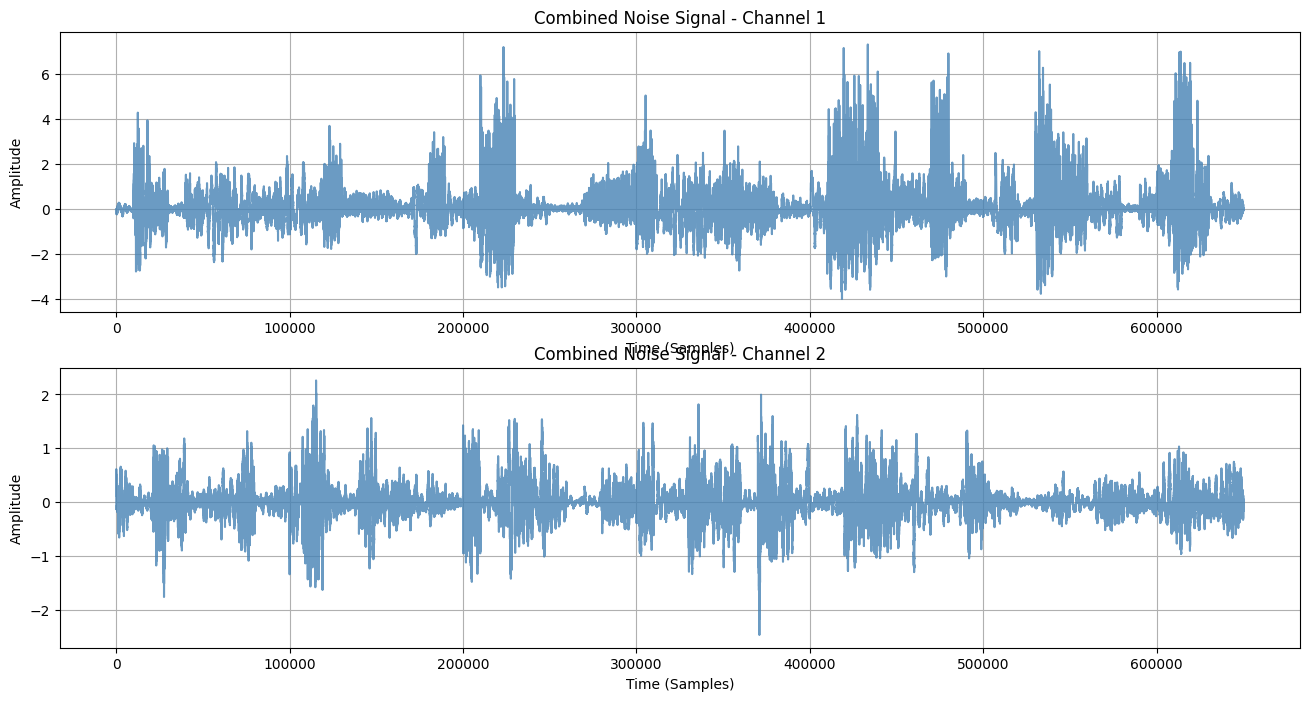

In [126]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# CombinedNoise.pkl 불러오기
with open('data/CombinedNoise.pkl', 'rb') as f:
    combined_noise = pickle.load(f)

# combined_noise: (2, 650000, 1) → reshape for easier handling
combined_noise = np.squeeze(combined_noise)  # (2, 650000)

# 시각화 설정
time = np.arange(combined_noise.shape[1])  # 시간 축 생성 (샘플 인덱스)
channel_labels = ['Channel 1', 'Channel 2']

plt.figure(figsize=(16, 8))

# 두 채널 모두 시각화
for channel_idx in range(2):
    plt.subplot(2, 1, channel_idx + 1)
    plt.plot(time, combined_noise[channel_idx], color='steelblue', alpha=0.8)
    plt.title(f"Combined Noise Signal - {channel_labels[channel_idx]}")
    plt.xlabel("Time (Samples)")
    plt.ylabel("Amplitude")
    plt.grid(True)

print(f'snr_info: {snr_info[:]}')  # 처음 5개의 SNR 정보 출력

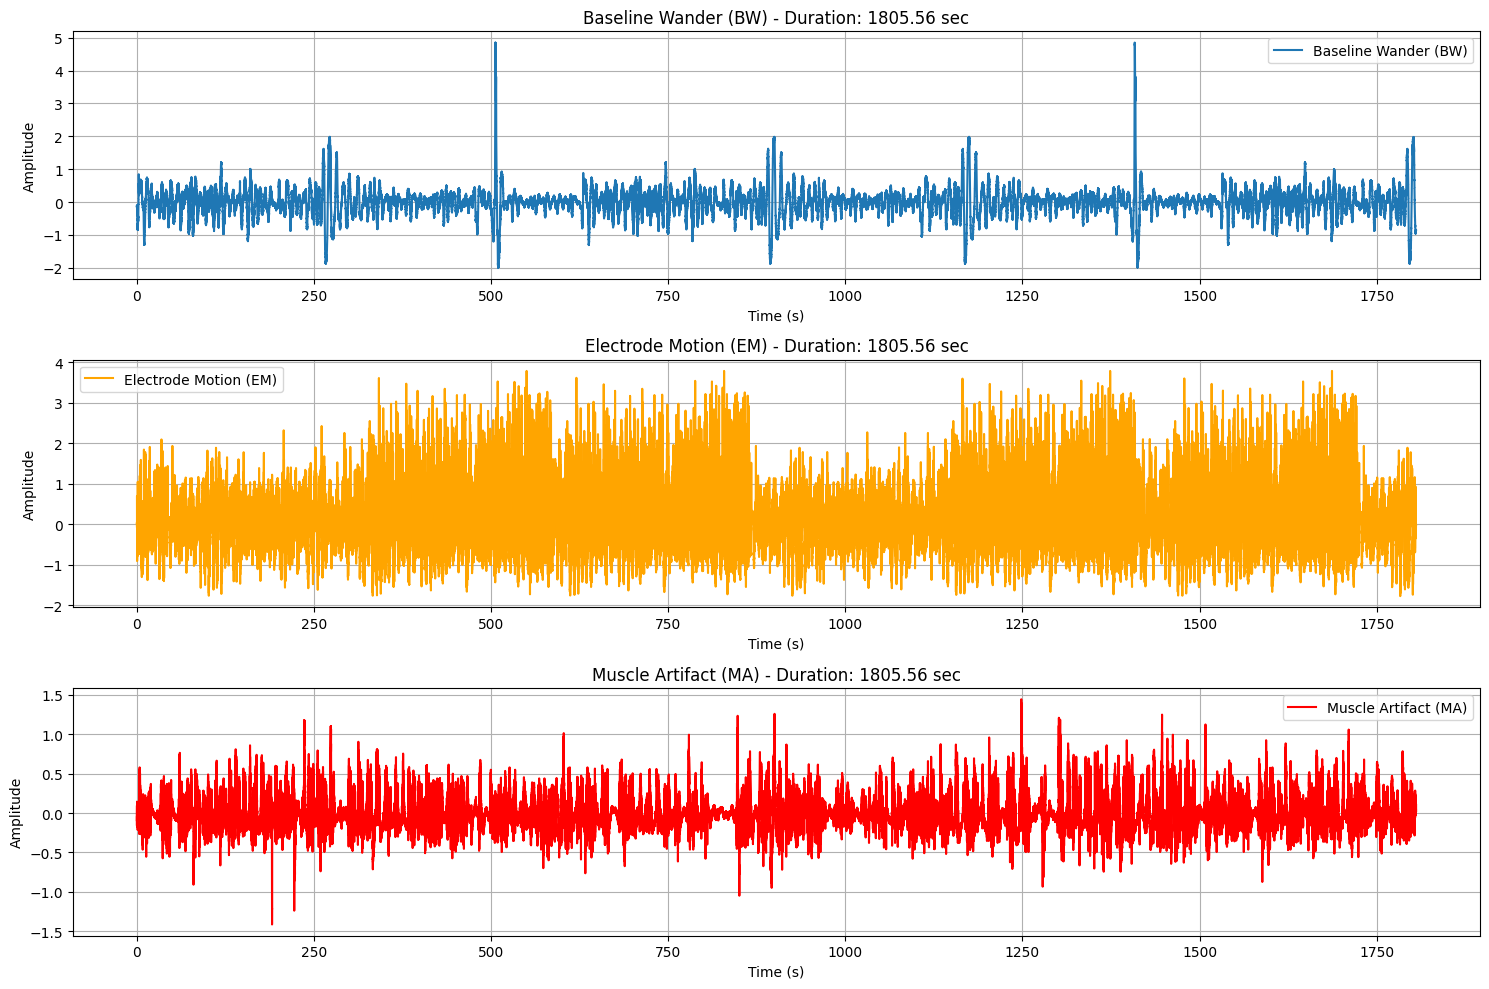

In [8]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

def visualize_nstdb_noise_full(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Visualizes the full duration of each noise type from the MIT-BIH Noise Stress Test Database (NSTDB):
    Baseline Wander (BW), Electrode Motion (EM), and Muscle Artifact (MA).
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Define sampling frequency and time vector
    fs = 360  # NSTDB sampling frequency is 360 Hz
    duration_bw = len(bw_signals) / fs
    duration_em = len(em_signals) / fs
    duration_ma = len(ma_signals) / fs

    time_bw = np.linspace(0, duration_bw, len(bw_signals))
    time_em = np.linspace(0, duration_em, len(em_signals))
    time_ma = np.linspace(0, duration_ma, len(ma_signals))

    # Plot each noise signal
    plt.figure(figsize=(15, 10))
    
    # Baseline Wander
    plt.subplot(3, 1, 1)
    plt.plot(time_bw, bw_signals[:, 0], label='Baseline Wander (BW)')
    plt.title(f'Baseline Wander (BW) - Duration: {duration_bw:.2f} sec')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    
    # Electrode Motion
    plt.subplot(3, 1, 2)
    plt.plot(time_em, em_signals[:, 0], label='Electrode Motion (EM)', color='orange')
    plt.title(f'Electrode Motion (EM) - Duration: {duration_em:.2f} sec')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    
    # Muscle Artifact
    plt.subplot(3, 1, 3)
    plt.plot(time_ma, ma_signals[:, 0], label='Muscle Artifact (MA)', color='red')
    plt.title(f'Muscle Artifact (MA) - Duration: {duration_ma:.2f} sec')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_nstdb_noise_full()


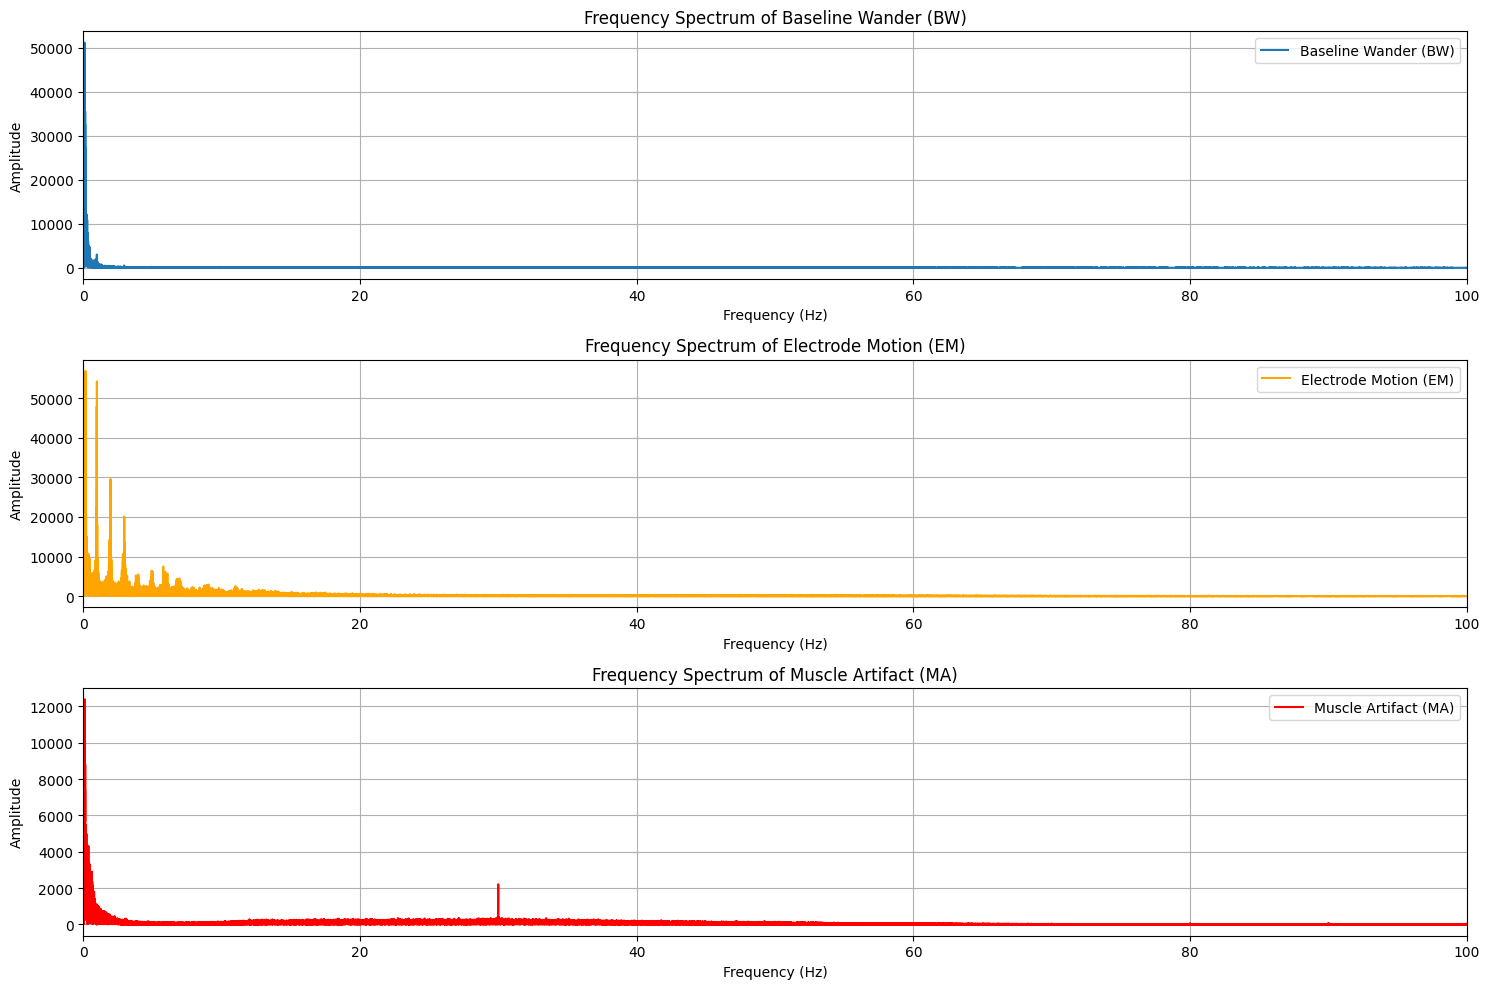

In [9]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

def plot_nstdb_frequency_spectrum(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Computes and visualizes the frequency spectrum of each noise type from 
    the MIT-BIH Noise Stress Test Database (NSTDB): 
    - Baseline Wander (BW)
    - Electrode Motion (EM)
    - Muscle Artifact (MA)

    Uses FFT to analyze frequency components.
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')

    # Define sampling frequency
    fs = 360  # NSTDB sampling frequency is 360 Hz

    # Select first channel and flatten the signal
    bw_signal = bw_signals[:, 0]
    em_signal = em_signals[:, 0]
    ma_signal = ma_signals[:, 0]

    # Compute FFT
    def compute_fft(signal, fs):
        N = len(signal)  # Number of samples
        fft_vals = np.fft.fft(signal)  # FFT computation
        fft_freqs = np.fft.fftfreq(N, d=1/fs)  # Frequency bins
        return fft_freqs[:N // 2], np.abs(fft_vals[:N // 2])  # Return positive frequencies

    freq_bw, fft_bw = compute_fft(bw_signal, fs)
    freq_em, fft_em = compute_fft(em_signal, fs)
    freq_ma, fft_ma = compute_fft(ma_signal, fs)

    # Plot Frequency Spectrum
    plt.figure(figsize=(15, 10))

    # Baseline Wander
    plt.subplot(3, 1, 1)
    plt.plot(freq_bw, fft_bw, label='Baseline Wander (BW)')
    plt.title('Frequency Spectrum of Baseline Wander (BW)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 100)  # Focus on 0-100 Hz range
    plt.grid(True)
    plt.legend()

    # Electrode Motion
    plt.subplot(3, 1, 2)
    plt.plot(freq_em, fft_em, label='Electrode Motion (EM)', color='orange')
    plt.title('Frequency Spectrum of Electrode Motion (EM)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 100)
    plt.grid(True)
    plt.legend()

    # Muscle Artifact
    plt.subplot(3, 1, 3)
    plt.plot(freq_ma, fft_ma, label='Muscle Artifact (MA)', color='red')
    plt.title('Frequency Spectrum of Muscle Artifact (MA)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, 100)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_nstdb_frequency_spectrum()


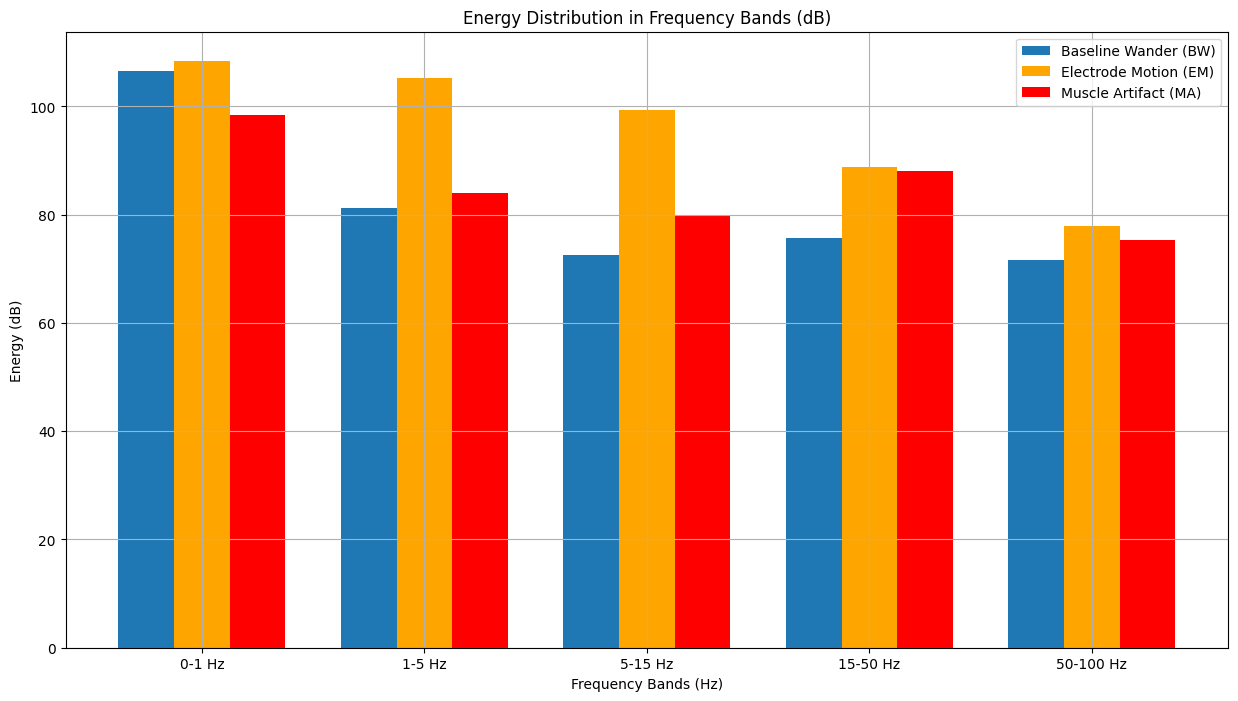

In [10]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

def compute_band_energy(signal, fs, bands):
    """
    Compute the energy in specific frequency bands and convert to dB.
    
    Parameters:
    - signal: 1D array of the signal.
    - fs: Sampling frequency (Hz).
    - bands: List of tuples specifying frequency bands [(fmin1, fmax1), (fmin2, fmax2), ...].
    
    Returns:
    - band_energies: List of energies in dB for each frequency band.
    """
    N = len(signal)
    fft_vals = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(N, d=1/fs)
    
    band_energies = []
    for fmin, fmax in bands:
        band_mask = (fft_freqs >= fmin) & (fft_freqs <= fmax)
        band_energy = np.sum(np.abs(fft_vals[band_mask])**2)  # Compute energy in the band
        band_energy_db = 10 * np.log10(band_energy + 1e-10)  # Convert to dB
        band_energies.append(band_energy_db)
    
    return band_energies

def visualize_nstdb_noise_energy(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Visualizes the energy in different frequency bands (in dB) for each noise type 
    from the MIT-BIH Noise Stress Test Database (NSTDB): 
    Baseline Wander (BW), Electrode Motion (EM), and Muscle Artifact (MA).
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Define sampling frequency
    fs = 360  # NSTDB sampling frequency is 360 Hz
    
    # Select first channel
    bw_signal = bw_signals[:, 0]
    em_signal = em_signals[:, 0]
    ma_signal = ma_signals[:, 0]

    # Frequency bands (in Hz)
    bands = [(0, 1), (1, 5), (5, 15), (15, 50), (50, 100)]  # You can modify these bands

    # Compute energy in each band
    bw_energies = compute_band_energy(bw_signal, fs, bands)
    em_energies = compute_band_energy(em_signal, fs, bands)
    ma_energies = compute_band_energy(ma_signal, fs, bands)
    
    # Plot energy for each noise type
    band_labels = [f'{fmin}-{fmax} Hz' for fmin, fmax in bands]

    plt.figure(figsize=(15, 8))
    
    x = np.arange(len(bands))
    width = 0.25  # Bar width

    # Baseline Wander
    plt.bar(x - width, bw_energies, width, label='Baseline Wander (BW)')
    
    # Electrode Motion
    plt.bar(x, em_energies, width, label='Electrode Motion (EM)', color='orange')
    
    # Muscle Artifact
    plt.bar(x + width, ma_energies, width, label='Muscle Artifact (MA)', color='red')
    
    # Plot settings
    plt.xticks(x, band_labels)
    plt.xlabel('Frequency Bands (Hz)')
    plt.ylabel('Energy (dB)')
    plt.title('Energy Distribution in Frequency Bands (dB)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
visualize_nstdb_noise_energy()


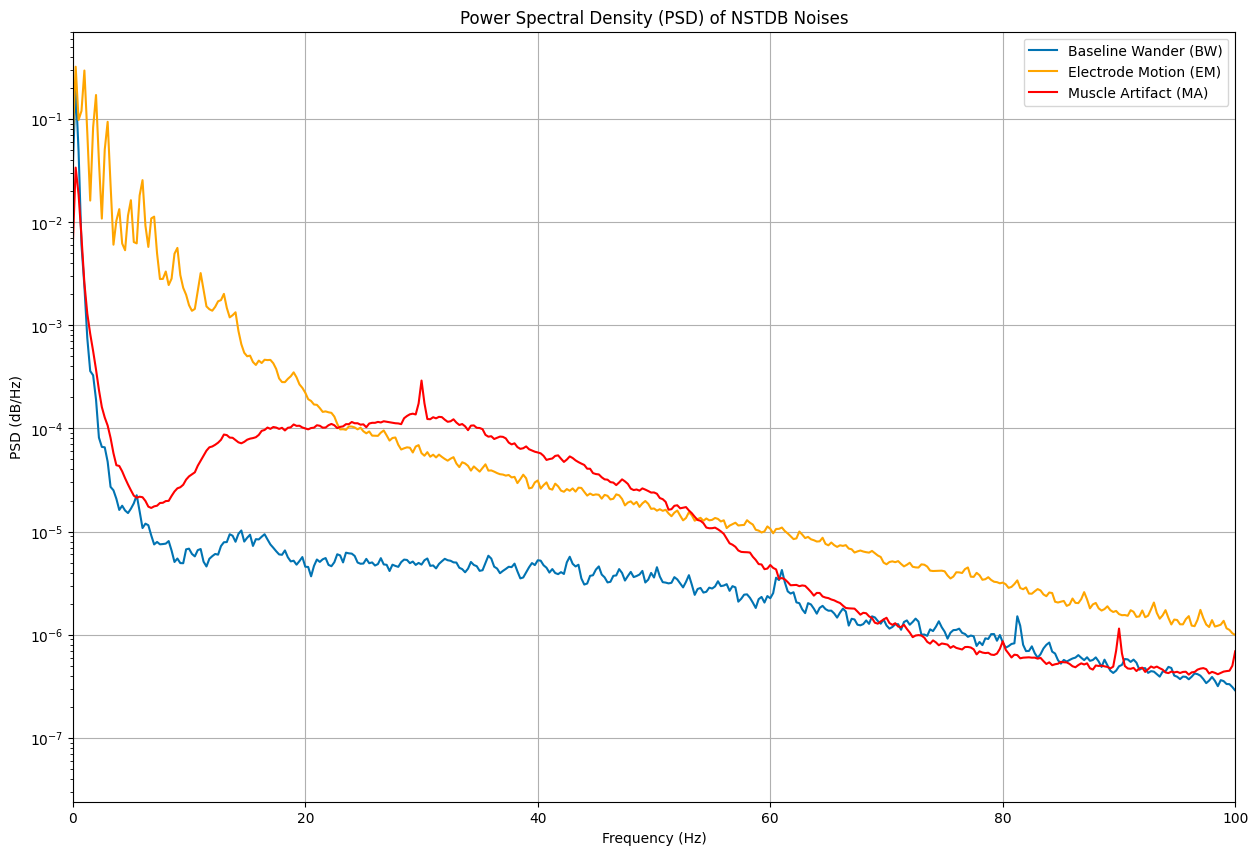

In [54]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def plot_nstdb_psd(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
    """
    Computes and visualizes the Power Spectral Density (PSD) for each noise type 
    from the MIT-BIH Noise Stress Test Database (NSTDB).
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Define sampling frequency
    fs = 360  # Sampling frequency (Hz)

    # Welch's method to compute PSD
    def compute_psd(signal, fs):
        freqs, psd = welch(signal, fs, nperseg=fs*4)  # Use 4-second segments for PSD
        return freqs, psd

    # Compute PSD for each noise signal
    freqs_bw, psd_bw = compute_psd(bw_signals[:, 0], fs)
    freqs_em, psd_em = compute_psd(em_signals[:, 0], fs)
    freqs_ma, psd_ma = compute_psd(ma_signals[:, 0], fs)

    # Plot PSD for each noise
    plt.figure(figsize=(15, 10))

    plt.semilogy(freqs_bw, psd_bw, label='Baseline Wander (BW)')
    plt.semilogy(freqs_em, psd_em, label='Electrode Motion (EM)', color='orange')
    plt.semilogy(freqs_ma, psd_ma, label='Muscle Artifact (MA)', color='red')
    
    plt.title('Power Spectral Density (PSD) of NSTDB Noises')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (dB/Hz)')
    plt.xlim(0, 100)  # Focus on 0–100 Hz range
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
plot_nstdb_psd()


onlybw

In [11]:
# only_bw = pickle.load(open('data/NoiseBWL.pkl', 'rb'))
# # Convert the list to a numpy array and get its shape
# only_bw_array = np.array(only_bw)
# only_bw_shape = only_bw_array.shape

# only_bw_shape

static

In [12]:
static_noise = pickle.load(open('data/StaticNoise.pkl', 'rb'))
# Convert the list to a numpy array and get its shape
static_noise = np.array(static_noise)
static_noise_shape = static_noise.shape

static_noise_shape

(2, 650000, 8)

In [13]:
import wfdb
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.signal import resample

def visualize_and_save_noise(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/', chunk_size=10000, save_path='fig4/'):
    """
    Visualizes and saves plots for:
    - Full BW, EM, MA signals with masking for non-included chunks.
    - Combined noise for a single chunk.

    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    chunk_size: Number of samples per chunk.
    save_path: Path to save the figures.
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Resample signals to 360 Hz
    def resample_signal(signal, target_fs=360, original_fs=128):
        return resample(signal, int(len(signal) * (target_fs / original_fs)))

    bw_noise = resample_signal(bw_signals[:, 0])
    em_noise = resample_signal(em_signals[:, 0])
    ma_noise = resample_signal(ma_signals[:, 0])

    # Load combined noise
    with open('data/CombinedNoise.pkl', 'rb') as f:
        combined_noise = pickle.load(f)
    combined_resampled = resample(combined_noise[0, :, 0], len(bw_noise))

    # Define chunks
    num_chunks = len(bw_noise) // chunk_size
    x = np.arange(len(bw_noise))
    chunks = np.array_split(x, num_chunks)
    
    # Random flags for EM and MA inclusion
    em_flags = np.random.choice([0, 1], size=num_chunks)
    ma_flags = np.random.choice([0, 1], size=num_chunks)

    # Plot BW Noise
    plt.figure(figsize=(24,8))
    plt.plot(x, bw_noise, color='blue')
    plt.title("Baseline Wander (BW) Noise")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.savefig(f"{save_path}bw_noise.png")
    plt.close()
    
    # Plot EM Noise
    plt.figure(figsize=(24,8))
    plt.plot(x, em_noise, color='green')
    # plt.title("Electrode Motion (EM) Noise")
    # plt.xlabel("Sample Index")
    # plt.ylabel("Amplitude")
    plt.axis('off')  # 축과 테두리를 모두 숨김
    plt.savefig(f"{save_path}em2_noise.png")
    plt.close()    
    
    # Plot MA Noise
    plt.figure(figsize=(24,8))
    plt.plot(x, ma_noise, color='red')
    # plt.title("Muscle Artifact (MA) Noise")
    # plt.xlabel("Sample Index")
    # plt.ylabel("Amplitude")
    plt.axis('off')  # 축과 테두리를 모두 숨김
    plt.savefig(f"{save_path}ma2_noise.png")
    plt.close()
    # Plot Combined Noise
    plt.figure(figsize=(24,8))
    plt.plot(x[:chunk_size], combined_resampled[:chunk_size], color='purple')
    plt.title("Combined Noise for First Chunk")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.savefig(f"{save_path}combined_noise.png")
    plt.close()

    print("Plots saved successfully!")

# Call the function to visualize and save
visualize_and_save_noise(chunk_size=10000, save_path='fig4/')

import wfdb
import numpy as np
import pickle
import matplotlib.pyplot as plt

def visualize_with_district_lines(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/', chunk_size=10000):
    """
    Visualizes the entire noise signals with district lines for chunks:
    - Baseline Wander (BW) noise (always visible)
    - Electrode Motion (EM) noise (masked in gray for unselected chunks)
    - Muscle Artifact (MA) noise (masked in gray for unselected chunks)
    - Combined Noise

    Parameters:
    NSTDBPath: Path to the NSTDB dataset.
    chunk_size: Number of samples per chunk.
    """
    # Load NSTDB noise signals
    bw_signals, _ = wfdb.rdsamp(NSTDBPath + 'bw')
    em_signals, _ = wfdb.rdsamp(NSTDBPath + 'em')
    ma_signals, _ = wfdb.rdsamp(NSTDBPath + 'ma')
    
    # Load combined noise matrix
    with open('data/CombinedNoise.pkl', 'rb') as f:
        combined_noise = pickle.load(f)

    # Determine the number of chunks based on the total length and chunk size
    total_samples = bw_signals.shape[0]
    num_chunks = total_samples // chunk_size
    x = np.arange(total_samples)  # X-axis for the entire length

    # Generate random flags for EM and MA visibility simulation (for demonstration)
    np.random.seed(1234)  # For reproducibility
    em_flags = np.random.choice([0, 1], size=num_chunks)
    ma_flags = np.random.choice([0, 1], size=num_chunks)

    # Function to create and save individual plots
    def create_and_save_plot(data, title, color, filename, flags=None):
        plt.figure(figsize=(28,8))
        if flags is not None:
            data_copy = data.copy()
            for i in range(num_chunks):
                if flags[i] == 0:
                    data_copy[i * chunk_size:(i + 1) * chunk_size] = np.nan
            plt.plot(x, data_copy, label=f'{title}', color=color)
        else:
            plt.plot(x, data, label=f'{title}', color=color)
        
        for i in range(1, num_chunks):
            plt.axvline(x=i * chunk_size, color='black', linestyle='dotted', alpha=0.7)

        plt.title(title, fontsize=40, fontweight='bold')  # 제목 폰트 크기를 20으로 설정
        plt.xlabel("Sample Length (N)", fontsize=35)  # x축 레이블 폰트 크기를 15로 설정
        plt.ylabel("Amplitude", fontsize=35)
        plt.xticks(fontsize=25)  # x축 눈금 폰트 크기를 12로 설정
        plt.yticks(fontsize=25)
        # plt.legend(fontsize=18, loc='upper right')  # 범례 폰트 크기를 15로 설정
        plt.tight_layout()
        plt.savefig(f"fig4/{filename}.png")
        plt.close()

    # Create and save individual plots
    create_and_save_plot(bw_signals[:, 0], "Baseline Wander Noise (BW)", 'blue', "bw_noise")
    create_and_save_plot(em_signals[:, 0], "Electrode Motion Noise (EM)", 'green', "em_noise", em_flags)
    create_and_save_plot(ma_signals[:, 0], "Muscle Artifact Noise (MA)", 'red', "ma_noise", ma_flags)
    create_and_save_plot(combined_noise[0][:, 0], "", 'purple', "combined_noise")

# Visualize noise with district lines and masking
visualize_with_district_lines()

Plots saved successfully!


# mit bih Dataset

In [ ]:
import numpy as np
import wfdb
import _pickle as pickle

In [ ]:
import glob
import numpy as np
from scipy.signal import resample_poly
import wfdb
import math
import pandas as pd
import _pickle as pickle
import matplotlib.pyplot as plt
from collections import Counter

# MIT-BIH Database 전처리 및 라벨 추가
def prepare_mitdb_with_labels(mitpath='/home/dhc99/ecg_denoise/data/physionet.org/files/mitdb/1.0.0/'):
    ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']
    MITDatabaseSignals = dict()
    patient_ids = pd.read_csv(mitpath + 'RECORDS', header=None).squeeze("columns").to_numpy()

    for pid in patient_ids:
        signal, fields = wfdb.rdsamp(mitpath + str(pid))
        ann = wfdb.rdann(mitpath + str(pid), 'atr')
        annSamples = ann.sample
        annLabels = ann.symbol
        auxSig = signal[:, 0]
        beats_with_labels = []

        for i in range(1, len(annSamples) - 1):
            beat = auxSig[max(0, annSamples[i] - 99): min(len(auxSig), annSamples[i] + 201)]
            if len(beat) <= 300 and annLabels[i] in ecgClassSet:
                label = ecgClassSet.index(annLabels[i])
                beat_padded = np.zeros(300)
                beat_padded[:len(beat)] = beat - (beat[0] + beat[-1]) / 2  # Centering
                beats_with_labels.append((beat_padded, label))
        
        MITDatabaseSignals[pid] = beats_with_labels

    with open('data/MITDatabase_with_labels.pkl', 'wb') as output:
        pickle.dump(MITDatabaseSignals, output)
    print('MIT-BIH database with labels saved as pickle file.')


# Load 데이터
with open('data/MITDatabase_with_labels.pkl', 'rb') as input:
    mitdb_with_labels = pickle.load(input)

# 15-class에서 5-class로 그룹핑 함수
def group_to_5class(label):
    if 0 <= label <= 4:
        return 0  # Normal beats
    elif 5 <= label <= 8:
        return 1  # Supraventricular beats
    elif 9 <= label <= 10:
        return 2  # Ventricular beats
    elif label == 11:
        return 3  # Fusion beats
    elif 12 <= label <= 14:
        return 4  # Unknown beats
    else:
        return -1  # 오류 방지용 기본값

# 5-class로 변환된 라벨 저장
all_labels_5class = [group_to_5class(label) for pid in mitdb_with_labels.keys() for _, label in mitdb_with_labels[pid]]
all_labels_5class = [label for label in all_labels_5class if label != -1]  # -1 제거

# 5-class 분포 확인
class_counts_5class = Counter(all_labels_5class)
print("5-Class distribution:", class_counts_5class)


5-Class distribution: Counter({0: 90589, 4: 8039, 2: 7236, 1: 2779, 3: 803})


In [55]:
class_counts_15class = Counter(all_labels)
print("15-Class distribution:", class_counts_15class)


15-Class distribution: Counter({0: 75016, 1: 8072, 2: 7256, 9: 7130, 12: 7024, 5: 2544, 13: 982, 11: 803, 4: 229, 6: 150, 10: 106, 7: 83, 14: 33, 3: 16, 8: 2})


Before SMOTE - Class Distribution: Counter({0: 90589, 4: 8039, 2: 7236, 1: 2779, 3: 803})
After SMOTE - Class Distribution: Counter({0: 20000, 1: 20000, 2: 20000, 4: 20000, 3: 20000})
Balanced MIT-BIH database saved as pickle file (dict format).


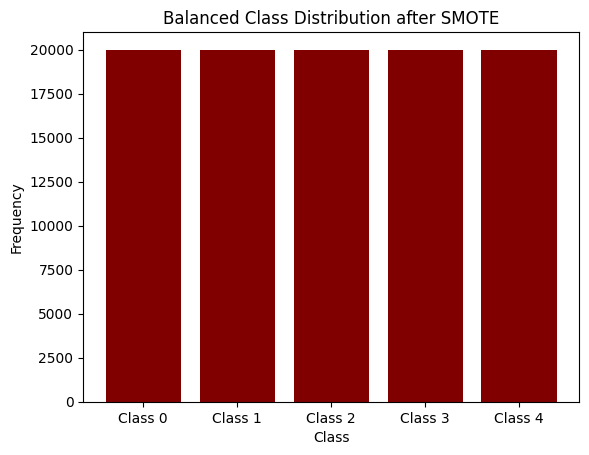

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import _pickle as pickle

# Load MIT-BIH 데이터 (dict 구조)
with open('data/MITDatabase_with_labels.pkl', 'rb') as input:
    mitdb_with_labels = pickle.load(input)

# 15-class에서 5-class로 그룹핑 함수
def group_to_5class(label):
    if 0 <= label <= 4:
        return 0  # Normal beats
    elif 5 <= label <= 8:
        return 1  # Supraventricular beats
    elif 9 <= label <= 10:
        return 2  # Ventricular beats
    elif label == 11:
        return 3  # Fusion beats
    elif 12 <= label <= 14:
        return 4  # Unknown beats
    else:
        return -1  # 오류 방지용 기본값

# 데이터 변환 및 그룹핑 (dict → X, y 배열로 변환)
X_data = []
y_data = []
beat_dict = {}

for pid in mitdb_with_labels.keys():
    beats = mitdb_with_labels[pid]
    for beat, label in beats:
        grouped_label = group_to_5class(label)
        if grouped_label != -1:
            X_data.append(beat)
            y_data.append(grouped_label)
            if pid not in beat_dict:
                beat_dict[pid] = []
            beat_dict[pid].append((beat, grouped_label))

X_data = np.array(X_data)
y_data = np.array(y_data)

# 클래스 분포 확인 (SMOTE 전)
class_counts_before = Counter(y_data)
print("Before SMOTE - Class Distribution:", class_counts_before)

# ------------------------
# SMOTE 적용 (Class 1~4는 각각 50000개로 oversample, Class 0도 50000개로 맞춤)
# ------------------------
X_class0 = X_data[y_data == 0]
X_class_others = X_data[y_data != 0]
y_class0 = y_data[y_data == 0]
y_class_others = y_data[y_data != 0]

# Class 0에서 50000개 랜덤 샘플링
X_class0_resampled, y_class0_resampled = resample(X_class0, y_class0, n_samples=20000, random_state=42)

# SMOTE로 Class 1~4를 각각 50000개로 oversample
smote_strategy = {1: 20000, 2: 20000, 3: 20000, 4: 20000}
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
X_oversampled, y_oversampled = smote.fit_resample(X_class_others, y_class_others)

# Resampled 데이터 합치기
X_balanced = np.vstack((X_class0_resampled, X_oversampled))
y_balanced = np.hstack((y_class0_resampled, y_oversampled))

# 클래스 분포 확인 (SMOTE 후)
class_counts_after = Counter(y_balanced)
print("After SMOTE - Class Distribution:", class_counts_after)

# ------------------------
# dict 구조로 변환 (균형 잡힌 데이터를 다시 dict로 저장)
# ------------------------
balanced_dict = {}
for i in range(len(X_balanced)):
    pid = f"balanced_{i // 1000}"  # 새로운 환자 ID 형식
    if pid not in balanced_dict:
        balanced_dict[pid] = []
    balanced_dict[pid].append((X_balanced[i], y_balanced[i]))

# ------------------------
# 데이터 저장 (Balanced 데이터셋)
# ------------------------
with open('data/MITDatabase_balanced.pkl', 'wb') as output:
    pickle.dump(balanced_dict, output)
print("Balanced MIT-BIH database saved as pickle file (dict format).")

# ------------------------
# 클래스 분포 시각화
# ------------------------
plt.bar(class_counts_after.keys(), class_counts_after.values(), color='maroon')
plt.xticks(range(5), ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Balanced Class Distribution after SMOTE")
plt.show()


In [133]:
# pickle 파일 열기
with open('data/MITDatabase_balanced.pkl', 'rb') as file:
    data = pickle.load(file)

# 데이터 타입과 구조 확인
print("데이터 타입:", type(data))

데이터 타입: <class 'dict'>


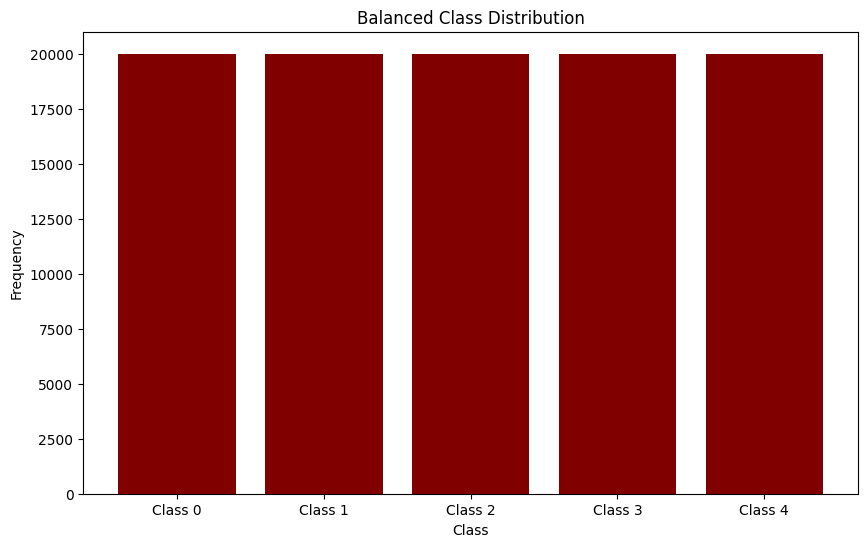

Class Distribution: Counter({0: 20000, 1: 20000, 2: 20000, 4: 20000, 3: 20000})


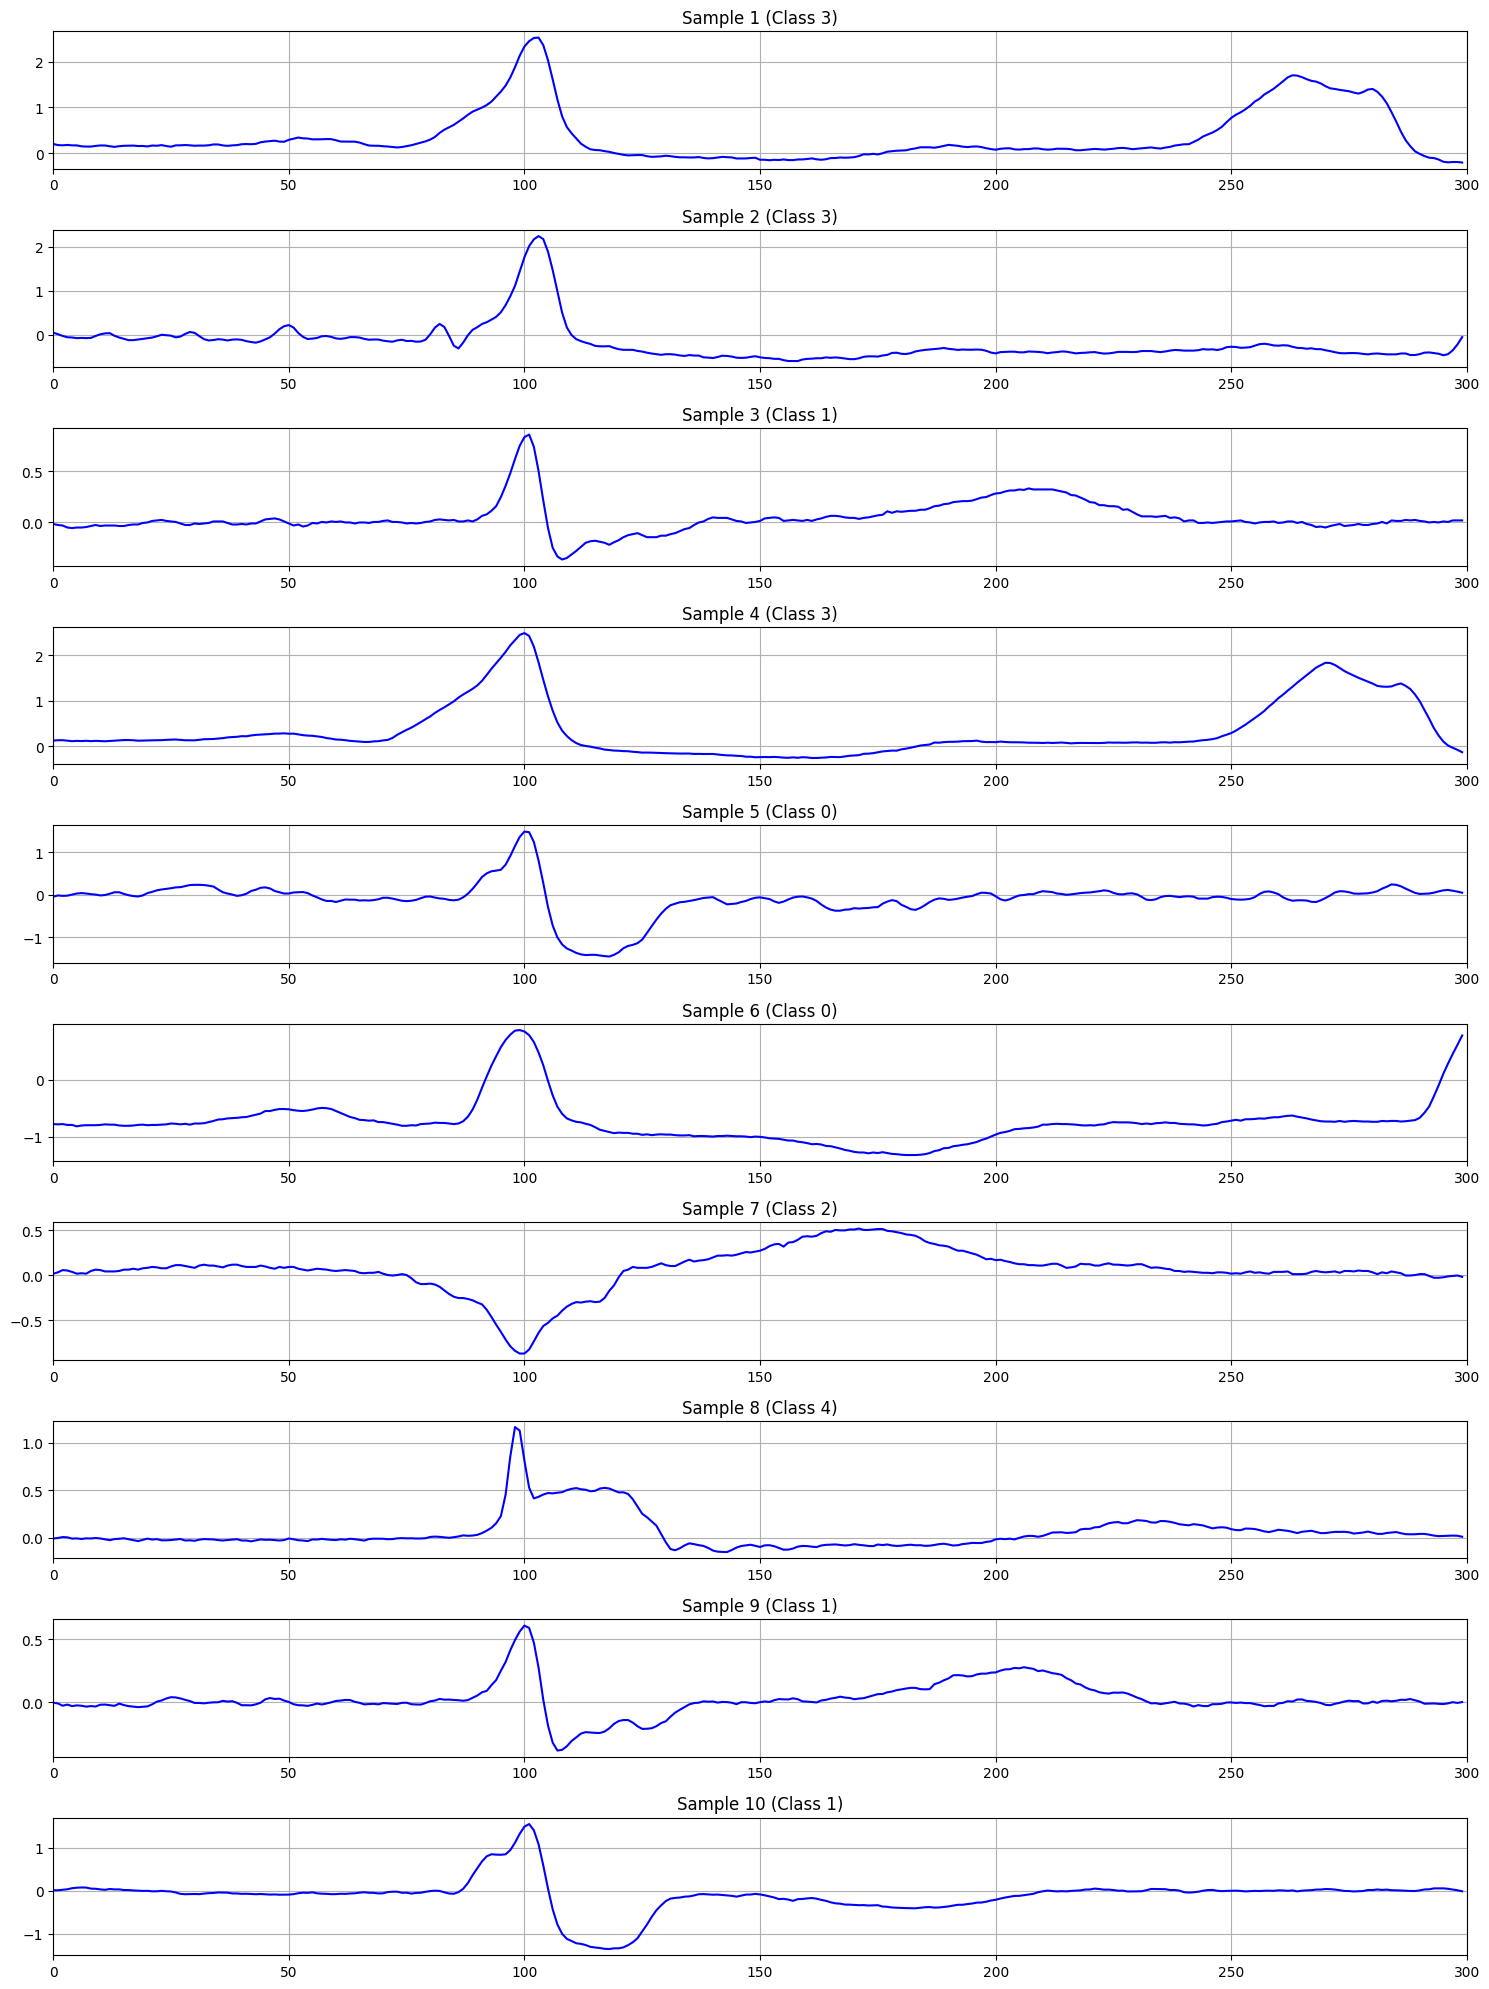

In [134]:
import matplotlib.pyplot as plt
import random
from collections import Counter
import _pickle as pickle

# ------------------------
# 데이터 로드
# ------------------------
with open('data/MITDatabase_balanced.pkl', 'rb') as input:
    balanced_dict = pickle.load(input)

# ------------------------
# 클래스 분포 시각화 함수
# ------------------------
def plot_class_distribution(data_dict):
    all_labels = [label for beats in data_dict.values() for _, label in beats]
    class_counts = Counter(all_labels)
    
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='maroon')
    plt.xticks(range(5), ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"])
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title("Balanced Class Distribution")
    plt.show()
    
    print("Class Distribution:", class_counts)

# ------------------------
# 랜덤 ECG 샘플 시각화 함수
# ------------------------
def plot_random_ecg_samples(data_dict, num_samples=10):
    samples = []
    for beats in data_dict.values():
        samples.extend(beats)
    
    # 랜덤으로 num_samples만큼 샘플 추출
    random_samples = random.sample(samples, num_samples)
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, num_samples * 2))
    for i, (ecg, label) in enumerate(random_samples):
        axes[i].plot(ecg, color='blue')
        axes[i].set_title(f"Sample {i+1} (Class {label})")
        axes[i].set_xlim(0, 300)
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

# ------------------------
# 시각화 실행
# ------------------------
plot_class_distribution(balanced_dict)
plot_random_ecg_samples(balanced_dict, num_samples=10)


In [135]:

# # 5-class 시각화 함수
# def plot_5class_samples(mitdb_with_labels, target_class, num_samples=5):
#     """
#     특정 5-class 그룹의 ECG 비트를 시각화합니다.
#     """
#     fig, axs = plt.subplots(num_samples, 1, figsize=(12, 2 * num_samples))
#     fig.suptitle(f"5-Class {target_class} - ECG Beat Samples", fontsize=16)
    
#     sample_count = 0
#     for pid in mitdb_with_labels.keys():
#         for beat, label in mitdb_with_labels[pid]:
#             if group_to_5class(label) == target_class:
#                 axs[sample_count].plot(beat, color='green')
#                 axs[sample_count].set_title(f"Patient {pid} - Sample {sample_count + 1}")
#                 axs[sample_count].set_xlabel("Sample Index")
#                 axs[sample_count].set_ylabel("Amplitude")
#                 sample_count += 1
#                 if sample_count >= num_samples:
#                     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#                     plt.show()
#                     return

# # 5-class 그룹 시각화
# for class_index in range(5):
#     print(f"Visualizing samples for 5-Class {class_index}...")
#     plot_5class_samples(mitdb_with_labels, class_index, num_samples=5)


In [60]:
# import glob
# import numpy as np
# from scipy.signal import resample_poly
# import wfdb
# import math
# import _pickle as pickle

# def prepare_mitdb(mitpath='/home/dhc99/ecg_denoise/data/physionet.org/files/mitdb/1.0.0/'):
#     """
#     MIT-BIH Database 전처리 및 300 길이의 비트 생성.
#     """
#     # Desired sampling frequency
#     newFs = 360

#     # Preprocessing signals
#     patient_ids = pd.read_csv(mitpath + 'RECORDS', header=None).squeeze("columns").to_numpy()
    
#     # final list that will contain all signals and beats processed
#     MITDatabaseSignals = dict()

#     for pid in patient_ids:
#         signal, fields = wfdb.rdsamp(mitpath + str(pid))
#         ann = wfdb.rdann(mitpath + str(pid), 'atr')
#         annSamples = ann.sample

#         # Extract first channel and split into 300-length beats
#         auxSig = signal[:, 0]
#         beats = [auxSig[max(0, annSamples[i] - 99): min(len(auxSig), annSamples[i] + 201)] for i in range(1, len(annSamples) - 1)]

#         # Padding and resampling each beat to 360 Hz with length 300
#         processed_beats = []
#         for b in beats:
#             if len(b) > 300:  # Skip too long beats
#                 continue
#             b_padded = np.zeros(300)
#             b_padded[:len(b)] = b - (b[0] + b[-1]) / 2  # Centering
#             processed_beats.append(b_padded)

#         # Store processed beats for the patient
#         MITDatabaseSignals[pid] = processed_beats

#     # Save MIT Database as pickle
#     with open('data/MITDatabase.pkl', 'wb') as output:
#         pickle.dump(MITDatabaseSignals, output)
#     print('=========================================================')
#     print('MIT-BIH database saved as pickle file')

# prepare_mitdb()

[INFO] Loaded MITDatabase with 48 signals
112551


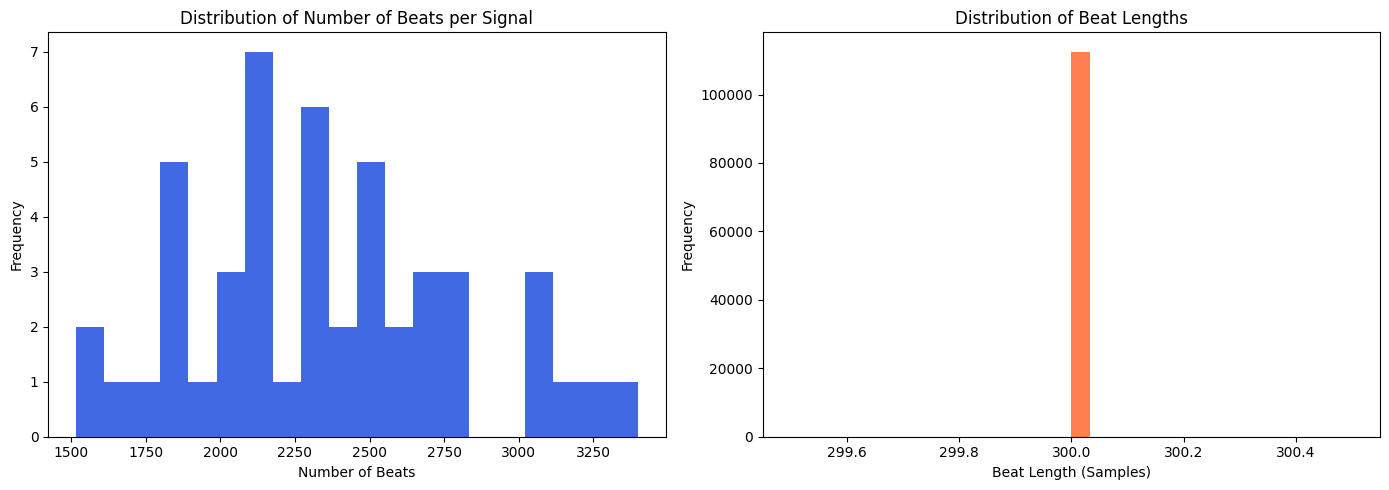

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load MIT Database
with open('data/MITDatabase.pkl', 'rb') as input:
    mitdb = pickle.load(input)

# Print basic info
print(f"[INFO] Loaded MITDatabase with {len(mitdb.keys())} signals")

# Visualize the shape of beats for each signal
signal_lengths = [len(beats) for beats in mitdb.values()]
beat_lengths = [len(beat) for beats in mitdb.values() for beat in beats]
print(len(beat_lengths))
# Plot the distribution of signal and beat lengths
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.hist(signal_lengths, bins=20, color='royalblue')
plt.title('Distribution of Number of Beats per Signal')
plt.xlabel('Number of Beats')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(beat_lengths, bins=30, color='coral')
plt.title('Distribution of Beat Lengths')
plt.xlabel('Beat Length (Samples)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Visualize one sample beat from the first signal in mitdb
first_signal = list(mitdb.keys())[0]
sample_beat = mitdb[first_signal][0]

plt.figure(figsize=(10, 4))
plt.plot(sample_beat, color='darkgreen')
plt.title(f'Example Beat from Signal {first_signal}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [ ]:
# import numpy as np
# from scipy.fft import fft
# from scipy.signal import resample_poly
# import wfdb
# import math
# import _pickle as pickle

# def make_fourier(inputs, n, fs):
#     """
#     주파수 도메인 정보 추출 및 time-domain과 같은 shape으로 만듦.
#     """
#     T = n / fs
#     k = np.arange(n)
#     freq = k / T
#     freq = freq[range(int(n / 2))]

#     signal_list = []
#     for i in range(inputs.shape[0]):
#         y = inputs[i, :]
#         Y = fft(y) / n  # FFT 수행 후 정규화
#         Y = np.abs(Y[range(int(n / 2))])
#         Y_full = np.hstack([Y, Y])  # Duplicate to match time-domain size (512)
#         signal_list.append(Y_full)

#     return np.asarray(signal_list)

# def Data_Preparation_with_Fourier_mitdb(samples=512, fs=360):
#     """
#     MITDB 데이터셋을 준비하고 Fourier 변환된 주파수 도메인 정보와 함께 반환합니다.
#     """
#     print('Preparing the MITDB dataset...')

#     # Set random seed for reproducibility
#     seed = 1234
#     np.random.seed(seed=seed)

#     # Load MIT Database
#     with open('data/MITDatabase.pkl', 'rb') as input:
#         mitdb = pickle.load(input)
#     print(f"[INFO] Loaded MITDatabase with {len(mitdb.keys())} signals")

#     # Load combined noise
#     with open('data/CombinedNoise.pkl', 'rb') as input:
#         combined_noise = pickle.load(input)
#     print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

#     beats = []
#     fourier_x = []
#     fourier_y = []
#     valid_indices = []
#     sn = []

#     skip_beats = 0

#     print(f"[INFO] Processing MITDatabase, {len(mitdb.keys())} signals to process.")
#     for signal_name in mitdb.keys():
#         for b_idx, b in enumerate(mitdb[signal_name]):
#             b_np = np.zeros(samples)
#             b_sq = np.array(b)

#             init_padding = 16
#             if b_sq.shape[0] > (samples - init_padding):
#                 skip_beats += 1
#                 continue

#             b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

#             # Fourier 변환 적용 (주파수 도메인 정보, time-domain과 동일한 shape으로)
#             fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)
            
#             beats.append(b_np)
#             fourier_y.append(fourier_transformed_y[0])
#             valid_indices.append(len(beats) - 1)

#     #####################################
#     # Data split (80% train, 20% test)
#     #####################################
#     total_beats = len(beats)
#     split_idx = int(total_beats * 0.8)

#     beats_train = beats[:split_idx]
#     beats_test = beats[split_idx:]

#     fourier_train_y = fourier_y[:split_idx]
#     fourier_test_y = fourier_y[split_idx:]

#     #####################################
#     # Adding noise to train and test sets
#     #####################################
#     print(f"[INFO] Adding noise to train and test sets")
#     sn_train = []
#     sn_test = []
#     fourier_train_x = []
#     fourier_test_x = []

#     # Random scaling factor for train and test
#     rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
#     rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
#     np.save('rnd_test_mitdb.npy', rnd_test)

#     def add_noise(beats, rnd, combined_noise, samples):
#         sn = []
#         fourier_x = []
#         noise_index = 0
#         for beat_idx, beat in enumerate(beats):
#             selected_channel = beat_idx % 2
#             noise_combination_idx = 0
#             noise = combined_noise[selected_channel][:, noise_combination_idx]
#             noise_segment = noise[noise_index:noise_index + samples]
#             beat_max_value = np.max(beat) - np.min(beat)
#             noise_max_value = np.max(noise_segment) - np.min(noise_segment)
#             Ase = 1 if noise_max_value == 0 else noise_max_value / beat_max_value
#             alpha = rnd[beat_idx] / Ase
#             signal_noise = beat + alpha * noise_segment
#             sn.append(signal_noise)
#             fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
#             fourier_x.append(fourier_transformed_x[0])
#             noise_index += samples
#             if noise_index > (len(noise) - samples):
#                 noise_index = 0
#         return sn, fourier_x

#     # Add noise to train and test sets
#     sn_train, fourier_train_x = add_noise(beats_train, rnd_train, combined_noise, samples)
#     sn_test, fourier_test_x = add_noise(beats_test, rnd_test, combined_noise, samples)

#     #####################################
#     # Convert to NumPy arrays and reshape
#     #####################################
#     X_train = np.expand_dims(np.array(sn_train), axis=2)
#     y_train = np.expand_dims(np.array(beats_train), axis=2)
#     X_test = np.expand_dims(np.array(sn_test), axis=2)
#     y_test = np.expand_dims(np.array(beats_test), axis=2)
#     F_train_x = np.expand_dims(np.array(fourier_train_x), axis=2)
#     F_train_y = np.expand_dims(np.array(fourier_train_y), axis=2)
#     F_test_x = np.expand_dims(np.array(fourier_test_x), axis=2)
#     F_test_y = np.expand_dims(np.array(fourier_test_y), axis=2)

#     Dataset = [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y]

#     print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
#     print(f"[INFO] Fourier shapes -> F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}, F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")
#     print('Dataset ready to use.')

#     return Dataset
# def Data_Preparation_with_mitdb(samples=512, fs=360):
#     """
#     MITDB 데이터셋을 준비하고 Fourier 변환된 주파수 도메인 정보와 함께 반환합니다.
#     """
#     print('Preparing the MITDB dataset...')

#     # Set random seed for reproducibility
#     seed = 1234
#     np.random.seed(seed=seed)

#     # Load MIT Database
#     with open('data/MITDatabase.pkl', 'rb') as input:
#         mitdb = pickle.load(input)
#     print(f"[INFO] Loaded MITDatabase with {len(mitdb.keys())} signals")

#     # Load combined noise
#     with open('data/CombinedNoise.pkl', 'rb') as input:
#         combined_noise = pickle.load(input)
#     print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

#     beats = []
#     fourier_x = []
#     fourier_y = []
#     valid_indices = []
#     sn = []

#     skip_beats = 0

#     print(f"[INFO] Processing MITDatabase, {len(mitdb.keys())} signals to process.")
#     for signal_name in mitdb.keys():
#         for b_idx, b in enumerate(mitdb[signal_name]):
#             b_np = np.zeros(samples)
#             b_sq = np.array(b)

#             init_padding = 16
#             if b_sq.shape[0] > (samples - init_padding):
#                 skip_beats += 1
#                 continue

#             b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

#             # Fourier 변환 적용 (주파수 도메인 정보, time-domain과 동일한 shape으로)
#             fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)
            
#             beats.append(b_np)
#             fourier_y.append(fourier_transformed_y[0])
#             valid_indices.append(len(beats) - 1)

#     #####################################
#     # Data split (80% train, 20% test)
#     #####################################
#     total_beats = len(beats)
#     split_idx = int(total_beats * 0.8)

#     beats_train = beats[:split_idx]
#     beats_test = beats[split_idx:]

#     fourier_train_y = fourier_y[:split_idx]
#     fourier_test_y = fourier_y[split_idx:]

#     #####################################
#     # Adding noise to train and test sets
#     #####################################
#     print(f"[INFO] Adding noise to train and test sets")
#     sn_train = []
#     sn_test = []
#     fourier_train_x = []
#     fourier_test_x = []

#     # Random scaling factor for train and test
#     rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
#     rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
#     np.save('rnd_test_mitdb.npy', rnd_test)

#     def add_noise(beats, rnd, combined_noise, samples):
#         sn = []
#         fourier_x = []
#         noise_index = 0
#         for beat_idx, beat in enumerate(beats):
#             selected_channel = beat_idx % 2
#             noise_combination_idx = 0
#             noise = combined_noise[selected_channel][:, noise_combination_idx]
#             noise_segment = noise[noise_index:noise_index + samples]
#             beat_max_value = np.max(beat) - np.min(beat)
#             noise_max_value = np.max(noise_segment) - np.min(noise_segment)
#             Ase = 1 if noise_max_value == 0 else noise_max_value / beat_max_value
#             alpha = rnd[beat_idx] / Ase
#             signal_noise = beat + alpha * noise_segment
#             sn.append(signal_noise)
#             fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
#             fourier_x.append(fourier_transformed_x[0])
#             noise_index += samples
#             if noise_index > (len(noise) - samples):
#                 noise_index = 0
#         return sn, fourier_x

#     # Add noise to train and test sets
#     sn_train, fourier_train_x = add_noise(beats_train, rnd_train, combined_noise, samples)
#     sn_test, fourier_test_x = add_noise(beats_test, rnd_test, combined_noise, samples)

#     #####################################
#     # Convert to NumPy arrays and reshape
#     #####################################
#     X_train = np.expand_dims(np.array(sn_train), axis=2)
#     y_train = np.expand_dims(np.array(beats_train), axis=2)
#     X_test = np.expand_dims(np.array(sn_test), axis=2)
#     y_test = np.expand_dims(np.array(beats_test), axis=2)


#     Dataset = [X_train, y_train, X_test, y_test]

#     print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
#     print('Dataset ready to use.')

#     return Dataset


In [148]:
import numpy as np
from scipy.fft import fft
from scipy.signal import resample_poly
import wfdb
import math
import _pickle as pickle

def make_fourier(inputs, n, fs):
    """
    주파수 도메인 정보 추출 및 time-domain과 같은 shape으로 만듦.
    """
    T = n / fs
    k = np.arange(n)
    freq = k / T
    freq = freq[range(int(n / 2))]

    signal_list = []
    for i in range(inputs.shape[0]):
        y = inputs[i, :]
        Y = fft(y) / n  # FFT 수행 후 정규화
        Y = np.abs(Y[range(int(n / 2))])
        Y_full = np.hstack([Y, Y])  # Duplicate to match time-domain size (512)
        signal_list.append(Y_full)

    return np.asarray(signal_list)
def Data_Preparation_with_mitdb(samples=512, fs=360):
    """
    MITDB 데이터셋을 준비하고 Fourier 변환된 주파수 도메인 정보와 함께
    라벨(5-Class)도 반환합니다.
    """
    print('Preparing the MITDB dataset with labels...')

    # Set random seed for reproducibility
    seed = 1234
    np.random.seed(seed=seed)
    with open('data/CombinedNoise.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")
    # Load MIT Database with labels
    with open('data/MITDatabase_balanced.pkl', 'rb') as input:
        mitdb_with_labels = pickle.load(input)
    print(f"[INFO] Loaded MITDatabase with {len(mitdb_with_labels.keys())} signals")
    beats = []
    labels = []
    fourier_y = []
    X_data = []
    y_data = []
    for signal_name in mitdb_with_labels.keys():
        # pid = int(signal_name)  # signal_name을 정수형 환자 ID로 변환
        for beat, label in mitdb_with_labels[signal_name]:  # 비트와 라벨을 함께 처리
            b_np = np.zeros(samples)
            b_sq = np.array(beat)

            init_padding = 16
            if b_sq.shape[0] > (samples - init_padding):  # 샘플 길이를 초과하는 경우 스킵
                skip_beats += 1
                continue

            # 비트 데이터를 0으로 패딩하고 중심화 (Centering)
            b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

            # Fourier 변환 수행 (주파수 도메인 정보 생성)
            fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)

            # 데이터 저장
            X_data.append(b_np)
            y_data.append(label)
            beats.append(b_np)  # 비트 데이터
            labels.append(group_to_5class(label))  # 5-Class 라벨 저장
            fourier_y.append(fourier_transformed_y[0])  # Fourier 변환 결과 저장
                
    #####################################
    # Data split (80% train, 20% test)
    #####################################
    beats = np.array(beats)
    labels = np.array(labels)
    fourier_y = np.array(fourier_y)
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    from sklearn.model_selection import StratifiedShuffleSplit
    # # 80:20 비율로 Split
    # split_idx = int(len(beats) * 0.78)
    # beats_train, beats_test = beats[:split_idx], beats[split_idx:]
    # labels_train, labels_test = labels[:split_idx], labels[split_idx:]
    # fourier_train_y, fourier_test_y = fourier_y[:split_idx], fourier_y[split_idx:]
    # Stratified Split 설정
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
    for train_idx, test_idx in sss.split(beats, labels):
        beats_train, beats_test = beats[train_idx], beats[test_idx]
        labels_train, labels_test = labels[train_idx], labels[test_idx]
        fourier_train_y, fourier_test_y = fourier_y[train_idx], fourier_y[test_idx]
        
    print(f"[INFO] beats_train: {len(beats_train)}, beats_test: {len(beats_test)}")


    #####################################
    # Adding noise to train and test sets
    #####################################
    print(f"[INFO] Adding noise to train and test sets")

    def add_noise(beats, rnd, combined_noise, samples):
        sn = []
        fourier_x = []
        noise_index = 0
        for beat_idx, beat in enumerate(beats):
            selected_channel = beat_idx % 2
            noise_combination_idx = 0
            noise = combined_noise[selected_channel][:, noise_combination_idx]
            noise_segment = noise[noise_index:noise_index + samples]
            beat_max_value = np.max(beat) - np.min(beat)
            noise_max_value = np.max(noise_segment) - np.min(noise_segment)
            Ase = 1 if noise_max_value == 0 else noise_max_value / beat_max_value
            alpha = rnd[beat_idx] / Ase
            signal_noise = beat + alpha * noise_segment
            sn.append(signal_noise)
            fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
            fourier_x.append(fourier_transformed_x[0])
            noise_index += samples
            if noise_index > (len(noise) - samples):
                noise_index = 0
        return sn, fourier_x

    # Random scaling factor for train and test
    rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
    rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100

    # Add noise to train and test sets
    sn_train, fourier_train_x = add_noise(beats_train, rnd_train, combined_noise, samples)
    sn_test, fourier_test_x = add_noise(beats_test, rnd_test, combined_noise, samples)

    #####################################
    # Convert to NumPy arrays and reshape
    #####################################
    X_train = np.expand_dims(np.array(sn_train), axis=2)
    y_train = np.expand_dims(np.array(beats_train), axis=2)
    X_test = np.expand_dims(np.array(sn_test), axis=2)
    y_test = np.expand_dims(np.array(beats_test), axis=2)
    F_train_x = np.expand_dims(np.array(fourier_train_x), axis=2)
    F_train_y = np.expand_dims(np.array(fourier_train_y), axis=2)
    F_test_x = np.expand_dims(np.array(fourier_test_x), axis=2)
    F_test_y = np.expand_dims(np.array(fourier_test_y), axis=2)

    y_train_label = np.array(labels_train)  # 라벨 반환
    y_test_label = np.array(labels_test)

    Dataset = [X_train, y_train, X_test, y_test, y_train_label, y_test_label]

    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"[INFO] Labels -> y_train_label: {y_train_label.shape}, y_test_label: {y_test_label.shape}")
    print('Dataset ready to use.')

    return Dataset


def Data_Preparation_with_Fourier_mitdb(samples=512, fs=360):
    """
    MITDB 데이터셋을 준비하고 Fourier 변환된 주파수 도메인 정보와 함께
    라벨(5-Class)도 반환합니다.
    """
    print('Preparing the MITDB dataset with labels...')

    # Set random seed for reproducibility
    seed = 1234
    np.random.seed(seed=seed)
    with open('data/CombinedNoise.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")
    # Load MIT Database with labels
    with open('data/MITDatabase_balanced.pkl', 'rb') as input:
        mitdb_with_labels = pickle.load(input)
    print(f"[INFO] Loaded MITDatabase with {len(mitdb_with_labels.keys())} signals")
    beats = []
    labels = []
    fourier_y = []
    X_data = []
    y_data = []
    for signal_name in mitdb_with_labels.keys():
        # pid = int(signal_name)  # signal_name을 정수형 환자 ID로 변환
        for beat, label in mitdb_with_labels[signal_name]:  # 비트와 라벨을 함께 처리
            b_np = np.zeros(samples)
            b_sq = np.array(beat)

            init_padding = 16
            if b_sq.shape[0] > (samples - init_padding):  # 샘플 길이를 초과하는 경우 스킵
                skip_beats += 1
                continue

            # 비트 데이터를 0으로 패딩하고 중심화 (Centering)
            b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

            # Fourier 변환 수행 (주파수 도메인 정보 생성)
            fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)

            # 데이터 저장
            X_data.append(b_np)
            y_data.append(label)
            beats.append(b_np)  # 비트 데이터
            labels.append(group_to_5class(label))  # 5-Class 라벨 저장
            fourier_y.append(fourier_transformed_y[0])  # Fourier 변환 결과 저장
                
    #####################################
    # Data split (80% train, 20% test)
    #####################################
    beats = np.array(beats)
    labels = np.array(labels)
    fourier_y = np.array(fourier_y)
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    # # 랜덤하게 섞기
    # np.random.seed(1234)  # 재현성을 위해 시드 고정
    # indices = np.arange(len(beats))
    # np.random.shuffle(indices)

    # # 섞인 인덱스를 기준으로 데이터 정렬
    # beats = beats[indices]
    # labels = labels[indices]
    # fourier_y = fourier_y[indices]
    from sklearn.model_selection import StratifiedShuffleSplit
    # # 80:20 비율로 Split
    # split_idx = int(len(beats) * 0.78)
    # beats_train, beats_test = beats[:split_idx], beats[split_idx:]
    # labels_train, labels_test = labels[:split_idx], labels[split_idx:]
    # fourier_train_y, fourier_test_y = fourier_y[:split_idx], fourier_y[split_idx:]
    # Stratified Split 설정
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
    for train_idx, test_idx in sss.split(X_data, y_data):
        beats_train, beats_test = X_data[train_idx], X_data[test_idx]
        labels_train, labels_test = y_data[train_idx], y_data[test_idx]
        fourier_train_y, fourier_test_y = fourier_y[train_idx], fourier_y[test_idx]
        
    print(f"[INFO] beats_train: {len(beats_train)}, beats_test: {len(beats_test)}")

    #####################################
    # Adding noise to train and test sets
    #####################################
    print(f"[INFO] Adding noise to train and test sets")

    def add_noise(beats, rnd, combined_noise, samples):
        sn = []
        fourier_x = []
        noise_index = 0
        for beat_idx, beat in enumerate(beats):
            selected_channel = beat_idx % 2
            noise_combination_idx = 0
            noise = combined_noise[selected_channel][:, noise_combination_idx]
            noise_segment = noise[noise_index:noise_index + samples]
            beat_max_value = np.max(beat) - np.min(beat)
            noise_max_value = np.max(noise_segment) - np.min(noise_segment)
            Ase = 1 if noise_max_value == 0 else noise_max_value / beat_max_value
            alpha = rnd[beat_idx] / Ase
            signal_noise = beat + alpha * noise_segment
            sn.append(signal_noise)
            fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
            fourier_x.append(fourier_transformed_x[0])
            noise_index += samples
            if noise_index > (len(noise) - samples):
                noise_index = 0
        return sn, fourier_x

    # Random scaling factor for train and test
    rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
    rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100

    # Add noise to train and test sets
    sn_train, fourier_train_x = add_noise(beats_train, rnd_train, combined_noise, samples)
    sn_test, fourier_test_x = add_noise(beats_test, rnd_test, combined_noise, samples)

    #####################################
    # Convert to NumPy arrays and reshape
    #####################################
    X_train = np.expand_dims(np.array(sn_train), axis=2)
    y_train = np.expand_dims(np.array(beats_train), axis=2)
    X_test = np.expand_dims(np.array(sn_test), axis=2)
    y_test = np.expand_dims(np.array(beats_test), axis=2)
    F_train_x = np.expand_dims(np.array(fourier_train_x), axis=2)
    F_train_y = np.expand_dims(np.array(fourier_train_y), axis=2)
    F_test_x = np.expand_dims(np.array(fourier_test_x), axis=2)
    F_test_y = np.expand_dims(np.array(fourier_test_y), axis=2)

    y_train_label = np.array(labels_train)  # 라벨 반환
    y_test_label = np.array(labels_test)

    Dataset = [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y, y_train_label, y_test_label]

    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"[INFO] Labels -> y_train_label: {y_train_label.shape}, y_test_label: {y_test_label.shape}")
    print('Dataset ready to use.')

    return Dataset


In [149]:
# Unpack the dataset
Dataset = Data_Preparation_with_Fourier_mitdb(samples=512, fs=360)
X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y, y_train_label, y_test_label = Dataset


# Print dataset shapes for confirmation
print(f"Time domain train shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Frequency domain train shapes: F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}")
print(f"Time domain test shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Frequency domain test shapes: F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")

Preparing the MITDB dataset with labels...
[INFO] Loaded CombinedNoise with 2 channels
[INFO] Loaded MITDatabase with 100 signals
[INFO] beats_train: 80000, beats_test: 20000
[INFO] Adding noise to train and test sets
[INFO] Final shapes -> X_train: (80000, 512, 1), y_train: (80000, 512, 1), X_test: (20000, 512, 1), y_test: (20000, 512, 1)
[INFO] Labels -> y_train_label: (80000,), y_test_label: (20000,)
Dataset ready to use.
Time domain train shapes: X_train: (80000, 512, 1), y_train: (80000, 512, 1)
Frequency domain train shapes: F_train_x: (80000, 512, 1), F_train_y: (80000, 512, 1)
Time domain test shapes: X_test: (20000, 512, 1), y_test: (20000, 512, 1)
Frequency domain test shapes: F_test_x: (20000, 512, 1), F_test_y: (20000, 512, 1)


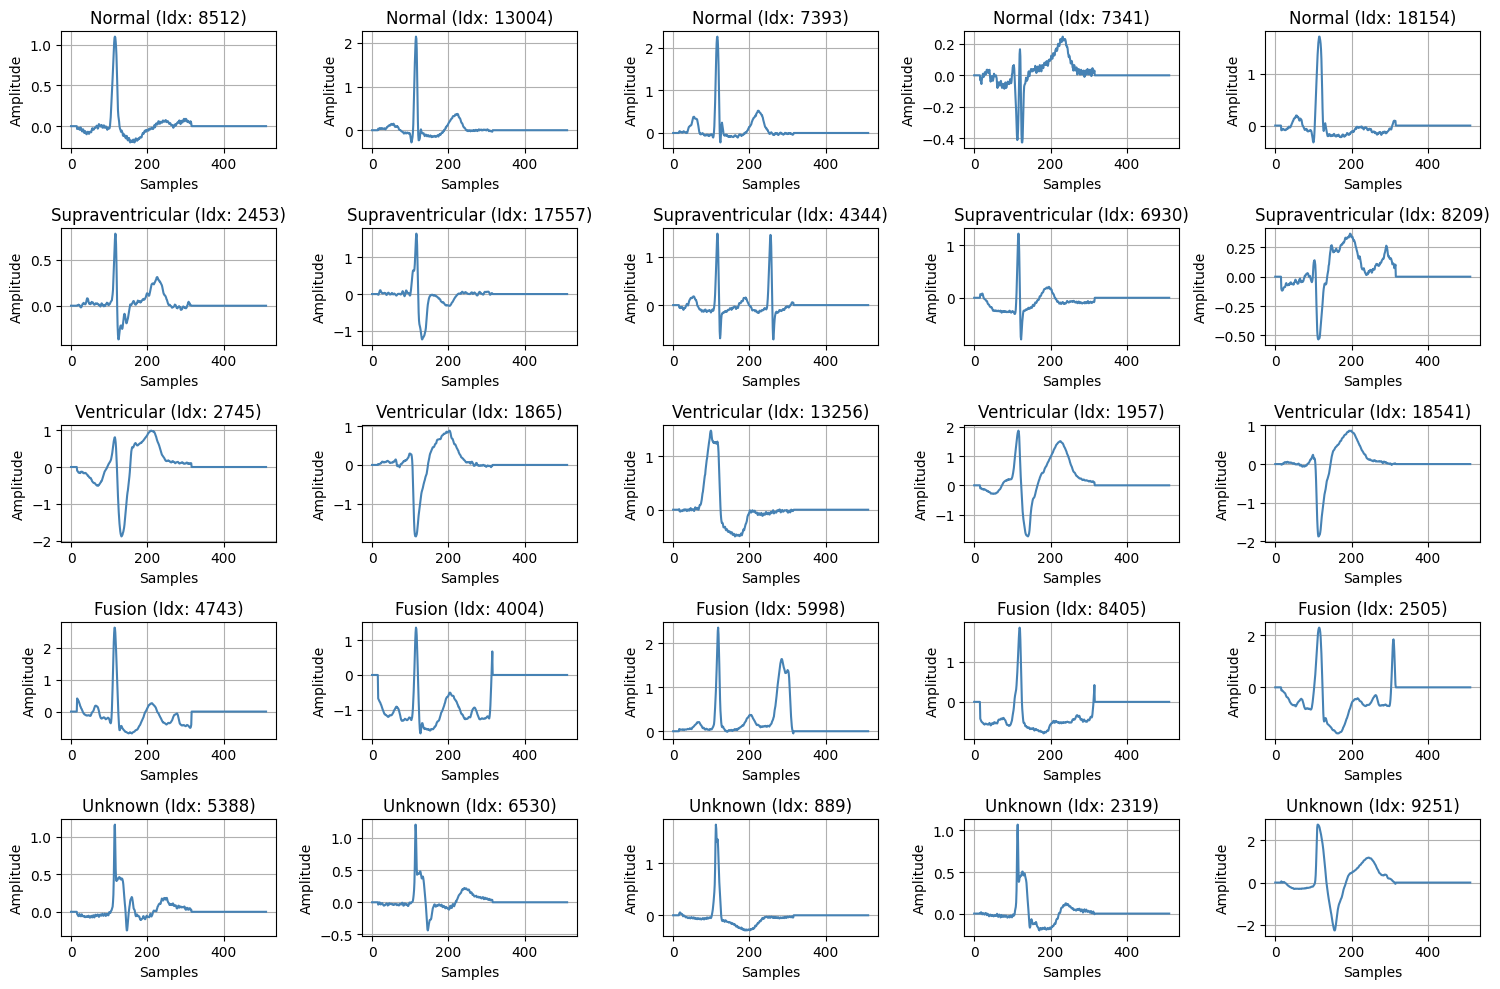

In [150]:
import matplotlib.pyplot as plt
import numpy as np

# 5-Class 라벨 정의
label_names = ["Normal", "Supraventricular", "Ventricular", "Fusion", "Unknown"]

def visualize_ecg_samples(y_test, y_test_label, num_samples=5):
    """
    y_test에 대응하는 ECG 비트를 라벨에 따라 시각화합니다.
    
    Parameters:
    y_test: 테스트 데이터셋 (ECG 비트, shape: (num_samples, 512, 1))
    y_test_label: 테스트 데이터셋의 라벨 (5-Class)
    num_samples: 클래스별로 시각화할 샘플 수 (기본값: 5)
    """
    plt.figure(figsize=(15, 10))
    
    for class_id in range(5):
        # 해당 클래스에 속하는 인덱스 선택
        class_indices = np.where(y_test_label == class_id)[0]
        if len(class_indices) == 0:
            continue  # 해당 클래스가 없으면 건너뜀
        
        # 랜덤하게 num_samples만큼 선택
        selected_indices = np.random.choice(class_indices, size=min(num_samples, len(class_indices)), replace=False)
        
        for i, idx in enumerate(selected_indices):
            plt.subplot(5, num_samples, class_id * num_samples + i + 1)
            plt.plot(y_test[idx].squeeze(), color='steelblue')
            plt.title(f"{label_names[class_id]} (Idx: {idx})")
            plt.xlabel("Samples")
            plt.ylabel("Amplitude")
            plt.grid(True)
            
    plt.tight_layout()
    plt.show()

# 시각화 실행
visualize_ecg_samples(y_test, y_test_label, num_samples=5)


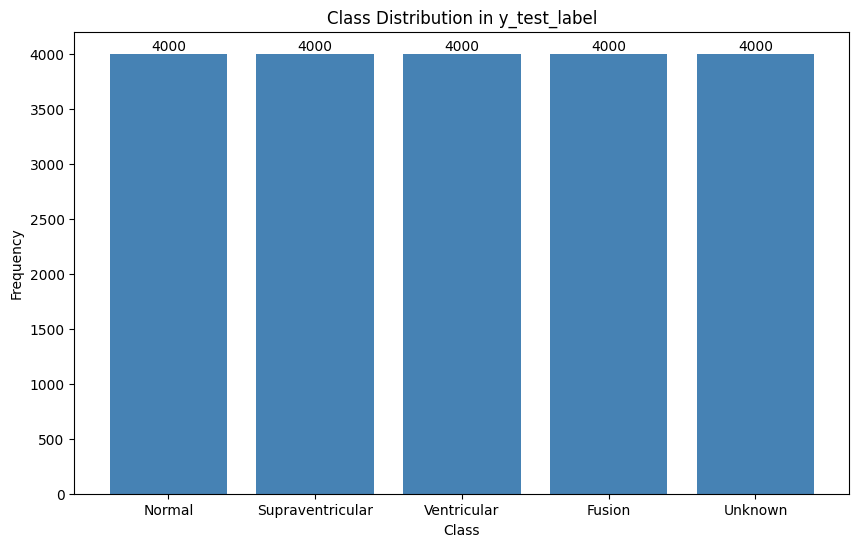

In [151]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def plot_class_distribution(y_test_label):
    """
    y_test_label에서 5-Class 분포를 시각화합니다.
    
    Parameters:
    y_test_label: 테스트 데이터셋의 라벨 (5-Class)
    """
    # 클래스별 개수 계산
    class_counts = Counter(y_test_label)
    
    # 클래스 이름 정의
    label_names = ["Normal", "Supraventricular", "Ventricular", "Fusion", "Unknown"]
    
    # 클래스별 개수 순서에 맞게 추출
    counts = [class_counts[i] for i in range(5)]
    
    # 분포 시각화
    plt.figure(figsize=(10, 6))
    plt.bar(label_names, counts, color='steelblue')
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title("Class Distribution in y_test_label")
    
    # 각 막대 위에 개수 표시
    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)
    
    plt.show()

# 시각화 실행
plot_class_distribution(y_test_label)


In [152]:
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras import losses
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
import tensorflow as tf 
from datetime import datetime
from deepFilter.dl_models import *
import os
import shap
current_date = datetime.now().strftime('%m%d')
# Custom loss SSD
import tensorflow as tf

def ssd_loss(y_true, y_pred):
    return tf.reduce_sum(tf.square(y_pred - y_true), axis=-2)

# Combined loss SSD + MSE
def combined_ssd_mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred), axis=-2) * 500 + tf.reduce_sum(tf.square(y_true - y_pred), axis=-2)

def combined_ssd_mad_loss(y_true, y_pred):
    return tf.reduce_max(tf.square(y_true - y_pred), axis=-2) * 50 + tf.reduce_sum(tf.square(y_true - y_pred), axis=-2)

# Custom loss SAD
def sad_loss(y_true, y_pred):
    return tf.reduce_sum(tf.sqrt(tf.square(y_pred - y_true)), axis=-2)

# Custom loss MAD
def mad_loss(y_true, y_pred):
    return tf.reduce_max(tf.square(y_pred - y_true), axis=-2)

def train_dl(Dataset, experiment):

    print('Deep Learning pipeline: Training the model for exp ' + str(experiment))
    
    if experiment in ['Transformer_COMBDAE']:
        [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y, y_train_label, y_test_label] = Dataset

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=1)
        F_train_x, F_val_x, F_train_y, F_val_y = train_test_split(F_train_x, F_train_y, test_size=0.3, shuffle=True, random_state=1)
    else:
        [X_train, y_train, X_test, y_test, y_train_label, y_test_label] = Dataset
        # 일반 모델들을 위한 데이터 분할
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=1)
            
    # ==================
    # LOAD THE DL MODEL
    # ==================
    if experiment == 'FCN-DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'

    if experiment == 'DeepFilter':
        # Inception-like linear and non linear dilated
        model = deep_filter_model_I_LANL_dilated()
        model_label = 'DeepFilter'
        
    if experiment == 'AttentionSkipDAE':
        # Inception-like linear and non linear dilated
        model = AttentionSkipDAE()
        model_label = 'AttentionSkipDAE'
    
    if experiment == 'Transformer_DAE':
        # Transformer_FDAE
        model = Transformer_DAE()
        model_label = 'Transformer_DAE'
        
    if experiment == 'Transformer_COMBDAE':
        model = Transformer_COMBDAE()
        model_label = 'Transformer_COMBDAE'
        
    print('\n ' + model_label + '\n ')

    model.summary()
    epochs = int(1e5)  # 100000
    batch_size = 128  #128

    lr = 1e-3
    # lr = 1e-4
    minimum_lr = 1e-10

    # Loss function selection according to method implementation
    if experiment == 'DRNN':
        criterion = keras.losses.mean_squared_error

    elif experiment == 'FCN-DAE':
        criterion = ssd_loss

    else:
        criterion = combined_ssd_mad_loss

    model.compile(loss=criterion,
                  optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=[losses.mean_squared_error, losses.mean_absolute_error, ssd_loss, mad_loss])

    # Keras Callbacks

    # 체크포인트 파일 경로 설정
    model_dir = current_date
    model_filepath = os.path.join(model_dir, f"{model_label}_weights.best.weights.h5")

    # 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    checkpoint = ModelCheckpoint(model_filepath,
                                 monitor="val_loss",
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',  # on acc has to go max
                                 save_weights_only=True)

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                factor=0.5,           # 학습률 감소 비율은 그대로 유지
                                min_delta=0.005,      # min_delta를 0.05에서 0.001로 줄여 작은 개선도 감지
                                mode='min',           # val_loss 최소화를 목표로 함
                                patience=10,          # patience를 2에서 10으로 늘려 학습률 감소 시점을 늦춤
                                verbose=1)

    early_stop = EarlyStopping(monitor="val_loss",  
                            min_delta=0.001,       # 개선 판단을 위한 최소 변화량
                            mode='min',             # val_loss 최소화를 목표로 함
                            patience=30,            # patience를 50에서 20으로 줄여 더 빠른 조기 종료
                            verbose=1)
    # early_stop = EarlyStopping(monitor="val_loss",  
    #                         min_delta=0.001,       # 개선 판단을 위한 최소 변화량
    #                         mode='min',             # val_loss 최소화를 목표로 함
    #                         patience=50,            # patience를 50에서 20으로 줄여 더 빠른 조기 종료
    #                         verbose=1)
    tb_log_dir = './runs_' + current_date +'/' + model_label
    # 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(tb_log_dir):
        os.makedirs(tb_log_dir)
    tboard = TensorBoard(log_dir=tb_log_dir, histogram_freq=0,
                         write_graph=False, 
                         write_images=False, embeddings_freq=0,
                        #  embeddings_layer_names=None,
                         embeddings_metadata=None)

    # To run the tensor board
    # tensorboard --logdir=./runs_new

    if experiment in ['Transformer_COMBDAE']:
        model.fit(x=[X_train, F_train_x], y=y_train,
                validation_data=([X_val, F_val_x], y_val),
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                callbacks=[early_stop,
                            reduce_lr,
                            checkpoint,
                            tboard])
    else:
        model.fit(x=X_train, y=y_train,
                validation_data=(X_val, y_val),
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                callbacks=[early_stop,
                            reduce_lr,
                            checkpoint,
                            tboard])
    K.clear_session()



def test_dl(Dataset, experiment):

    print('Deep Learning pipeline: Testing the model')
# 여기선 x_test, y_test만 사용됨
    if experiment in ['Transformer_COMBDAE']:
        [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y, y_train_label, y_test_label] = Dataset

    else:
        [X_train, y_train, X_test, y_test, y_train_label, y_test_label] = Dataset
        # 일반 모델들을 위한 데이터 분할
    batch_size = 128

    # ==================
    # LOAD THE DL MODEL
    # ==================
    if experiment == 'FCN-DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'

    if experiment == 'DeepFilter':
        # Inception-like linear and non linear dilated
        model = deep_filter_model_I_LANL_dilated()
        model_label = 'DeepFilter'

    if experiment == 'AttentionSkipDAE':
        # Inception-like linear and non linear dilated
        model = AttentionSkipDAE()
        model_label = 'AttentionSkipDAE'
        
    if experiment == 'Transformer_DAE':
        model = Transformer_DAE()
        model_label = 'Transformer_DAE'
        
    if experiment == 'Transformer_COMBDAE':
        model = Transformer_COMBDAE()
        model_label = 'Transformer_COMBDAE'
            
    print('\n ' + model_label + '\n ')

    model.summary()

    # Loss function selection according to method implementation
    if experiment == 'DRNN':
        criterion = 'mse'

    elif experiment == 'FCN-DAE':
        criterion = ssd_loss

    else:
        criterion = combined_ssd_mad_loss
        # criterion = combined_huber_freq_loss

    model.compile(loss=criterion,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  metrics=[losses.mean_squared_error, losses.mean_absolute_error, ssd_loss, mad_loss])
    model_dir = current_date
    model_filepath = os.path.join(model_dir, model_label + '_weights.best.weights.h5')

    # 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    # load weights
    model.load_weights(model_filepath)
    
    if experiment in ['Transformer_COMBDAE']:
        # Test score
        y_pred = model.predict([X_test, F_test_x], batch_size=batch_size, verbose=1)

    else:
        # Test score
        y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
        
    K.clear_session()

    return [X_test, y_test, y_pred]

In [153]:
# from deepFilter.dl_pipeline import train_dl, test_dl
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np
import os

# dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
dl_experiments = ['Transformer_COMBDAE']
train_time_list = []
test_time_list = []
    
    # Get the current date in 'MMDD' format
current_date = datetime.now().strftime('%m%d')
for experiment in dl_experiments:
    # 데이터 준비 단계
    if experiment in ['Transformer_COMBDAE']:
        Dataset = Data_Preparation_with_Fourier_mitdb(samples=512, fs=360)
        X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y, y_train_label, y_test_label = Dataset         
    else:
        Dataset = Data_Preparation_with_mitdb(samples=512)
        X_train, y_train, X_test, y_test, y_train_label, y_test_label = Dataset
    
    # 훈련 시간 측정 및 모델 훈련
    start_train = datetime.now()
    train_dl(Dataset, experiment)
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)
    # 테스트 시간 측정 및 모델 테스트
    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, experiment)
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)
    # 시각화 및 결과 저장
    save_dir = current_date 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    test_results = [X_test, y_test, y_pred]
    with open(os.path.join(save_dir,  'test_results_' + experiment + '.pkl'), 'wb') as output:
        pickle.dump(test_results, output)
    print('Results from experiment ' + experiment + ' saved')

Preparing the MITDB dataset with labels...
[INFO] Loaded CombinedNoise with 2 channels
[INFO] Loaded MITDatabase with 100 signals
[INFO] beats_train: 80000, beats_test: 20000
[INFO] Adding noise to train and test sets
[INFO] Final shapes -> X_train: (80000, 512, 1), y_train: (80000, 512, 1), X_test: (20000, 512, 1), y_test: (20000, 512, 1)
[INFO] Labels -> y_train_label: (80000,), y_test_label: (20000,)
Dataset ready to use.
Deep Learning pipeline: Training the model for exp Transformer_COMBDAE


/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 Transformer_COMBDAE
 


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_133 (Conv1D) │ (None, 256, 16)   │        224 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_139 (Conv1D) │ (None, 256, 16)   │        224 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_133      │ (None, 256, 16)   │          0 │ conv1d_133[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_134 (Conv1D) │ (None, 256, 16)   │        224 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_136      │ (None, 256, 16)   │          0 │ conv1d_139[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_140 (Conv1D) │ (None, 256, 16)   │        224 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_16         │ (None, 256, 16)   │          0 │ activation_133[0… │
│ (Multiply)          │                   │            │ conv1d_134[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_19         │ (None, 256, 16)   │          0 │ activation_136[0… │
│ (Multiply)          │                   │            │ conv1d_140[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ multiply_16[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ multiply_19[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_135 (Conv1D) │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_141 (Conv1D) │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_134      │ (None, 128, 32)   │          0 │ conv1d_135[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_136 (Conv1D) │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_137      │ (None, 128, 32)   │          0 │ conv1d_141[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_142 (Conv1D) │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_17         │ (None, 128, 32)   │          0 │ activation_134[0… │
│ (Multiply)          │                   │            │ conv1d_136[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,454,145 (9.36 MB)

 Trainable params: 2,453,473 (9.36 MB)

 Non-trainable params: 672 (2.62 KB)

Epoch 1/100000
435/438 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 146.7415 - mad_loss: 1.6352 - mean_absolute_error: 0.2045 - mean_squared_error: 0.1269 - ssd_loss: 64.9804

2025-02-14 06:10:21.732062: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24_0', 52 bytes spill stores, 52 bytes spill loads

2025-02-14 06:10:22.423561: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27_0', 2064 bytes spill stores, 2832 bytes spill loads



438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 146.2699 - mad_loss: 1.6298 - mean_absolute_error: 0.2041 - mean_squared_error: 0.1265 - ssd_loss: 64.7781
Epoch 1: val_loss improved from inf to 49.66492, saving model to 0214/Transformer_COMBDAE_weights.best.weights.h5
438/438 ━━━━━━━━━━━━━━━━━━━━ 32s 36ms/step - loss: 146.1140 - mad_loss: 1.6281 - mean_absolute_error: 0.2040 - mean_squared_error: 0.1264 - ssd_loss: 64.7113 - val_loss: 49.6649 - val_mad_loss: 0.5484 - val_mean_absolute_error: 0.1196 - val_mean_squared_error: 0.0434 - val_ssd_loss: 22.2425 - learning_rate: 0.0010
Epoch 2/100000
436/438 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 39.4949 - mad_loss: 0.4378 - mean_absolute_error: 0.1090 - mean_squared_error: 0.0344 - ssd_loss: 17.6040
Epoch 2: val_loss improved from 49.66492 to 36.74327, saving model to 0214/Transformer_COMBDAE_weights.best.weights.h5
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 39.4793 - mad_loss: 0.4376 - mean_absolute_error: 0.1089 - mean_squared_e

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 16)   │          0 │ conv1d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 16)   │          0 │ conv1d_6[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 16)   │          0 │ activation[0][0], │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 256, 16)   │          0 │ activation_3[0][… │
│ (Multiply)          │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 16)   │         64 │ multiply[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ multiply_3[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 32)   │          0 │ conv1d_2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 32)   │          0 │ conv1d_8[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128, 32)   │          0 │ activation_1[0][… │
│ (Multiply)          │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,454,145 (9.36 MB)

 Trainable params: 2,453,473 (9.36 MB)

 Non-trainable params: 672 (2.62 KB)

/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 230 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Results from experiment Transformer_COMBDAE saved


In [159]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']

In [160]:
with open('0214/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0214/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results DeepFilter
with open('0214/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0214/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0214/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0214/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            

print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

SSD_all = [
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+-----------------+---------------+-----------------+---------------+----------------+
|        Model        |       SSD       |      MAD      |       PRD       |    COS_SIM    |      SNR       |
+---------------------+-----------------+---------------+-----------------+---------------+----------------+
|         DRNN        |  5.281 (14.813) | 0.339 (0.245) | 33.218 (23.267) | 0.944 (0.075) | 11.519 (4.307) |
|       FCN-DAE       | 18.930 (41.364) | 0.612 (0.416) | 70.315 (45.164) | 0.827 (0.163) | 5.961 (3.642)  |
|      DeepFilter     | 17.970 (42.286) | 0.476 (0.339) | 62.918 (42.821) | 0.849 (0.135) | 6.715 (3.611)  |
|   AttentionSkipDAE  |  5.708 (16.633) | 0.305 (0.222) | 33.777 (21.852) | 0.943 (0.071) | 11.129 (4.057) |
|   Transformer_DAE   |  3.767 (12.794) | 0.245 (0.190) | 26.141 (17.513) | 0.964 (0.051) | 13.259 (4.243) |
| Transformer_COMBDAE |  4.602 (12.376) | 0.277 (0.207) | 24.330 (17.320) | 0.966 (0.053) | 14.019 (5.

In [163]:
[X_test, y_test, y_pred] = test_Transformer_COMBDAE

In [165]:
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, UpSampling1D, add, multiply, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# ------------------------
# 데이터 준비 및 train/test 분할
# ------------------------
# 데이터 준비 (y_test와 y_test_label 사용)
X = X_test.squeeze()  # (21890, 512, 1) → (21890, 512)
y = y_test_label  # 5-Class 라벨 (0~4)

# 80:20 비율로 Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)
X_train = np.expand_dims(X_train, axis=2)  # (samples, 512) → (samples, 512, 1)
X_val = np.expand_dims(X_val, axis=2)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# ------------------------
# RTA-CNN 모델 정의
# ------------------------
def conv_block(in_x, nb_filter, kernel_size):
    x = Conv1D(nb_filter, kernel_size, padding='same')(in_x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def attention_branch(in_x, nb_filter, kernel_size):
    x1 = conv_block(in_x, nb_filter, kernel_size)
    x = MaxPooling1D(2)(x1)
    x = conv_block(x, nb_filter, kernel_size)
    x = UpSampling1D(size=2)(x)
    x2 = conv_block(x, nb_filter, kernel_size)
    
    # 수정된 조건문: x1.shape과 x2.shape 비교
    if x1.shape != x2.shape:
        x2 = tf.keras.layers.ZeroPadding1D(1)(x2)
        x2 = tf.keras.layers.Cropping1D((1, 0))(x2)
    
    x = add([x1, x2])
    x = conv_block(x, nb_filter, kernel_size)
    x = Conv1D(nb_filter, 1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    return x


def RTA_block(in_x, nb_filter, kernel_size):
    x1 = conv_block(in_x, nb_filter, kernel_size)
    x2 = conv_block(x1, nb_filter, kernel_size)
    attention_map = attention_branch(x1, nb_filter, kernel_size)
    x = multiply([x2, attention_map])
    x = add([x, x1])
    out = conv_block(x, nb_filter, kernel_size)
    return out

def build_RTA_CNN(input_shape=(512, 1), num_classes=5):
    inputs = Input(input_shape)
    x = RTA_block(inputs, 16, 32)
    x = MaxPooling1D(4)(x)
    x = RTA_block(x, 32, 16)
    x = MaxPooling1D(4)(x)
    x = RTA_block(x, 64, 9)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.6)(x)
    x = RTA_block(x, 128, 3)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    x = Dropout(0.7)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.7)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 모델 생성 및 요약 출력
model = build_RTA_CNN(input_shape=(512, 1), num_classes=5)
model.summary()

# ------------------------
# 모델 학습 및 평가
# ------------------------
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# 예측 및 성능 평가
y_pred_val = np.argmax(model.predict(X_val), axis=1)
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))
print("Accuracy:", accuracy_score(y_val, y_pred_val))


X_train shape: (16000, 512, 1), y_train shape: (16000,)
X_val shape: (4000, 512, 1), y_val shape: (4000,)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 512, 16)   │        528 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_64[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_64       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 512, 16)   │      8,208 │ activation_64[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_66[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_66       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 256, 16)   │          0 │ activation_66[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 256, 16)   │      8,208 │ max_pooling1d_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_67[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_67       │ (None, 256, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_8     │ (None, 512, 16)   │          0 │ activation_67[0]… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 512, 16)   │      8,208 │ up_sampling1d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_68[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_68       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 512, 16)   │          0 │ activation_66[0]… │
│                     │                   │            │ activation_68[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 512, 16)   │      8,208 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_69[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 849,629 (3.24 MB)

 Trainable params: 845,789 (3.23 MB)

 Non-trainable params: 3,840 (15.00 KB)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.2043 - loss: 1.9895 - val_accuracy: 0.1935 - val_loss: 1.6094
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2175 - loss: 1.6117 - val_accuracy: 0.3460 - val_loss: 1.4830
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3260 - loss: 1.4998 - val_accuracy: 0.3902 - val_loss: 1.3319
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4214 - loss: 1.3156 - val_accuracy: 0.5562 - val_loss: 1.1450
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5916 - loss: 1.0326 - val_accuracy: 0.7188 - val_loss: 0.7727
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6952 - loss: 0.8303 - val_accuracy: 0.7573 - val_loss: 0.6691
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7323 - loss: 0.7574 - val_accuracy: 0.7613 - val_loss: 0.6228
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7759 - loss: 0.6353 - val_accuracy: 0

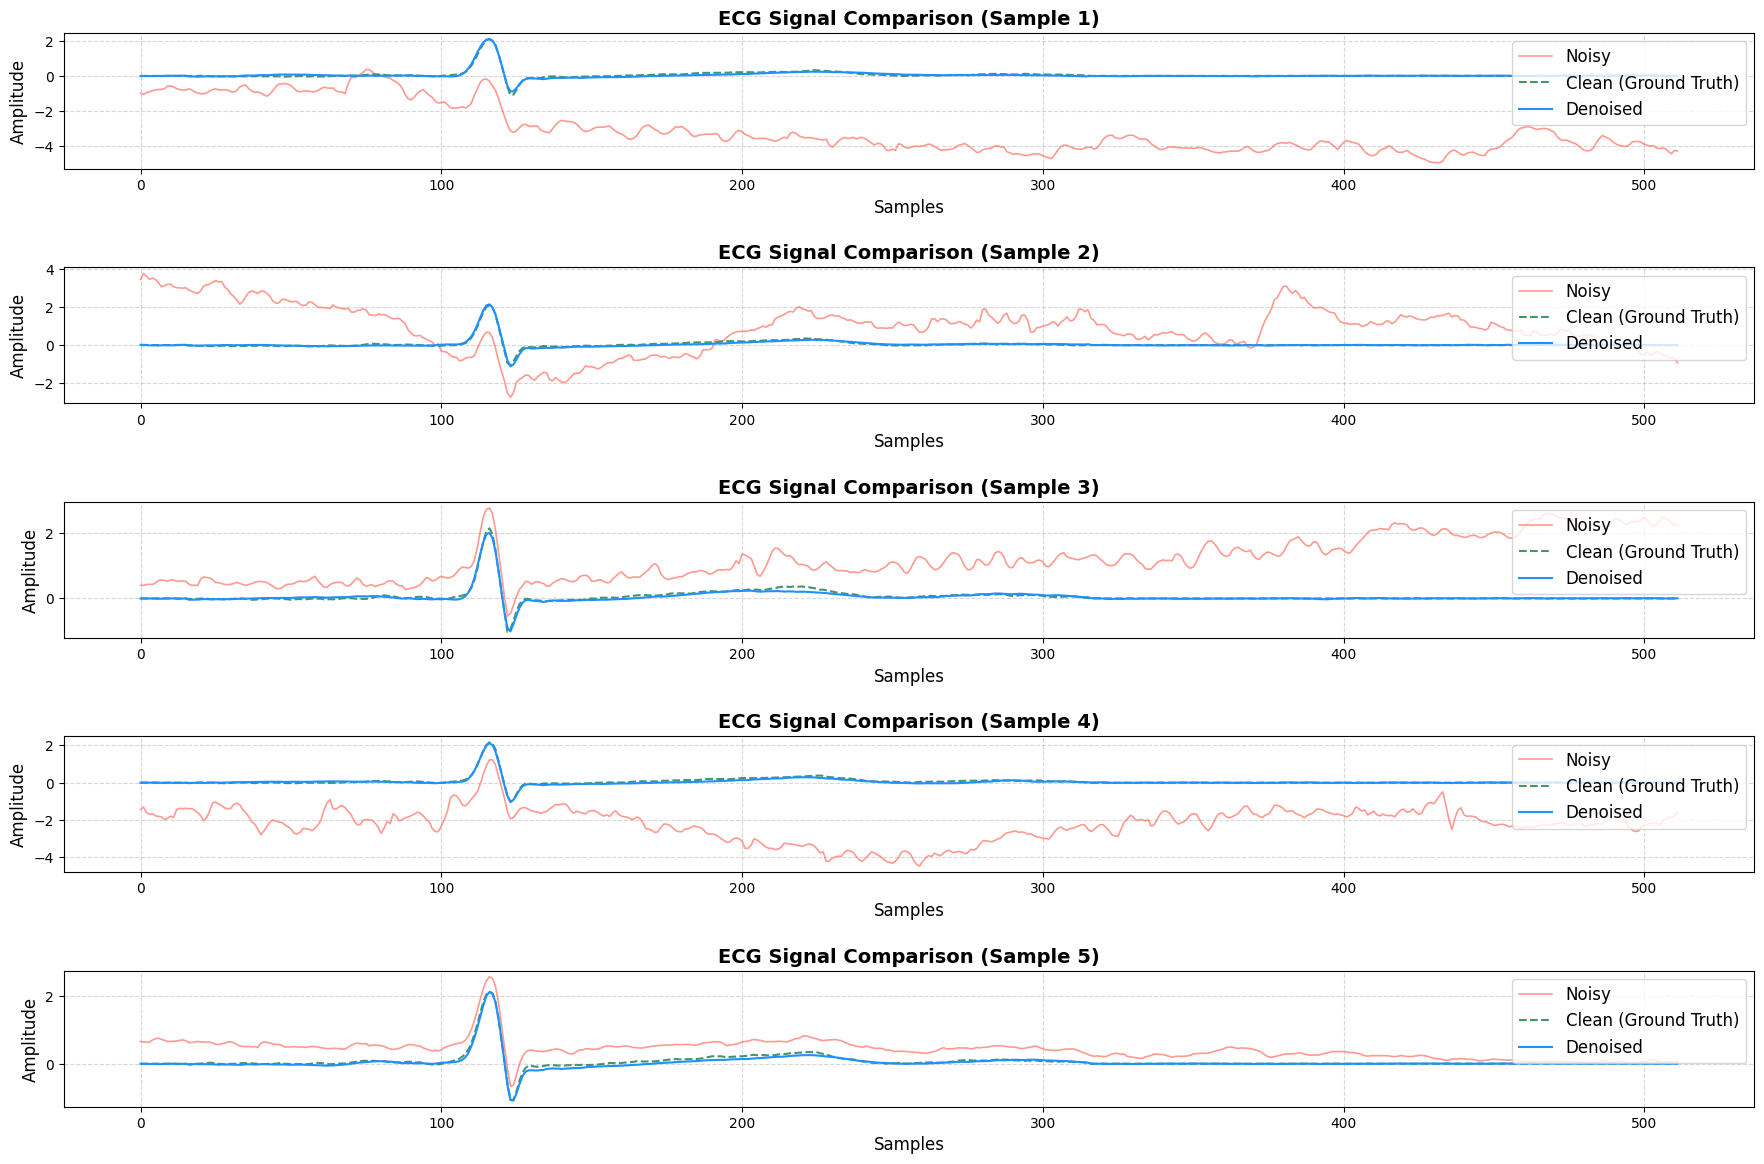

In [97]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ecg_comparison(X_test, y_test, y_pred, num_samples=5):
    """
    Noisy, Clean, and Denoised ECG 신호를 보기 좋게 시각화합니다.
    
    Parameters:
    X_test: Noisy 신호 (입력)
    y_test: Clean 신호 (Ground Truth)
    y_pred: Denoised 신호 (출력)
    num_samples: 시각화할 샘플 수 (기본값: 5)
    """
    plt.figure(figsize=(18, 12))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        
        # Noisy Signal
        plt.plot(X_test[i].squeeze(), color='#FF6F61', linewidth=1.2, alpha=0.7, label='Noisy')
        
        # Clean Signal (Ground Truth)
        plt.plot(y_test[i].squeeze(), color='#2E8B57', linestyle='--', linewidth=1.5, alpha=0.9, label='Clean (Ground Truth)')
        
        # Denoised Signal
        plt.plot(y_pred[i].squeeze(), color='#1E90FF', linestyle='-', linewidth=1.5, label='Denoised')
        
        # Plot Customization
        plt.title(f"ECG Signal Comparison (Sample {i + 1})", fontsize=14, fontweight='bold')
        plt.xlabel("Samples", fontsize=12)
        plt.ylabel("Amplitude", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(loc='upper right', fontsize=12)
        
    plt.tight_layout(pad=2.0)
    plt.show()

# 시각화 실행
plot_ecg_comparison(X_test, y_test, y_pred, num_samples=5)


In [96]:
def calculate_snr(signal, noise):
    """
    SNR 계산 (dB 단위)
    Parameters:
    signal: 원본 신호
    noise: 노이즈 신호
    
    Returns:
    SNR 값 (dB)
    """
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# SNR 계산 및 개선율 출력
snr_input = calculate_snr(y_test, X_test - y_test)
snr_output = calculate_snr(y_test, y_pred - y_test)
snr_improvement = snr_output - snr_input

print(f"SNR 입력: {snr_input:.2f} dB")
print(f"SNR 출력: {snr_output:.2f} dB")
print(f"SNR 개선: {snr_improvement:.2f} dB")


SNR 입력: -13.08 dB
SNR 출력: 8.66 dB
SNR 개선: 21.74 dB


# qtdb 

In [24]:
import numpy as np
from scipy.fft import fft
import glob
from scipy.signal import resample_poly
import wfdb
import math
import _pickle as pickle


def make_fourier(inputs, n, fs):
    """
    주파수 도메인 정보 추출 및 time-domain과 같은 shape으로 만듦.
    
    Parameters:
    inputs: 입력 신호 (원본 신호, 2D 배열 - (배치 크기, 샘플 수))
    n: FFT 샘플 수
    fs: 샘플링 주파수 (예: 360 Hz)
    
    Returns:
    주파수 도메인에서 얻은 신호 (FFT), time-domain과 동일한 크기
    """
    T = n / fs
    k = np.arange(n)
    freq = k / T
    freq = freq[range(int(n / 2))]

    signal_list = []
    for i in range(inputs.shape[0]):
        y = inputs[i, :]
        Y = fft(y) / n  # FFT 수행 후 정규화
        Y = np.abs(Y[range(int(n / 2))])
        # Magnitude 값을 두 배로 늘려 time-domain과 동일한 shape으로 맞춤 (512)
        Y_full = np.hstack([Y, Y])  # Duplicate to match time-domain size
        signal_list.append(Y_full)

    return np.asarray(signal_list)

def Data_Preparation_with_Fourier(samples, fs=360):
    print('Getting the Data ready ...')

    # Set random seed for reproducibility
    seed = 1234
    np.random.seed(seed=seed)

    # Load QT Database
    with open('data/QTDatabase.pkl', 'rb') as input:
        qtdb = pickle.load(input)
    # Load MIT Database

        
    print(f"[INFO] Loaded QTDatabase with {len(qtdb.keys())} signals")
    # Load combined noise
    with open('data/CombinedNoise.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    # with open('data/StaticNoise.pkl', 'rb') as input:
    #     combined_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

    #####################################
    # Data split
    #####################################
    test_set = ['sel123', 'sel233', 'sel302', 'sel307', 'sel820', 'sel853', 
                'sel16420', 'sel16795', 'sele0106', 'sele0121', 'sel32', 'sel49', 
                'sel14046', 'sel15814']

    beats_train = []
    beats_test = []
    fourier_train_x = []
    fourier_test_x = []
    fourier_train_y = []
    fourier_test_y = []
    valid_train_indices = []  # To keep track of valid indices in training data
    valid_test_indices = []   # To keep track of valid indices in test data
    # 노이즈 인덱스 저장 리스트
    noise_indices_train = []
    noise_indices_test = []
    sn_train = []
    sn_test = []
    
    skip_beats = 0
    qtdb_keys = list(qtdb.keys())

    print(f"[INFO] Processing QTDatabase, {len(qtdb.keys())} signals to process.")
    # MIT-BIH Arrhythmia Database 레코드 식별
    # mitbih_records = ['sel100', 'sel102', 'sel103', 'sel104', 'sel114', 'sel116', 'sel117', 'sel123', 'sel213', 'sel221', 'sel223', 'sel230', 'sel231', 'sel232', 'sel233']
    # mitbih_beats = []  # MIT-BIH 레코드에서 추출된 비트를 저장할 리스트
    for signal_name in qtdb_keys:
        for b_idx, b in enumerate(qtdb[signal_name]):
            b_np = np.zeros(samples)
            b_sq = np.array(b)

            init_padding = 16
            if b_sq.shape[0] > (samples - init_padding):
                skip_beats += 1
                continue

            b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

            # Fourier 변환 적용 (주파수 도메인 정보, time-domain과 동일한 shape으로)
            fourier_transformed_y = make_fourier(b_np.reshape(1, -1), samples, fs)
            # if signal_name in mitbih_records:
            #     mitbih_beats.append(b_np)  # MIT-BIH 레코드에 해당하는 비트를 따로 저장
            if signal_name in test_set:
                beats_test.append(b_np)
                fourier_test_y.append(fourier_transformed_y[0])  # Append the single batch
                valid_test_indices.append(len(beats_test) - 1)  # Track valid test beat index
            else:
                beats_train.append(b_np)
                fourier_train_y.append(fourier_transformed_y[0])  # Append the single batch
                valid_train_indices.append(len(beats_train) - 1)  # Track valid train beat index

        print(f"[DEBUG] Processed signal {signal_name}, total beats in train: {len(beats_train)}, total beats in test: {len(beats_test)}")

    #####################################
    # Adding noise to train and test sets
    #####################################
    print(f"[INFO] Adding noise to train and test sets")
    # Random scaling factor for train and test
    rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
    noise_index = 0
    # To ensure equal selection of channels
    # Adding noise to train
    for beat_idx, beat in enumerate(beats_train):
        # if np.random.rand() < channel_ratio:
        if (beat_idx // 10) % 2 == 0:
            selected_channel = beat_idx % 2  # 0과 1을 번갈아 선택
        else:
            selected_channel = (beat_idx + 1) % 2  # 반대 순서로 선택

        # 노이즈 조합도 순차적으로 선택, 주기적으로 변화를 줌 (매 8회 주기)
        noise_combination_idx = 0  # 1부터 7까지 순차적으로 선택, 근데 0번째것만 하기로 함함
        noise = combined_noise[selected_channel][:, noise_combination_idx]
        noise_segment = noise[noise_index:noise_index + samples]
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        if noise_max_value == 0:
            Ase = 1  # 기본값 설정
        else:
            Ase = noise_max_value / beat_max_value
        alpha = rnd_train[beat_idx] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_train.append(signal_noise)
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)  # X에 대한 Fourier 변환
        fourier_train_x.append(fourier_transformed_x[0])  # Append the single batch
        noise_indices_train.append(noise_combination_idx)  # 노이즈 인덱스 저장
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    # Adding noise to test
    noise_index = 0
    rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
    np.save('rnd_test.npy', rnd_test)
    print('rnd_test shape: ' + str(rnd_test.shape))
        
    for beat_idx, beat in enumerate(beats_test):
        # if np.random.rand() < channel_ratio:
        if (beat_idx // 10) % 2 == 0:
            selected_channel = beat_idx % 2  # 0과 1을 번갈아 선택
        else:
            selected_channel = (beat_idx + 1) % 2  # 반대 순서로 선택
        # 노이즈 조합도 순차적으로 선택, 주기적으로 변화를 줌 (매 8회 주기)
        noise_combination_idx = 0  # 1부터 7까지 순차적으로 선택
        noise = combined_noise[selected_channel][:, noise_combination_idx]
        noise_segment = noise[noise_index:noise_index + samples]
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        if noise_max_value == 0:
            Ase = 1  # 기본값 설정
            print('noise_max_value is 0')
        else:
            Ase = noise_max_value / beat_max_value
        alpha = rnd_test[beat_idx] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_test.append(signal_noise)
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)  # X에 대한 Fourier 변환
        fourier_test_x.append(fourier_transformed_x[0])  # Append the single batch
        noise_indices_test.append(noise_combination_idx)  # 노이즈 인덱스 저장
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0


    X_train = np.array(sn_train)[valid_train_indices]  # Match noisy and original beats
    X_test = np.array(sn_test)[valid_test_indices]

    y_train = np.array(beats_train)[valid_train_indices]  # Match noisy and original beats
    y_test = np.array(beats_test)[valid_test_indices]

    # Fourier 정보도 포함된 주파수 도메인 데이터셋 생성
    F_train_x = np.array(fourier_train_x)[valid_train_indices]
    F_test_x = np.array(fourier_test_x)[valid_test_indices]
    F_train_y = np.array(fourier_train_y)[valid_train_indices]
    F_test_y = np.array(fourier_test_y)[valid_test_indices]

    # Shape을 time-domain과 동일하게 확장
    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=2)

    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    F_train_x = np.expand_dims(F_train_x, axis=2)
    F_train_y = np.expand_dims(F_train_y, axis=2)
    
    F_test_x = np.expand_dims(F_test_x, axis=2)
    F_test_y = np.expand_dims(F_test_y, axis=2)

    Dataset = [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y]
    
    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"[INFO] Fourier shapes -> F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}, F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")
    print('Dataset ready to use.')

    return Dataset, valid_train_indices, valid_test_indices, noise_indices_train, noise_indices_test

In [25]:
# Unpack the dataset
Dataset, valid_train_indices, valid_test_indices, noise_indices_train, noise_indices_test = Data_Preparation_with_Fourier(samples=512, fs=360)
X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y = Dataset

# Print dataset shapes for confirmation
print(f"Time domain train shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Frequency domain train shapes: F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}")
print(f"Time domain test shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Frequency domain test shapes: F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")

Getting the Data ready ...
[INFO] Loaded QTDatabase with 105 signals
[INFO] Loaded CombinedNoise with 2 channels
[INFO] Processing QTDatabase, 105 signals to process.
[DEBUG] Processed signal sele0122, total beats in train: 1412, total beats in test: 0
[DEBUG] Processed signal sele0107, total beats in train: 2220, total beats in test: 0
[DEBUG] Processed signal sel16272, total beats in train: 3058, total beats in test: 0
[DEBUG] Processed signal sele0604, total beats in train: 4082, total beats in test: 0
[DEBUG] Processed signal sel104, total beats in train: 4264, total beats in test: 0
[DEBUG] Processed signal sel232, total beats in train: 4883, total beats in test: 0
[DEBUG] Processed signal sel16539, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sel33, total beats in train: 5784, total beats in test: 0
[DEBUG] Processed signal sele0606, total beats in train: 7112, total beats in test: 0
[DEBUG] Processed signal sel32, total beats in train: 7112, total 

In [21]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pickle

# # Load QT Database
# with open('data/QTDatabase.pkl', 'rb') as input:
#     qtdb = pickle.load(input)

# # Print basic info
# print(f"[INFO] Loaded QTDatabase with {len(qtdb.keys())} signals")

# # Get statistics: Number of beats per signal and beat length distribution
# signal_lengths_qt = [len(beats) for beats in qtdb.values()]
# beat_lengths_qt = [len(beat) for beats in qtdb.values() for beat in beats]

# len(beat_lengths_qt)
# # Plot the distribution of number of beats per signal
# plt.figure(figsize=(14, 5))
# plt.subplot(1, 2, 1)
# plt.hist(signal_lengths_qt, bins=20, color='royalblue')
# plt.title('QTDatabase: Number of Beats per Signal')
# plt.xlabel('Number of Beats')
# plt.ylabel('Frequency')

# # Plot the distribution of beat lengths
# plt.subplot(1, 2, 2)
# plt.hist(beat_lengths_qt, bins=30, color='coral')
# plt.title('QTDatabase: Distribution of Beat Lengths')
# plt.xlabel('Beat Length (Samples)')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.show()

# # Visualize one sample beat from the first signal in QTDatabase
# first_signal_qt = list(qtdb.keys())[0]
# sample_beat_qt = qtdb[first_signal_qt][0]

# plt.figure(figsize=(10, 4))
# plt.plot(sample_beat_qt, color='darkgreen')
# plt.title(f'Example Beat from Signal {first_signal_qt}')
# plt.xlabel('Sample Index')
# plt.ylabel('Amplitude')
# plt.grid(True)
# plt.show()



In [32]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']

In [147]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']
with open('0212/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0212/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0212/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0212/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0212/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0212/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1220/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1220/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+------------------+---------------+-----------------+---------------+----------------+
|        Model        |       SSD        |      MAD      |       PRD       |    COS_SIM    |      SNR       |
+---------------------+------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 87.842 (149.923) | 0.997 (0.816) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 78.701 (135.916) | 0.958 (0.817) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|         DRNN        |  8.203 (11.928)  | 0.540 (0.352) | 59.717 (31.396) | 0.843 (0.152) | 6.413 (3.379)  |
|       FCN-DAE       |  9.508 (14.685)  | 0.582 (0.416) | 74.551 (45.783) | 0.802 (0.199) | 5.611 (3.643)  |
|      DeepFilter     |  7.365 (9.675)   | 0.443 (0.314) | 62.294 (38.649) | 0.848 (0.139) | 6.435 (3.360)  |
|   AttentionSkipDAE  |  6.137 (9.015)   | 0.408 (0.286) | 51.402 (29.353) | 0.891 (0.108) | 7

In [19]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']
with open('1220/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('1220/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('1220/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('1220/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('1220/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0128/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('1220/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('1220/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+------------------+---------------+-----------------+---------------+----------------+
|        Model        |       SSD        |      MAD      |       PRD       |    COS_SIM    |      SNR       |
+---------------------+------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 87.842 (149.923) | 0.997 (0.816) | 74.726 (21.008) | 0.595 (0.240) | -1.592 (6.103) |
|      IIR Filter     | 78.701 (135.916) | 0.958 (0.817) | 72.564 (22.406) | 0.616 (0.242) | -0.852 (6.442) |
|         DRNN        |  6.821 (10.051)  | 0.497 (0.330) | 55.969 (33.130) | 0.874 (0.128) | 7.297 (3.390)  |
|       FCN-DAE       |  9.175 (13.267)  | 0.547 (0.382) | 72.853 (46.337) | 0.803 (0.194) | 5.742 (3.735)  |
|      DeepFilter     |  6.680 (9.011)   | 0.440 (0.327) | 60.646 (38.037) | 0.860 (0.138) | 6.999 (3.610)  |
|   AttentionSkipDAE  |  5.777 (9.137)   | 0.388 (0.280) | 48.260 (25.741) | 0.898 (0.106) | 8

bw

In [20]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
with open('0209_bw/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0209_bw/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0209_bw/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0209_bw/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0209_bw/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0209_bw/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('0209_bw/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('0209_bw/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+-----------------+---------------+-----------------+---------------+----------------+
|        Model        |       SSD       |      MAD      |       PRD       |    COS_SIM    |      SNR       |
+---------------------+-----------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 48.460 (93.887) | 0.683 (0.594) | 65.667 (22.197) | 0.696 (0.216) | 1.220 (5.971)  |
|      IIR Filter     | 35.764 (71.235) | 0.595 (0.538) | 60.675 (23.110) | 0.740 (0.205) | 2.749 (6.134)  |
|         DRNN        |  5.524 (8.681)  | 0.421 (0.282) | 47.749 (25.819) | 0.899 (0.097) | 8.477 (3.701)  |
|       FCN-DAE       |  6.183 (9.236)  | 0.454 (0.297) | 57.605 (35.799) | 0.863 (0.147) | 7.076 (3.587)  |
|      DeepFilter     |  4.142 (6.180)  | 0.332 (0.253) | 42.805 (27.866) | 0.919 (0.088) | 9.473 (3.838)  |
|   AttentionSkipDAE  |  3.330 (5.282)  | 0.311 (0.229) | 35.592 (17.471) | 0.941 (0.059) | 10.441 (3.

In [152]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
with open('0209_all/test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0209_all/test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results Multibranch LANLD
with open('0209_all/test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0209_all/test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0209_all/test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0209_all/test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('0209_all/test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('0209_all/test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+-------------------+---------------+-----------------+---------------+----------------+
|        Model        |        SSD        |      MAD      |       PRD       |    COS_SIM    |      SNR       |
+---------------------+-------------------+---------------+-----------------+---------------+----------------+
|      FIR Filter     | 115.394 (173.310) | 1.180 (0.879) | 80.595 (18.018) | 0.529 (0.236) | -3.449 (5.539) |
|      IIR Filter     | 106.976 (160.080) | 1.166 (0.874) | 79.961 (18.449) | 0.538 (0.235) | -3.125 (5.573) |
|         DRNN        |   7.363 (10.718)  | 0.534 (0.354) | 58.697 (33.000) | 0.863 (0.135) | 6.719 (3.230)  |
|       FCN-DAE       |   9.611 (14.616)  | 0.594 (0.416) | 74.109 (44.312) | 0.800 (0.201) | 5.440 (3.522)  |
|      DeepFilter     |   7.659 (10.530)  | 0.460 (0.320) | 66.224 (44.297) | 0.839 (0.146) | 6.242 (3.321)  |
|   AttentionSkipDAE  |   5.957 (9.085)   | 0.421 (0.310) | 47.747 (25.645) | 0.897 (0

CLEAN VS NOISY

In [22]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def ecg_view_separate(ecg_segments, ecg_blw_segments, model_name,
                      signal_name=None, save_dir='view_comparison', num_segments=5):
    ensure_directory(save_dir)  

    # Concatenate segments for plotting
    ecg_concat = np.concatenate(ecg_segments[:num_segments]) 
    ecg_blw_concat = np.concatenate(ecg_blw_segments[:num_segments])

    # Custom Y-Limits for CLEAN signal
    clean_y_min = ecg_concat.min()
    clean_y_max = ecg_concat.max()

    # Plot NOISY
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(ecg_blw_concat, color='red', label='Noisy Signal', linewidth=2)
    ax.grid(True, linestyle='--', alpha=0.5, color='gray')
    ax.legend(loc='upper right', fontsize=20, frameon=True, framealpha=0.8, edgecolor='black')
    ax.set_xlabel('Samples (N)', fontsize=30, labelpad=15, fontweight='bold')
    ax.set_ylabel('Amplitude (a.u.)', fontsize=30, labelpad=15, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_title("Noisy ECG Signal", fontsize=35, pad=20, fontweight='bold')
    filename = f"NOISY_{signal_name}_{model_name}_Segments_{num_segments}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved: {filepath}")

    # Plot CLEAN
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(ecg_concat, color='red', label='Clean Signal', linewidth=2)
    ax.grid(True, linestyle='--', alpha=0.5, color='gray')
    ax.legend(loc='upper right', fontsize=20, frameon=True, framealpha=0.8, edgecolor='black')
    ax.set_xlabel('Samples (N)', fontsize=30, labelpad=15, fontweight='bold')
    ax.set_ylabel('Amplitude (a.u.)', fontsize=30, labelpad=15, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_ylim([clean_y_min, clean_y_max])  # Adjust Y-axis to fit the CLEAN signal tightly
    ax.set_title("Clean ECG Signal", fontsize=35, pad=20, fontweight='bold')
    filename = f"CLEAN_{signal_name}_{model_name}_Segments_{num_segments}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=600, bbox_inches='tight')
    plt.close(fig)
    print(f"Saved: {filepath}")

# Example configuration for plotting
signal_name = 'Example_Signal'
segments_to_plot = 12
signals_index = [1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039]  # Indices of segments to plot

# Load model results (e.g., Transformer_COMBDAE)
with open("1220/test_results_Transformer_COMBDAE.pkl", 'rb') as input_file:
    X_test, y_test, y_pred = pickle.load(input_file)

# Prepare segments for plotting
ecgbl_signals2plot = [X_test[i] for i in signals_index]  # Noisy segments
ecg_signals2plot = [y_test[i] for i in signals_index]    # Original segments

# Generate separate plots for NOISY and CLEAN
ecg_view_separate(ecg_segments=ecg_signals2plot,
                  ecg_blw_segments=ecgbl_signals2plot,
                  model_name='ECG_Comparison',
                  signal_name='Example_Signal',
                  save_dir='fig1',
                  num_segments=segments_to_plot)


Saved: fig1/NOISY_Example_Signal_ECG_Comparison_Segments_12.png
Saved: fig1/CLEAN_Example_Signal_ECG_Comparison_Segments_12.png


In [23]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt


def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


def ecg_view_comparison(ecg_segments, ecg_blw_segments, ecg_dl_segments, model_name,
                        noise_indices=None, signal_name=None, save_dir='view_comparison', num_segments=5):
    ensure_directory(save_dir)  # Ensure the save directory exists

    # Concatenate segments for plotting
    ecg_concat = np.concatenate(ecg_segments[:num_segments])
    ecg_blw_concat = np.concatenate(ecg_blw_segments[:num_segments])
    ecg_dl_concat = np.concatenate(ecg_dl_segments[:num_segments])

    # Plot comparison
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.plot(ecg_concat, 'b-', label='Original ECG (Ground Truth)', lw=1.5)  # 검은색 선
    ax.plot(ecg_dl_concat, 'r-', label=f'{model_name} Filtered ECG', lw=3)  # 빨간색 선
    
    # Grid, labels, and legend
    ax.grid(True, linestyle='--', linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Samples (N)', fontsize=42)
    ax.set_ylabel('Amplitude (au)', fontsize=42)
    ax.tick_params(axis='both', which='major', labelsize=28)
    ax.set_title(f"Signal Comparison for {model_name}", fontsize=45, fontweight='bold')
    ax.legend(loc='upper right', fontsize=35)
    
    # # 축 범위 제한
    # ax.set_xlim([0, len(ecg_concat) // 2])
    # ax.set_ylim([-2, 2])

    # Save the figure
    filename = f"Comparison_{signal_name}_{model_name}_Segments_{num_segments}.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close figure to free memory
    print(f"Saved: {filepath}")


# Load results for each model
dl_experiments = ['DRNN', 'FCN-DAE', 'DeepFilter', 'AttentionSkipDAE', 'Transformer_DAE', 'Transformer_COMBDAE']

model_results = {}
for model_name in dl_experiments:
    if model_name == 'Transformer_COMBDAE':
        file_path = f"0128/test_results_{model_name}.pkl"
    file_path = f"1220/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)

# Add FIR and IIR filter results
with open('1220/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('1220/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

# Example configuration for plotting
signal_name = 'Example_Signal'
segments_to_plot = 8
signals_index = [1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039]  # Indices of segments to plot
noise_indices = [i for i in signals_index]  # Example noise indices

# Loop through each model and generate plots
for model_name, (X_test, y_test, y_pred) in model_results.items():
    # Prepare segments for plotting
    ecgbl_signals2plot = [X_test[i] for i in signals_index]  # Noisy segments
    ecg_signals2plot = [y_test[i] for i in signals_index]  # Original segments
    dl_signals2plot = [y_pred[i] for i in signals_index]  # Model-filtered segments

    # Generate comparison plot for the model
    ecg_view_comparison(ecg_segments=ecg_signals2plot,
                        ecg_blw_segments=ecgbl_signals2plot,
                        ecg_dl_segments=dl_signals2plot,
                        model_name=model_name,
                        noise_indices=noise_indices,
                        signal_name=signal_name,
                        save_dir='fig5',
                        num_segments=segments_to_plot)


Saved: fig5/Comparison_Example_Signal_DRNN_Segments_8.png
Saved: fig5/Comparison_Example_Signal_FCN-DAE_Segments_8.png
Saved: fig5/Comparison_Example_Signal_DeepFilter_Segments_8.png
Saved: fig5/Comparison_Example_Signal_AttentionSkipDAE_Segments_8.png
Saved: fig5/Comparison_Example_Signal_Transformer_DAE_Segments_8.png
Saved: fig5/Comparison_Example_Signal_Transformer_COMBDAE_Segments_8.png
Saved: fig5/Comparison_Example_Signal_FIR_Filter_Segments_8.png
Saved: fig5/Comparison_Example_Signal_IIR_Filter_Segments_8.png


밑의 코드로 latex로 바로 정리 가능능

In [24]:
# Generate LaTeX tables for each metric
import os
import pickle
import numpy as np

# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# Ensure directory for saving tables
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to calculate metrics
def calculate_metrics(y_original, y_filtered):
    """
    Calculate evaluation metrics for the filtered signal compared to the original signal.

    Parameters:
        y_original (ndarray): Original signal.
        y_filtered (ndarray): Filtered signal.

    Returns:
        dict: Dictionary containing SSD, MAD, PRD, COS_SIM, and SNR metrics.
    """
    # Flatten the signals to ensure 1D for metric calculations
    y_original = y_original.flatten()
    y_filtered = y_filtered.flatten()
    noise = y_original - y_filtered

    # SSD
    ssd = np.sum((y_original - y_filtered) ** 2)

    # MAD (using deviation from mean)
    # mu_filtered = np.mean(y_filtered)np.max(np.abs(y - y_pred), axis=1)
    mad = np.max(np.abs(y_original - y_filtered))

    # PRD
    prd = np.sqrt(np.sum((y_original - y_filtered) ** 2) / np.sum(y_original ** 2)) * 100

    # Cosine Similarity
    cosine_sim = np.dot(y_original, y_filtered) / (
        np.sqrt(np.sum(y_original ** 2)) * np.sqrt(np.sum(y_filtered ** 2))
    )

    # SNR (Signal-to-Noise Ratio)
    signal_power = np.sum(y_original ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)

    return {"SSD": ssd, "MAD": mad, "PRD": prd, "COS_SIM": cosine_sim, "SNR": snr}


# Load results for each model
dl_experiments = ['DRNN', 'FCN-DAE', 'DeepFilter', 'AttentionSkipDAE', 'Transformer_DAE']
model_results = {}

# Load FIR and IIR results
with open('1220/test_results_FIR.pkl', 'rb') as input:
    model_results["FIR-Filter"] = pickle.load(input)

with open('1220/test_results_IIR.pkl', 'rb') as input:
    model_results["IIR-Filter"] = pickle.load(input)
    
for model_name in dl_experiments:
    file_path = f"1220/test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)
with open('0128/test_results_Transformer_COMBDAE.pkl', 'rb') as input:
    model_results["Transformer-COMBDAE"] = pickle.load(input)


# Load noise levels
rnd_test = np.load("rnd_test.npy")

# Initialize result storage
final_metrics = {metric: {model: [] for model in model_results.keys()} for metric in ["SSD", "MAD", "PRD", "COS_SIM", "SNR"]}

# Process each model
for model_name, (X_test, y_test, y_pred) in model_results.items():
    print(f"Processing results for model: {model_name}")
    
    # Loop through each noise level range
    for i in range(len(segm) - 1):
        noise_start, noise_end = segm[i], segm[i + 1]
        noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

        if len(noise_indices) == 0:
            print(f"No data for noise range {noise_start} to {noise_end} for {model_name}. Skipping...")
            for metric in final_metrics.keys():
                final_metrics[metric][model_name].append((0, 0))  # Append dummy values
            continue

        # Metrics storage
        metrics_range = {"SSD": [], "MAD": [], "PRD": [], "COS_SIM": [], "SNR": []}

        # Calculate metrics for all samples in the range
        for idx in noise_indices:
            metrics = calculate_metrics(y_test[idx], y_pred[idx])
            for key, value in metrics.items():
                metrics_range[key].append(value)

        # Summarize metrics (mean and std) and store
        for key in metrics_range.keys():
            final_metrics[key][model_name].append((np.mean(metrics_range[key]), np.std(metrics_range[key])))


output_dir = "results_tables_final"
ensure_directory(output_dir)

for metric in final_metrics.keys():
    table_content = f"\\begin{{table*}}[h!]\n"
    table_content += "    \\hspace*{-2cm} % 테이블을 더 왼쪽으로 이동\n"
    table_content += f"    \\caption{{{metric} Results for All Models Across Noise Ranges}}\n"
    table_content += "    \\small\n"
    table_content += "    \\setlength{\\tabcolsep}{7pt} % 열 간격 조정\n"
    table_content += "    \\renewcommand{\\arraystretch}{1.2} % 행 높이 조정\n"
    table_content += "    \\resizebox{\\textwidth}{!}{ % 테이블 폭을 페이지 전체에 맞춤\n"
    table_content += "    \\begin{tabular}{lcccc} % 첫 열 왼쪽 정렬, 나머지 중앙 정렬\n"
    table_content += "        \\toprule\n"
    table_content += "        \\textbf{Model} & \\textbf{0.2-0.6} & \\textbf{0.6-1.0} & \\textbf{1.0-1.5} & \\textbf{1.5-2.0} \\\\\n"
    table_content += "        \\midrule\n"

    for model_name, results in final_metrics[metric].items():
        row = f"        {model_name}"
        for mean, std in results:
            if metric == "COS_SIM" or metric == "MAD":
                row += f" & {mean:.3f} $\\pm$ {std:.3f}"  # CosSim 소수점 셋째 자리
            else:
                row += f" & {mean:.2f} $\\pm$ {std:.2f}"  # 다른 Metric은 소수점 둘째 자리
        row += " \\\\\n"
        table_content += row

    table_content += "        \\bottomrule\n"
    table_content += "    \\end{tabular}\n"
    table_content += "    }\n"
    table_content += "\\end{table*}\n"
    
    # Save LaTeX table
    output_file = os.path.join(output_dir, f"{metric}_results.tex")
    with open(output_file, "w") as f:
        f.write(table_content)
    print(f"Saved {metric} table to {output_file}")


Processing results for model: FIR-Filter
Processing results for model: IIR-Filter
Processing results for model: DRNN
Processing results for model: FCN-DAE
Processing results for model: DeepFilter
Processing results for model: AttentionSkipDAE
Processing results for model: Transformer_DAE
Processing results for model: Transformer-COMBDAE
Saved SSD table to results_tables_final/SSD_results.tex
Saved MAD table to results_tables_final/MAD_results.tex
Saved PRD table to results_tables_final/PRD_results.tex
Saved COS_SIM table to results_tables_final/COS_SIM_results.tex
Saved SNR table to results_tables_final/SNR_results.tex


In [ ]:
# np.array_equal(test_Transformer_COMBDAE[2], test_FCN_DAE[2])
# 

False

In [36]:

# import numpy as np
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # 모델 결과 로드
# models = {
#     "DRNN": test_DRNN,
#     "FCN-DAE": test_FCN_DAE,
#     "DeepFilter": test_DeepFilter,
#     "AttentionSkipDAE": test_AttentionSkipDAE,
#     "Transformer_DAE": test_Transformer_DAE,
#     "Transformer_COMBDAE": test_Transformer_COMBDAE
# }

# # PCA 적용 및 시각화 함수
# def plot_individual_pca(data_dict, xlim=(-100, 100), ylim=(-100, 100)):
#     for name, data in data_dict.items():
#         X_test, y_test, y_pred = data
        
#         # Flatten and stack data for PCA
#         combined_data = np.concatenate((X_test.reshape(X_test.shape[0], -1),
#                                         y_test.reshape(y_test.shape[0], -1),
#                                         y_pred.reshape(y_pred.shape[0], -1)))
#         # Apply PCA
#         pca = PCA(n_components=2)
#         reduced_data = pca.fit_transform(combined_data)
        
#         # Split reduced data for each category
#         noisy = reduced_data[:len(X_test)]
#         original = reduced_data[len(X_test):2*len(y_test)]
#         denoised = reduced_data[2*len(y_test):]
        
#         # Plotting
#         plt.figure(figsize=(8, 6))
#         plt.scatter(noisy[:, 0], noisy[:, 1], alpha=0.3, label='Noisy', c='r')
#         plt.scatter(original[:, 0], original[:, 1], alpha=0.3, label='Original', c='g')
#         plt.scatter(denoised[:, 0], denoised[:, 1], alpha=0.3, label='Denoised', c='b')
#         plt.title(f"{name} (PCA)")
#         plt.xlabel("PC 1")
#         plt.ylabel("PC 2")
#         plt.xlim(xlim)
#         plt.ylim(ylim)
#         plt.legend()
#         plt.grid(True)
#         plt.tight_layout()
#         plt.show()

# # PCA 시각화: 모델당 하나씩 출력 (축 범위 조정 가능)
# # plot_individual_pca(models, xlim=(-50, 50), ylim=(-50, 50))

# from sklearn.manifold import TSNE
# import numpy as np
# import matplotlib.pyplot as plt

# # t-SNE 적용 및 시각화
# def plot_tsne(data_dict):
#     for name, data in data_dict.items():
#         X_test, y_test, y_pred = data
#         combined_data = np.concatenate((
#             X_test.reshape(X_test.shape[0], -1),
#             y_test.reshape(y_test.shape[0], -1),
#             y_pred.reshape(y_pred.shape[0], -1)
#         ))
        
#         # t-SNE 적용
#         tsne = TSNE(n_components=2, perplexity=30, random_state=42)
#         reduced_data = tsne.fit_transform(combined_data)
        
#         # 데이터 분리
#         len_X, len_y = len(X_test), len(y_test)
#         noisy = reduced_data[:len_X]
#         original = reduced_data[len_X:2*len_y]
#         denoised = reduced_data[2*len_y:]
        
#         # 시각화
#         plt.figure(figsize=(10, 7))
#         plt.scatter(noisy[:, 0], noisy[:, 1], alpha=0.2, label='Noisy', c='r')
#         plt.scatter(original[:, 0], original[:, 1], alpha=0.5, label='Original', c='g')
#         plt.scatter(denoised[:, 0], denoised[:, 1], alpha=0.5, label='Denoised', c='b')
#         plt.title(f"{name} (t-SNE)")
#         plt.xlabel('Component 1')
#         plt.ylabel('Component 2')
#         plt.legend()
#         plt.show()

# # t-SNE로 시각화
# plot_tsne(models)


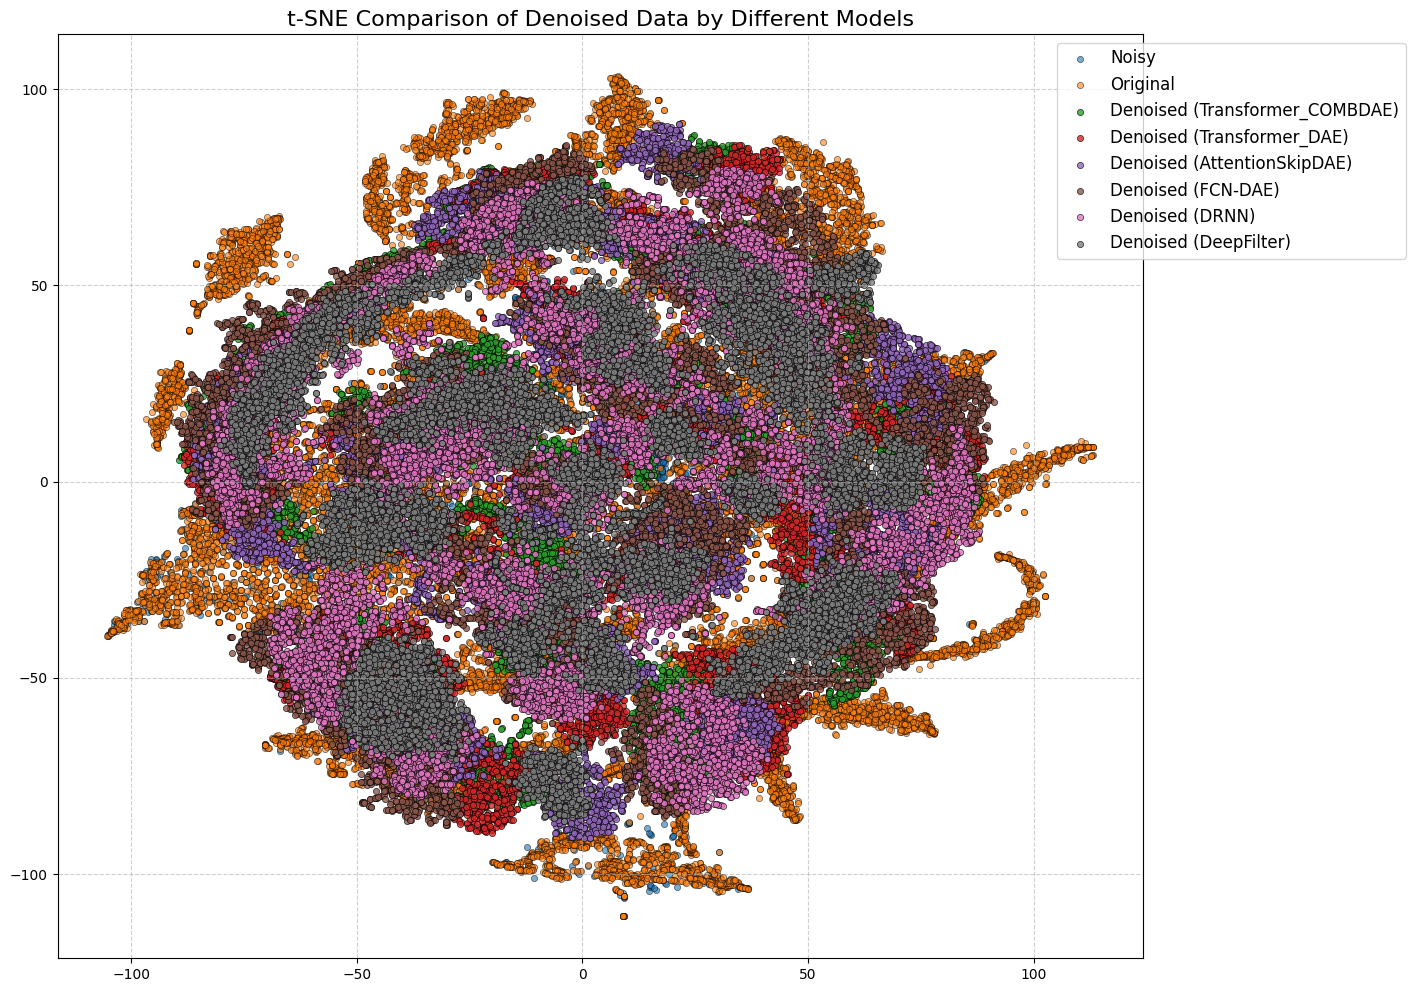

In [141]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn color palette 설정 (더 뚜렷한 색상 사용)
sns.set_palette("bright")  # "bright" 팔레트는 색상 대비가 강함
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# 모델 결과 로드
models = {
    "Transformer_COMBDAE": test_Transformer_COMBDAE,
    "Transformer_DAE": test_Transformer_DAE,
    "AttentionSkipDAE": test_AttentionSkipDAE,
    "FCN-DAE": test_FCN_DAE,
    "DRNN": test_DRNN,
    "DeepFilter": test_DeepFilter
}

# t-SNE 적용 및 시각화 함수
def plot_tsne_comparison(models):
    X_test, y_test, _ = list(models.values())[0]  # 기준 original/noisy 데이터
    combined_data = np.concatenate((X_test.reshape(X_test.shape[0], -1), y_test.reshape(y_test.shape[0], -1)))
    
    # t-SNE 변환 (original + noisy 데이터)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_data = tsne.fit_transform(combined_data)
    # n_samples = len(X_test)
    n_samples = 2000
    
    # 시각화 설정
    plt.figure(figsize=(14, 12))
    plt.scatter(reduced_data[:n_samples, 0], reduced_data[:n_samples, 1], alpha=0.6, label='Noisy', c=colors[0], s=20, edgecolor='k', linewidth=0.5)
    plt.scatter(reduced_data[n_samples:, 0], reduced_data[n_samples:, 1], alpha=0.6, label='Original', c=colors[1], s=20, edgecolor='k', linewidth=0.5)
    
    # 모델별 denoised 결과 추가 시각화
    for i, (name, data) in enumerate(models.items()):
        _, _, y_pred = data
        y_pred_flattened = y_pred.reshape(y_pred.shape[0], -1)
        y_pred_reduced = tsne.fit_transform(y_pred_flattened)
        
        plt.scatter(y_pred_reduced[:, 0], y_pred_reduced[:, 1], alpha=0.8, label=f'Denoised ({name})', s=20, c=colors[i+2], edgecolor='k', linewidth=0.5)

    plt.title("t-SNE Comparison of Denoised Data by Different Models", fontsize=16)
    plt.legend(loc='upper right', fontsize=12, bbox_to_anchor=(1.25, 1))  # 범례 위치 조정
    plt.grid(True, linestyle='--', alpha=0.6)  # 그리드 추가
    plt.show()

# t-SNE 시각화 실행
plot_tsne_comparison(models)

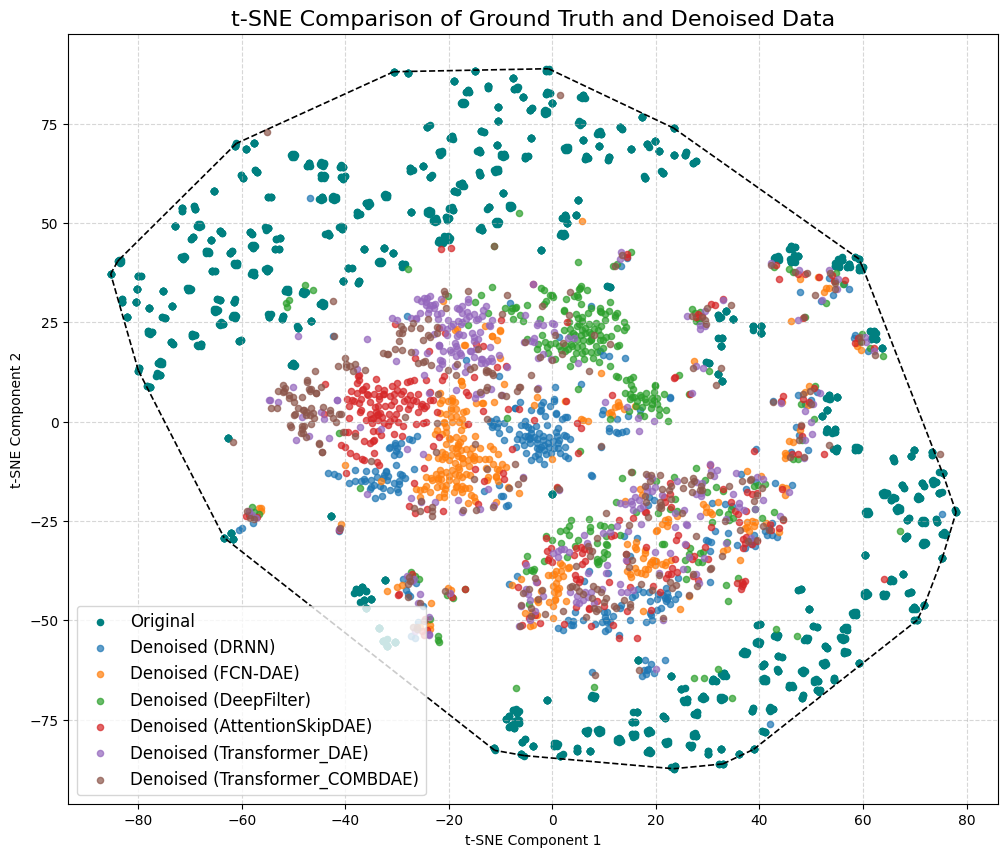

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 모델 결과 로드 (예: Transformer_DAE, Transformer_COMBDAE)
models = {
    "DRNN": test_DRNN,
    "FCN-DAE": test_FCN_DAE,
    "DeepFilter": test_DeepFilter,
    "AttentionSkipDAE": test_AttentionSkipDAE,
    "Transformer_DAE": test_Transformer_DAE,
    "Transformer_COMBDAE": test_Transformer_COMBDAE
}

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull

# t-SNE 시각화 함수 (개선된 버전)
def plot_tsne_comparison_with_hull(models, n_samples=300):
    """
    Visualize the t-SNE comparison of ground truth and denoised data from different models.
    Ground truth is highlighted with a convex hull.
    """
    combined_data = []
    labels = []

    for i, (name, data) in enumerate(models.items()):
        X_test, y_pred = data[1], data[2]
        combined_data.append(X_test[:n_samples].reshape(n_samples, -1))
        combined_data.append(y_pred[:n_samples].reshape(n_samples, -1))
        labels.extend(["Original"] * n_samples)
        labels.extend([f"Denoised ({name})"] * n_samples)
    
    combined_data = np.vstack(combined_data)
    
    # t-SNE 적용
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_data = tsne.fit_transform(combined_data)
    
    # 시각화
    plt.figure(figsize=(12, 10))
    colors = {
        "Original": "teal",                  
        "Denoised (DRNN)": "#1f77b4",        
        "Denoised (FCN-DAE)": "#ff7f0e",     
        "Denoised (DeepFilter)": "#2ca02c",  
        "Denoised (AttentionSkipDAE)": "#d62728",
        "Denoised (Transformer_DAE)": "#9467bd",
        "Denoised (Transformer_COMBDAE)": "#8c564b"
    }


    # Ground Truth 시각화 (Convex Hull 추가)
    original_indices = [i for i, lbl in enumerate(labels) if lbl == "Original"]
    original_points = reduced_data[original_indices]
    plt.scatter(original_points[:, 0], original_points[:, 1], c=colors["Original"], s=20, label="Original")
    
    hull = ConvexHull(original_points)
    for simplex in hull.simplices:
        plt.plot(original_points[simplex, 0], original_points[simplex, 1], "k--", lw=1.2)
    
    # Denoised 데이터 시각화
    for name in models.keys():
        denoised_indices = [i for i, lbl in enumerate(labels) if lbl == f"Denoised ({name})"]
        plt.scatter(reduced_data[denoised_indices, 0], reduced_data[denoised_indices, 1], 
                    c=colors[f"Denoised ({name})"], alpha=0.7, s=20, label=f"Denoised ({name})")
    
    plt.title("t-SNE Comparison of Ground Truth and Denoised Data", fontsize=16)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(fontsize=12, loc="best")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# 실행
plot_tsne_comparison_with_hull(models)


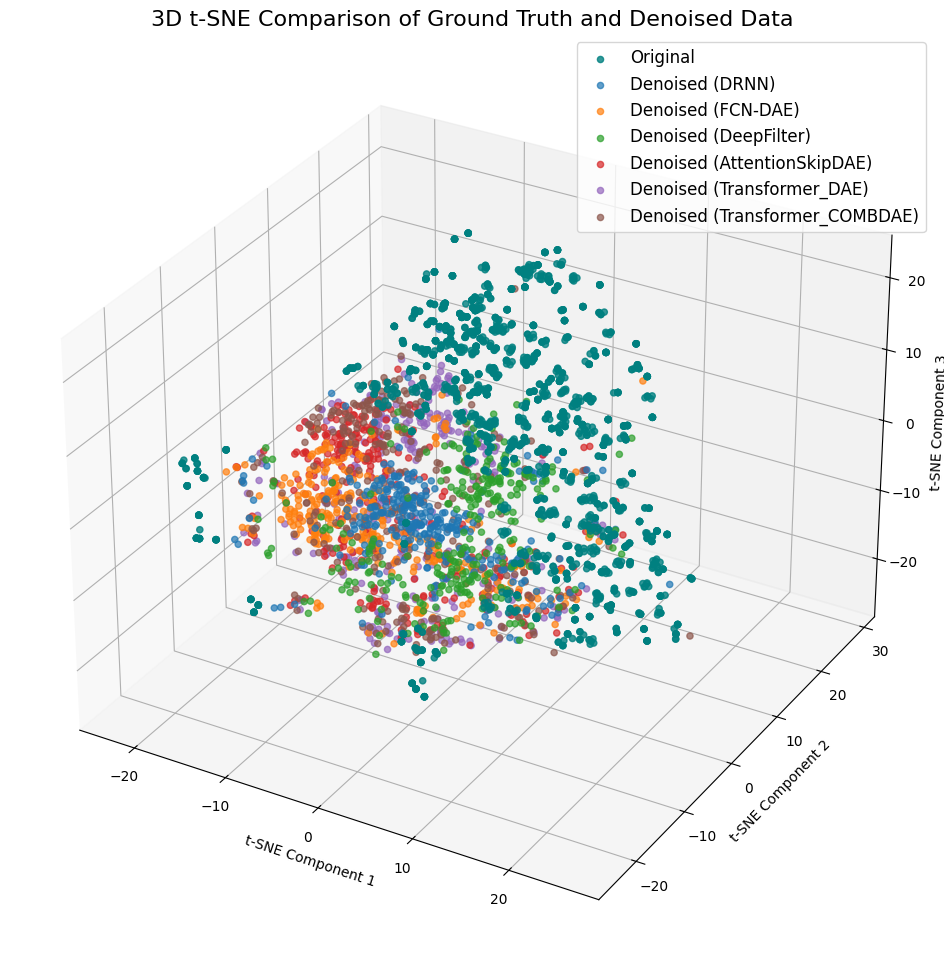

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting
from sklearn.manifold import TSNE

def plot_tsne_3d_comparison(models, n_samples=300):
    """
    3D t-SNE comparison of ground truth and denoised data from different models.
    """
    combined_data = []
    labels = []

    for i, (name, data) in enumerate(models.items()):
        X_test, y_pred = data[1], data[2]
        combined_data.append(X_test[:n_samples].reshape(n_samples, -1))
        combined_data.append(y_pred[:n_samples].reshape(n_samples, -1))
        labels.extend(["Original"] * n_samples)
        labels.extend([f"Denoised ({name})"] * n_samples)
    
    combined_data = np.vstack(combined_data)
    
    # Apply t-SNE in 3D
    tsne = TSNE(n_components=3, perplexity=30, random_state=42)
    reduced_data = tsne.fit_transform(combined_data)
    
    # Create a 3D plot
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')
    colors = {
        "Original": "teal",
        "Denoised (DRNN)": "#1f77b4",
        "Denoised (FCN-DAE)": "#ff7f0e",
        "Denoised (DeepFilter)": "#2ca02c",
        "Denoised (AttentionSkipDAE)": "#d62728",
        "Denoised (Transformer_DAE)": "#9467bd",
        "Denoised (Transformer_COMBDAE)": "#8c564b"
    }

    # Plot the original data
    original_indices = [i for i, lbl in enumerate(labels) if lbl == "Original"]
    ax.scatter(reduced_data[original_indices, 0], reduced_data[original_indices, 1], reduced_data[original_indices, 2], 
               c=colors["Original"], label="Original", alpha=0.8, s=20)
    
    # Plot the denoised data for each model
    for name in models.keys():
        denoised_indices = [i for i, lbl in enumerate(labels) if lbl == f"Denoised ({name})"]
        ax.scatter(reduced_data[denoised_indices, 0], reduced_data[denoised_indices, 1], reduced_data[denoised_indices, 2], 
                   c=colors[f"Denoised ({name})"], label=f"Denoised ({name})", alpha=0.7, s=20)
    
    # Customize plot appearance
    ax.set_title("3D t-SNE Comparison of Ground Truth and Denoised Data", fontsize=16)
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.set_zlabel("t-SNE Component 3")
    ax.legend(fontsize=12, loc="best")
    plt.show()

# 실행
plot_tsne_3d_comparison(models)


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from vg_beat_detectors import FastNVG  # Import the FastNVG detector

def plot_concatenated_r_peaks(y_test, y_pred, model_name, sampling_rate=360, save_dir="fig7", max_samples=8):
    """
    Concatenate samples and plot R-peak detection for ground truth and denoised signals.

    :param y_test: Ground truth signals.
    :param y_pred: Denoised signals.
    :param model_name: Name of the model.
    :param sampling_rate: Sampling rate of the signals.
    :param save_dir: Directory to save the plots.
    :param max_samples: Maximum number of samples to concatenate.
    """
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Concatenate a limited number of samples
    y_test_concat = np.concatenate([y.flatten() for y in y_test[1032:1032+max_samples]])
    y_pred_concat = np.concatenate([y.flatten() for y in y_pred[1032:1032+max_samples]])
    
    # Initialize the FastNVG detector
    detector = FastNVG(sampling_frequency=sampling_rate)
    gt_peaks = detector.find_peaks(y_test_concat)
    denoised_peaks = detector.find_peaks(y_pred_concat)

    # Plot the concatenated signals
    plt.figure(figsize=(24, 16))

    # Add red grid lines
    y_min, y_max = min(y_test_concat.min(), y_pred_concat.min()), max(y_test_concat.max(), y_pred_concat.max())
    signal_length = len(y_test_concat)
    
    for x in np.arange(0, signal_length, sampling_rate * 0.2):  # Vertical bold lines every 0.2s
        plt.axvline(x=x, color='red', linestyle='-', alpha=0.7, linewidth=0.8)
    for x in np.arange(0, signal_length, sampling_rate * 0.04):  # Vertical thin lines every 0.04s
        plt.axvline(x=x, color='red', linestyle='-', alpha=0.3, linewidth=0.5)
    # for y in np.arange(y_min, y_max, 0.5):  # Horizontal bold lines every 0.5mV
    #     plt.axhline(y=y, color='red', linestyle='-', alpha=0.7, linewidth=0.8)
    for y in np.arange(y_min, y_max, 0.1):  # Horizontal thin lines every 0.1mV
        plt.axhline(y=y, color='red', linestyle='-', alpha=0.3, linewidth=0.5)

    # Plot Ground Truth signal
    plt.plot(y_test_concat, label="Ground Truth Signal", color="blue", linewidth=2)
    plt.scatter(gt_peaks, y_test_concat[gt_peaks], color="blue", s=100, label="R-Peaks (Ground Truth)", zorder=5)  # 크기 증가 및 색상 변경

    # Plot Denoised signal
    plt.plot(y_pred_concat, label="Denoised Signal", color="red", linewidth=2)
    plt.scatter(denoised_peaks, y_pred_concat[denoised_peaks], color="red", s=100, label="R-Peaks (Denoised)", zorder=5)

    # Draw dashed lines for R-peak differences and annotate Δ values
    for gt, den in zip(gt_peaks, denoised_peaks):
        plt.axvline(x=gt, color="blue", linestyle="--", alpha=0.5)
        plt.axvline(x=den, color="red", linestyle="--", alpha=0.5)
        delta_time = abs(gt - den) / sampling_rate
        plt.text((gt + den) / 2, max(y_test_concat.max(), y_pred_concat.max()) * 0.8,
                 f"Δ = {delta_time:.2f}s", ha="center", va="bottom", fontsize=10, color="purple")

    # Add labels, legend, and grid
    plt.title(f"Concatenated R-Peak Detection - {model_name}", fontsize=24, fontweight="bold")
    plt.xlabel("Samples (N)", fontsize=20)
    plt.ylabel("Amplitude (au)", fontsize=20)
    plt.legend(fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Set x-axis limits to start at 0 and end at the signal length
    plt.xlim(0, signal_length)

    # Save the plot
    save_path = os.path.join(save_dir, f"{model_name}_R_Peaks_Comparison.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved concatenated R-peak plot for {model_name}: {save_path}")

# Example usage
for model_name, test_model in model_results.items():
    y_test, y_pred = test_model[1], test_model[2]

    y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], -1)
    y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], -1)
    # metrics, debug_logs, debug_plots = calculate_rr_accuracy_with_mape(y_test, y_pred)

    # print(f"Model: {model_name}\nMetrics: {metrics}\n")
    plot_concatenated_r_peaks(y_test, y_pred, model_name)


Saved concatenated R-peak plot for FIR-Filter: fig7/FIR-Filter_R_Peaks_Comparison.png
Saved concatenated R-peak plot for IIR-Filter: fig7/IIR-Filter_R_Peaks_Comparison.png
Saved concatenated R-peak plot for DRNN: fig7/DRNN_R_Peaks_Comparison.png
Saved concatenated R-peak plot for FCN-DAE: fig7/FCN-DAE_R_Peaks_Comparison.png
Saved concatenated R-peak plot for DeepFilter: fig7/DeepFilter_R_Peaks_Comparison.png
Saved concatenated R-peak plot for AttentionSkipDAE: fig7/AttentionSkipDAE_R_Peaks_Comparison.png
Saved concatenated R-peak plot for Transformer_DAE: fig7/Transformer_DAE_R_Peaks_Comparison.png
Saved concatenated R-peak plot for Transformer-COMBDAE: fig7/Transformer-COMBDAE_R_Peaks_Comparison.png


### r peak

GT에 R-peak가 없거나 Denoised 신호에만 R-peak가 존재하는 경우를 처리하는 논리를 추가

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
from vg_beat_detectors import FastNVG


def calculate_peak_detection_accuracy(y_test, y_pred, sampling_rate=360, tolerance=0.05):
    """
    Calculate Peak Detection Accuracy assuming Ground Truth R-peaks always exist.
    :param y_test: Ground truth ECG signals.
    :param y_pred: Denoised ECG signals.
    :param sampling_rate: Sampling rate of the signals.
    :param tolerance: Time tolerance for matching peaks (in seconds).
    :return: Metrics (Accuracy, Precision, Recall, F1-score).
    """
    detector = FastNVG(sampling_frequency=sampling_rate)
    tp, fp, fn = 0, 0, 0

    for ground_truth, denoised in zip(y_test, y_pred):
        ground_truth = ground_truth.flatten()
        denoised = denoised.flatten()

        # Detect R-peaks
        gt_peaks = detector.find_peaks(ground_truth)
        denoised_peaks = detector.find_peaks(denoised)

        gt_times = np.array(gt_peaks) / sampling_rate
        denoised_times = np.array(denoised_peaks) / sampling_rate

        # If both GT and denoised peaks exist
        if len(gt_times) > 0 and len(denoised_times) > 0:
            matched_gt = set()
            for den_time in denoised_times:
                # Check if any GT falls within tolerance
                matches = np.abs(gt_times - den_time) <= tolerance
                if any(matches):
                    tp += 1  # Matched peaks are True Positives
                    matched_gt.add(np.where(matches)[0][0])  # Store matched GT index
                else:
                    fp += 1  # Unmatched denoised peak is a False Positive

            # GT peaks not matched by any denoised peaks are False Negatives
            fn += len(gt_times) - len(matched_gt)
        else:
            # If only one of them has R-peaks
            fn += len(gt_times)
            fp += len(denoised_times)

    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
    }


# def plot_r_peak_detection(y_test, y_pred, model_name, sampling_rate=360, save_dir="fig8", max_samples=8):
#     """
#     Plot R-peak detection results including TP, FP, FN.
#     :param y_test: Ground truth ECG signals.
#     :param y_pred: Denoised ECG signals.
#     :param model_name: Name of the model.
#     :param sampling_rate: Sampling rate of the signals.
#     :param save_dir: Directory to save the plot.
#     :param max_samples: Number of samples to concatenate for visualization.
#     """
#     os.makedirs(save_dir, exist_ok=True)

#     # Concatenate a limited number of samples
#     y_test_concat = np.concatenate([y.flatten() for y in y_test[:max_samples]])
#     y_pred_concat = np.concatenate([y.flatten() for y in y_pred[:max_samples]])

#     # Detect R-peaks
#     detector = FastNVG(sampling_frequency=sampling_rate)
#     gt_peaks = detector.find_peaks(y_test_concat)
#     denoised_peaks = detector.find_peaks(y_pred_concat)

#     # Convert to time
#     gt_times = np.array(gt_peaks) / sampling_rate
#     denoised_times = np.array(denoised_peaks) / sampling_rate

#     # Match peaks within tolerance
#     tolerance = 0.05
#     tp_indices, fp_indices, fn_indices = [], [], []

#     matched_gt = set()
#     for den_idx, den_time in enumerate(denoised_times):
#         matches = np.abs(gt_times - den_time) <= tolerance
#         if any(matches):
#             tp_indices.append(den_idx)
#             matched_gt.add(np.where(matches)[0][0])
#         else:
#             fp_indices.append(den_idx)

#     fn_indices = [idx for idx in range(len(gt_times)) if idx not in matched_gt]

#     # Plot the signals and detected peaks
#     plt.figure(figsize=(24, 12))  # 그림 크기 확대
#     plt.plot(y_test_concat, label="Ground Truth Signal", color="blue", linewidth=3)  # Ground Truth 두께 확대
#     plt.plot(y_pred_concat, label="Denoised Signal", color="red", linewidth=3)  # Denoised 두께 확대

#     # Plot TP, FP, FN
#     plt.scatter(
#         gt_peaks[list(matched_gt)],
#         y_test_concat[gt_peaks[list(matched_gt)]],
#         color="green",
#         label="True Positives (TP)",
#         s=200,  # TP 크기 확대
#         marker="o",
#         zorder=5,
#     )
#     plt.scatter(
#         [denoised_peaks[idx] for idx in fp_indices],
#         y_pred_concat[[denoised_peaks[idx] for idx in fp_indices]],
#         color="black",
#         label="False Positives (FP)",
#         s=200,  # FP 크기 확대
#         marker="x",
#         zorder=5,
#     )
#     plt.scatter(
#         [gt_peaks[idx] for idx in fn_indices],
#         y_test_concat[[gt_peaks[idx] for idx in fn_indices]],
#         color="purple",
#         label="False Negatives (FN)",
#         s=200,  # FN 크기 확대
#         marker="^",
#         zorder=5,
#     )

#     # Add titles and labels
#     plt.title(f"R-Peak Detection - {model_name}", fontsize=40, pad=30, fontweight='bold')  # 제목 폰트 크기 확대
#     plt.xlabel("Samples (N)", fontsize=30, labelpad=20)  # x축 라벨 크기 확대
#     plt.ylabel("Amplitude (au)", fontsize=30, labelpad=20)  # y축 라벨 크기 확대
#     plt.tick_params(axis="both", which="major", labelsize=20)  # 축 눈금 크기 확대
#     plt.legend(fontsize=25, loc="lower left")  # 범례 크기 확대 및 위치 조정
#     plt.grid(True, linestyle="--", alpha=0.7)

#     # Save the plot
#     save_path = os.path.join(save_dir, f"{model_name}_R_Peak_Detection.png")
#     plt.savefig(save_path, dpi=300, bbox_inches="tight")  # 여백 조정
#     plt.close()
#     print(f"Saved R-peak detection plot for {model_name}: {save_path}")
def plot_r_peak_detection(y_test, y_pred, model_name, sampling_rate=360, save_dir="fig8", max_samples=8):
    """
    Plot R-peak detection results including TP, FP, FN with enhanced visualization.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Concatenate a limited number of samples
    y_test_concat = np.concatenate([y.flatten() for y in y_test[:max_samples]])
    y_pred_concat = np.concatenate([y.flatten() for y in y_pred[:max_samples]])

    # Detect R-peaks
    detector = FastNVG(sampling_frequency=sampling_rate)
    gt_peaks = detector.find_peaks(y_test_concat)
    denoised_peaks = detector.find_peaks(y_pred_concat)

    # Convert to time
    gt_times = np.array(gt_peaks) / sampling_rate
    denoised_times = np.array(denoised_peaks) / sampling_rate

    # Match peaks within tolerance
    tolerance = 0.05
    tp_indices, fp_indices, fn_indices = [], [], []

    matched_gt = set()
    for den_idx, den_time in enumerate(denoised_times):
        matches = np.abs(gt_times - den_time) <= tolerance
        if any(matches):
            tp_indices.append(den_idx)
            matched_gt.add(np.where(matches)[0][0])
        else:
            fp_indices.append(den_idx)

    fn_indices = [idx for idx in range(len(gt_times)) if idx not in matched_gt]

    # Plot the signals and detected peaks
    plt.figure(figsize=(30, 15))  # 그림 크기 확대
    plt.plot(y_test_concat, label="Ground Truth Signal", color="blue", linewidth=4)  # Ground Truth 두께 확대
    plt.plot(y_pred_concat, label="Denoised Signal", color="red", linewidth=4)  # Denoised 두께 확대

    # Plot TP, FP, FN
    plt.scatter(
        gt_peaks[list(matched_gt)],
        y_test_concat[gt_peaks[list(matched_gt)]],
        color="green",
        label="True Positives (TP)",
        s=300,  # TP 크기 확대
        marker="o",
        zorder=5,
        edgecolors="black",  # 테두리 추가
        linewidths=2
    )
    plt.scatter(
        [denoised_peaks[idx] for idx in fp_indices],
        y_pred_concat[[denoised_peaks[idx] for idx in fp_indices]],
        color="black",
        label="False Positives (FP)",
        s=300,  # FP 크기 확대
        marker="x",
        zorder=5,
        linewidths=3  # FP 선 굵기 확대
    )
    plt.scatter(
        [gt_peaks[idx] for idx in fn_indices],
        y_test_concat[[gt_peaks[idx] for idx in fn_indices]],
        color="purple",
        label="False Negatives (FN)",
        s=300,  # FN 크기 확대
        marker="^",
        zorder=5,
        edgecolors="black",  # 테두리 추가
        linewidths=2
    )

    # Add titles and labels
    plt.title(f"R-Peak Detection - {model_name}", fontsize=50, pad=30, fontweight='bold')  # 제목 폰트 크기 확대
    plt.xlabel("Samples (N)", fontsize=40, labelpad=20)  # x축 라벨 크기 확대
    plt.ylabel("Amplitude (au)", fontsize=40, labelpad=20)  # y축 라벨 크기 확대
    plt.tick_params(axis="both", which="major", labelsize=30)  # 축 눈금 크기 확대
    plt.legend(fontsize=18, loc="upper left", frameon=True, shadow=True, fancybox=True)  # 범례 크기 및 스타일 조정
    plt.grid(True, linestyle="--", alpha=0.7)

    # Save the plot
    save_path = os.path.join(save_dir, f"{model_name}_R_Peak_Detection.png")
    plt.savefig(save_path, bbox_inches="tight")  # 해상도 향상 및 여백 조정
    plt.close()
    print(f"Saved R-peak detection plot for {model_name}: {save_path}")



# Loop through each model and calculate metrics
for model_name, test_model in model_results.items():
    y_test, y_pred = test_model[1], test_model[2]

    y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], -1)
    y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], -1)

    # Calculate metrics
    metrics = calculate_peak_detection_accuracy(y_test, y_pred)
    print(f"Model: {model_name}\nMetrics: {metrics}\n")

    # Plot TP, FP, FN
    plot_r_peak_detection(y_test, y_pred, model_name)


Model: FIR-Filter
Metrics: {'Accuracy': 0.4035696900859971, 'Precision': 0.4321957322582887, 'Recall': 0.8590177522967466, 'F1-Score': 0.5750618482809645}

Saved R-peak detection plot for FIR-Filter: fig8/FIR-Filter_R_Peak_Detection.png
Model: IIR-Filter
Metrics: {'Accuracy': 0.40445570277994286, 'Precision': 0.43289652056032535, 'Recall': 0.8602611038198522, 'F1-Score': 0.5759607825001156}

Saved R-peak detection plot for IIR-Filter: fig8/IIR-Filter_R_Peak_Detection.png
Model: DRNN
Metrics: {'Accuracy': 0.7736669607966721, 'Precision': 0.898346018735363, 'Recall': 0.847896663673413, 'F1-Score': 0.8723925944351657}

Saved R-peak detection plot for DRNN: fig8/DRNN_R_Peak_Detection.png
Model: FCN-DAE
Metrics: {'Accuracy': 0.8207731601185596, 'Precision': 0.9041333796457103, 'Recall': 0.8990122262899772, 'F1-Score': 0.9015655306178996}

Saved R-peak detection plot for FCN-DAE: fig8/FCN-DAE_R_Peak_Detection.png
Model: DeepFilter
Metrics: {'Accuracy': 0.7132851827533377, 'Precision': 0.7743

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch  # PSD 계산을 위해 Welch 방법 사용
models = {
    "DRNN": test_DRNN,
    "FCN-DAE": test_FCN_DAE,
    "DeepFilter": test_DeepFilter,
    "AttentionSkipDAE": test_AttentionSkipDAE,
    "Transformer_DAE": test_Transformer_DAE,
    "Transformer_COMBDAE": test_Transformer_COMBDAE
}
def plot_psd(y_test, y_noisy, y_pred, model_name, fs=360, save_dir="psd_plots2"):
    """
    Plot the Power Spectral Density (PSD) of the original, noisy, and denoised signals.
    """
    plt.figure(figsize=(10, 6))

    # Calculate PSD using Welch's method
    freqs, psd_original = welch(y_test.flatten(), fs=fs, nperseg=1024)
    _, psd_noisy = welch(y_noisy.flatten(), fs=fs, nperseg=1024)
    _, psd_denoised = welch(y_pred.flatten(), fs=fs, nperseg=1024)

    # Plot PSD curves
    plt.semilogy(freqs, psd_original, label="Original", color="teal", linewidth=2)
    plt.semilogy(freqs, psd_noisy, label="Noisy", color="red", linestyle="--", alpha=0.7)
    plt.semilogy(freqs, psd_denoised, label=f"Denoised ({model_name})", color="blue", linewidth=2)

    # Highlight critical frequency range (0.67Hz to 40Hz)
    plt.axvspan(0, 0.5, color='orange', alpha=0.2, label="Below 0.5Hz (Low-Frequency Noise)")
    plt.axvspan(50, fs/2, color='gray', alpha=0.2, label="Above 50Hz (High-Frequency Noise)")

    # Customize the plot
    plt.title(f"Power Spectral Density Comparison - {model_name}", fontsize=16)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (dB/Hz)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)
    
    # Save the plot
    plt.savefig(f"{save_dir}/{model_name}_psd.png", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved PSD plot for {model_name}")

# Example usage
for model_name, test_model in models.items():
    y_test, y_pred = test_model[1], test_model[2]
    y_noisy = test_model[0]  # Noisy signal

    # Plot PSD for each model
    plot_psd(y_test[:], y_noisy[:], y_pred[:], model_name)


Saved PSD plot for DRNN
Saved PSD plot for FCN-DAE
Saved PSD plot for DeepFilter
Saved PSD plot for AttentionSkipDAE
Saved PSD plot for Transformer_DAE
Saved PSD plot for Transformer_COMBDAE


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import welch  # PSD 계산을 위해 scipy의 welch 함수 사용

# # 모델 결과 로드
# models = {
#     "DRNN": test_DRNN,
#     "FCN-DAE": test_FCN_DAE,
#     "DeepFilter": test_DeepFilter,
#     "AttentionSkipDAE": test_AttentionSkipDAE,
#     "Transformer_DAE": test_Transformer_DAE,
#     "Transformer_COMBDAE": test_Transformer_COMBDAE
# }

# # PSD 곡선 시각화 함수
# def plot_psd_curve(model_name, y_test, noisy_signal, denoised_signal, sampling_rate=360, max_freq=175):
#     """
#     Plot the PSD curves for a given model.
    
#     :param model_name: Name of the model.
#     :param y_test: Ground truth signal.
#     :param noisy_signal: Noisy input signal.
#     :param denoised_signal: Denoised output signal.
#     :param sampling_rate: Sampling rate of the signals (default: 360Hz).
#     :param max_freq: Maximum frequency for the x-axis (default: 175Hz).
#     """
#     plt.figure(figsize=(12, 8))
    
#     # PSD 계산
#     def compute_psd(signal, label, color):
#         freqs, psd = welch(signal, fs=sampling_rate, nperseg=1024)
#         plt.semilogy(freqs, psd, label=label, color=color)
    
#     # Ground Truth
#     compute_psd(y_test.flatten(), "Original", "teal")
    
#     # Noisy Signal
#     compute_psd(noisy_signal.flatten(), "Noisy", "darkred")
    
#     # Denoised Signal
#     compute_psd(denoised_signal.flatten(), f"Denoised ({model_name})", "royalblue")
    
#     # Plot 설정
#     plt.xlim(0, max_freq)
#     plt.xlabel("Frequency (Hz)", fontsize=14)
#     plt.ylabel("PSD (dB/Hz)", fontsize=14)
#     plt.title(f"PSD Curve - {model_name}", fontsize=16, fontweight="bold")
#     plt.legend(fontsize=12)
#     plt.grid(True, linestyle="--", alpha=0.5)
    
#     # 그래프 저장 및 표시
#     plt.savefig(f"psd_curve_{model_name}.png", dpi=300, bbox_inches="tight")
#     plt.close()
#     print(f"Saved PSD curve for {model_name}.")

# # Example usage for each model
# for model_name, test_model in models.items():
#     y_test = test_model[1][0]  # 첫 번째 샘플만 사용
#     noisy_signal = test_model[0][0]  # 첫 번째 noisy 샘플
#     denoised_signal = test_model[2][0]  # 첫 번째 denoised 샘플
    
#     plot_psd_curve(model_name, y_test, noisy_signal, denoised_signal)


Saved PSD curve for DRNN.
Saved PSD curve for FCN-DAE.
Saved PSD curve for DeepFilter.
Saved PSD curve for AttentionSkipDAE.
Saved PSD curve for Transformer_DAE.
Saved PSD curve for Transformer_COMBDAE.


# cinc dataset

In [1]:
# # Import necessary libraries
# import numpy as np
# import wfdb
# import _pickle as pickle
# from Data_Preparation.data_preparation import Data_Preparation
# from Data_Preparation.data_preparation_with_fourier import Data_Preparation_with_Fourier
# # Function to preprocess the MIT-BIH Noise Stress Test Database
# def prepare(NSTDBPath='data/mit-bih-noise-stress-test-database-1.0.0/'):
#     """
#     Reads signals from the MIT-BIH Noise Stress Test Database, prints metadata, and saves the data as a pickle file.

#     Args:
#     - NSTDBPath (str): Path to the Noise Stress Test Database.

#     Returns:
#     - None
#     """
#     # Load signals from the database
#     bw_signals, bw_fields = wfdb.rdsamp(NSTDBPath + 'bw')
#     em_signals, em_fields = wfdb.rdsamp(NSTDBPath + 'em')
#     ma_signals, ma_fields = wfdb.rdsamp(NSTDBPath + 'ma')

#     # Display metadata for each signal type
#     print("Band-Widened Noise Fields:")
#     for key, value in bw_fields.items():
#         print(f"{key}: {value}")

#     print("\nElectromyographic Noise Fields:")
#     for key, value in em_fields.items():
#         print(f"{key}: {value}")

#     print("\nMotion Artifact Noise Fields:")
#     for key, value in ma_fields.items():
#         print(f"{key}: {value}")

#     # Save data to a pickle file
#     output_file = 'data/NoiseBWL.pkl'
#     with open(output_file, 'wb') as output:
#         pickle.dump([bw_signals, em_signals, ma_signals], output)

#     print('=========================================================')
#     print(f'Data saved to {output_file}')
# # Set the path to the database and run the preprocessing function
# NSTDBPath = 'data/mit-bih-noise-stress-test-database-1.0.0/'  # Adjust the path as needed
# prepare(NSTDBPath)


In [158]:
# Import necessary libraries
import pickle
import numpy as np
import pandas as pd
import glob
import wfdb
from scipy import signal
from Data_Preparation.data_preparation import Data_Preparation
from Data_Preparation.data_preparation_with_fourier import Data_Preparation_with_Fourier

def resample_signal(x, fs, fs_target):
    t = np.arange(x.shape[0]).astype("float64")
    if fs == fs_target:
        return x, t
    new_length = int(x.shape[0] * fs_target / fs)
    if np.isnan(x).any():
        x = pd.Series(x.reshape((-1,))).interpolate().values
    resampled_x, resampled_t = signal.resample(x, num=new_length, t=t)
    return resampled_x, resampled_t

def load_train_data(my_fs=360):
    signals = []
    for folder_name in [f'A0{i}' for i in range(9)]:
        for sig in glob.glob(f'data/cinc2017/physionet.org/files/challenge-2017/1.0.0/training/{folder_name}/*.hea'):
            # print(f"Loading signal: {sig}")
            my_sig = wfdb.rdsamp(sig[:-4])
            # print(f"Signal shape: {my_sig[0].shape}, fs: {my_sig[1]['fs']}")
            # Signal shape: (5826, 1), fs: 300
            my_sig, _ = resample_signal(my_sig[0], my_sig[1]['fs'], my_fs)
            signals.append(my_sig.reshape((-1,)))
    return signals

def load_test_data(my_fs=360):
    signals = []
    for sig in glob.glob('data/cinc2017/physionet.org/files/challenge-2017/1.0.0/validation/*.hea'):
        my_sig = wfdb.rdsamp(sig[:-4])
        my_sig, _ = resample_signal(my_sig[0], my_sig[1]['fs'], my_fs)
        signals.append(my_sig.reshape((-1,)))
    return signals

def load_noise():
    with open('data/NoiseBWL.pkl', 'rb') as f:
        return pickle.load(f)

def sig_to_parts(sig, part_size=512):
    num_parts = sig.shape[0] // part_size
    return [sig[i * part_size:(i + 1) * part_size] for i in range(num_parts)]

def sigs_to_parts(sigs, part_size=512):
    parts = []
    for sig in sigs:
        parts += sig_to_parts(sig, part_size=part_size)
    return parts


In [159]:
import numpy as np
from scipy.fft import fft
import pickle

def make_fourier(inputs, n, fs):
    """
    Extract frequency domain information and match the shape to time-domain signals.
    """
    T = n / fs
    k = np.arange(n)
    freq = k / T
    freq = freq[range(int(n / 2))]

    signal_list = []
    for i in range(inputs.shape[0]):
        y = inputs[i, :]
        Y = fft(y) / n  # Perform FFT and normalize
        Y = np.abs(Y[range(int(n / 2))])
        # Duplicate to match time-domain size
        Y_full = np.hstack([Y, Y])
        signal_list.append(Y_full)

    return np.asarray(signal_list)

def Data_Preparation_with_Fourier_CINC(samples, fs=360):
    print('Getting the Data ready ...')

    # Load CINC data (beats_train and beats_test)
    beats_train = sigs_to_parts(load_train_data())
    beats_test = sigs_to_parts(load_test_data())
    print(f"[INFO] Loaded CINC data: {len(beats_train)} training beats, {len(beats_test)} testing beats.")

    # Load noise data
    with open('data/CombinedNoise.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

    #####################################
    # Data split and Fourier transform
    #####################################
    sn_train = []
    sn_test = []
    fourier_train_x = []
    fourier_test_x = []
    fourier_train_y = []
    fourier_test_y = []

    print(f"[INFO] Processing CINC data.")
    # Train data processing
    rnd_train = np.random.uniform(0.2, 2.0, size=len(beats_train))
    noise_index = 0
    for i, beat in enumerate(beats_train):
        # Select noise channel and noise sample segment
        channel_idx = i % len(combined_noise)
        noise = combined_noise[channel_idx][:, 0]
        noise_segment = noise[noise_index:noise_index + samples]

        # Scale noise to match beat amplitude
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value if noise_max_value != 0 else 1
        alpha = rnd_train[i] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_train.append(signal_noise)

        # Fourier transformation
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
        fourier_train_x.append(fourier_transformed_x[0])  # Append the single batch

        # Fourier transformation for labels
        fourier_transformed_y = make_fourier(beat.reshape(1, -1), samples, fs)
        fourier_train_y.append(fourier_transformed_y[0])  # Append the single batch

        # Update noise index
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    # Test data processing
    rnd_test = np.random.uniform(0.2, 2.0, size=len(beats_test))
    np.save('rnd_test_cinc.npy', rnd_test)  # Save rnd_test for later use
    print(f"[INFO] rnd_test shape: {rnd_test.shape}")
    noise_index = 0
    for i, beat in enumerate(beats_test):
        # Select noise channel and noise sample segment
        channel_idx = i % len(combined_noise)
        noise = combined_noise[channel_idx][:, 0]
        noise_segment = noise[noise_index:noise_index + samples]

        # Scale noise to match beat amplitude
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value if noise_max_value != 0 else 1
        alpha = rnd_test[i] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_test.append(signal_noise)

        # Fourier transformation
        fourier_transformed_x = make_fourier(signal_noise.reshape(1, -1), samples, fs)
        fourier_test_x.append(fourier_transformed_x[0])  # Append the single batch

        # Fourier transformation for labels
        fourier_transformed_y = make_fourier(beat.reshape(1, -1), samples, fs)
        fourier_test_y.append(fourier_transformed_y[0])  # Append the single batch

        # Update noise index
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    #####################################
    # Prepare datasets
    #####################################
    X_train = np.array(sn_train)
    X_test = np.array(sn_test)
    y_train = np.array(beats_train)
    y_test = np.array(beats_test)

    # Fourier datasets
    F_train_x = np.array(fourier_train_x)
    F_test_x = np.array(fourier_test_x)
    F_train_y = np.array(fourier_train_y)
    F_test_y = np.array(fourier_test_y)

    # Expand dimensions to match required shape
    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    F_train_x = np.expand_dims(F_train_x, axis=2)
    F_train_y = np.expand_dims(F_train_y, axis=2)
    F_test_x = np.expand_dims(F_test_x, axis=2)
    F_test_y = np.expand_dims(F_test_y, axis=2)

    Dataset = [X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y]

    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")
    print(f"[INFO] Fourier shapes -> F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}, F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")
    print('Dataset ready to use.')

    return Dataset

# # Unpack the dataset
# Dataset = Data_Preparation_with_Fourier_CINC(samples=512, fs=360)
# X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y = Dataset

# # Print dataset shapes for confirmation
# print(f"Time domain train shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"Frequency domain train shapes: F_train_x: {F_train_x.shape}, F_train_y: {F_train_y.shape}")
# print(f"Time domain test shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")
# print(f"Frequency domain test shapes: F_test_x: {F_test_x.shape}, F_test_y: {F_test_y.shape}")


In [160]:
def Data_Preparation_CINC(samples, fs=360):
    print('Getting the Data ready ...')

    # Load CINC data (beats_train and beats_test)
    beats_train = sigs_to_parts(load_train_data())
    beats_test = sigs_to_parts(load_test_data())
    print(f"[INFO] Loaded CINC data: {len(beats_train)} training beats, {len(beats_test)} testing beats.")

    # Load noise data
    with open('data/CombinedNoise.pkl', 'rb') as input:
        combined_noise = pickle.load(input)
    print(f"[INFO] Loaded CombinedNoise with {len(combined_noise)} channels")

    #####################################
    # Data split and Fourier transform
    #####################################
    sn_train = []
    sn_test = []


    print(f"[INFO] Processing CINC data.")
    # Train data processing
    rnd_train = np.random.uniform(0.2, 2.0, size=len(beats_train))
    noise_index = 0
    for i, beat in enumerate(beats_train):
        # Select noise channel and noise sample segment
        channel_idx = i % len(combined_noise)
        noise = combined_noise[channel_idx][:, 0]
        noise_segment = noise[noise_index:noise_index + samples]

        # Scale noise to match beat amplitude
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value if noise_max_value != 0 else 1
        alpha = rnd_train[i] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_train.append(signal_noise)

        # Update noise index
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    # Test data processing
    rnd_test = np.random.uniform(0.2, 2.0, size=len(beats_test))
    np.save('rnd_test_cinc.npy', rnd_test)  # Save rnd_test for later use
    print(f"[INFO] rnd_test shape: {rnd_test.shape}")
    noise_index = 0
    for i, beat in enumerate(beats_test):
        # Select noise channel and noise sample segment
        channel_idx = i % len(combined_noise)
        noise = combined_noise[channel_idx][:, 0]
        noise_segment = noise[noise_index:noise_index + samples]

        # Scale noise to match beat amplitude
        beat_max_value = np.max(beat) - np.min(beat)
        noise_max_value = np.max(noise_segment) - np.min(noise_segment)
        Ase = noise_max_value / beat_max_value if noise_max_value != 0 else 1
        alpha = rnd_test[i] / Ase
        signal_noise = beat + alpha * noise_segment
        sn_test.append(signal_noise)

        # Update noise index
        noise_index += samples
        if noise_index > (len(noise) - samples):
            noise_index = 0

    #####################################
    # Prepare datasets
    #####################################
    X_train = np.array(sn_train)
    X_test = np.array(sn_test)
    y_train = np.array(beats_train)
    y_test = np.array(beats_test)

    # Expand dimensions to match required shape
    X_train = np.expand_dims(X_train, axis=2)
    y_train = np.expand_dims(y_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    y_test = np.expand_dims(y_test, axis=2)

    Dataset = [X_train, y_train, X_test, y_test]

    print(f"[INFO] Final shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

    return Dataset




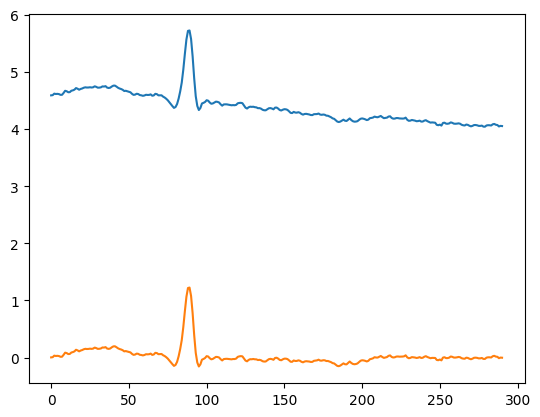

Running FIR fiter on the test set. This will take a while (2h)...
(FIR) Filtering signal 1 of 6727
(FIR) Filtering signal 2 of 6727
(FIR) Filtering signal 3 of 6727
(FIR) Filtering signal 4 of 6727
(FIR) Filtering signal 5 of 6727
(FIR) Filtering signal 6 of 6727
(FIR) Filtering signal 7 of 6727
(FIR) Filtering signal 8 of 6727
(FIR) Filtering signal 9 of 6727
(FIR) Filtering signal 10 of 6727
(FIR) Filtering signal 11 of 6727
(FIR) Filtering signal 12 of 6727
(FIR) Filtering signal 13 of 6727
(FIR) Filtering signal 14 of 6727
(FIR) Filtering signal 15 of 6727
(FIR) Filtering signal 16 of 6727
(FIR) Filtering signal 17 of 6727
(FIR) Filtering signal 18 of 6727
(FIR) Filtering signal 19 of 6727
(FIR) Filtering signal 20 of 6727
(FIR) Filtering signal 21 of 6727
(FIR) Filtering signal 22 of 6727
(FIR) Filtering signal 23 of 6727
(FIR) Filtering signal 24 of 6727
(FIR) Filtering signal 25 of 6727
(FIR) Filtering signal 26 of 6727
(FIR) Filtering signal 27 of 6727
(FIR) Filtering signal 28

<Figure size 640x480 with 0 Axes>

In [21]:
# -*- coding: utf-8 -*-
# ============================================================
#
#  BWL FIR Filtering
#  authors: David Castro Piñol, Francisco Perdigon Romero
#  email: davidpinyol91@gmail.com, fperdigon88@gmail.com
#  github id: Dacapi91, fperdigon
#
# ============================================================

import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import kaiserord, firwin, filtfilt, butter
from datetime import datetime
import _pickle as pickle
from Data_Preparation.data_preparation import Data_Preparation

def FIRRemoveBL(ecgy, Fs, Fc, factor):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0
    
    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate. 
    width = 0.07/nyq_rate 
    
    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20*np.log10(0.001))+1
    ripple_db = ripple_db / factor

    
    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)
       
    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc/nyq_rate, window=('kaiser', beta), pass_zero='highpass')

    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)
    
    return ECG_Clean, N


def FIRRemoveHF(ecgy, Fs, Fc, factor):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0

    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate.
    width = 0.07 / nyq_rate

    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20 * np.log10(0.001)) + 1
    ripple_db = ripple_db / factor

    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)

    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc / nyq_rate, window=('kaiser', beta), pass_zero='lowpass')

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)

    return ECG_Clean, N

def IIRRemoveBL(ecgy,Fs, Fc):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # fixed order
    N = 4
    
    # Normalized Cutt of frequency
    Wn = Fc/(Fs/2)    
    
    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'highpass', analog=False)
    
    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
        
    else:
        ECG_Clean = filtfilt(b, a, ecgy)
                   
    return ECG_Clean


def IIRRemoveHF(ecgy, Fs, Fc):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # fixed order
    N = 4

    # Normalized Cutt of frequency
    Wn = Fc / (Fs / 2)

    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'lowpass', analog=False)

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]

    else:
        ECG_Clean = filtfilt(b, a, ecgy)

    return ECG_Clean


def FIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        print('(FIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal, N = FIRRemoveBL(s, Fs, Fc_l, 4.5)
        temp_signal, N = FIRRemoveHF(temp_signal, Fs, Fc_h, 4.5)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]


def IIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        print('(IIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal = IIRRemoveBL(s, Fs, Fc_l)
        temp_signal = IIRRemoveHF(temp_signal, Fs, Fc_h)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]


if __name__ == "__main__":
    # signal for demonstration.
    ecgy = sio.loadmat('digitalFilters/ecgbeat.mat')
    signal = ecgy['ecgy']
    signal = list(signal[:,0])
    ## parameters
    Fs = 360
    Fc = 0.67
    factor = 2

    #ECG_Clean,N = FIRRemoveBL(signal,Fs,Fc,factor)

    ECG_Clean = IIRRemoveBL(signal,Fs, Fc)
    with open('./data/dataset_cinc.pkl', 'rb') as input:
        Dataset = pickle.load(input)
    X_train, y_train, X_test, y_test = Dataset
    plt.figure()
    plt.plot(signal[0:len(ecgy['ecgy'])])
    plt.plot(ECG_Clean)
    plt.show()
    plt.figure()
# Classical Filters
    train_time_list = []
    test_time_list = []
    # FIR
    print('Running FIR fiter on the test set. This will take a while (2h)...')
    start_test = datetime.now()
    [X_test_f, y_test_f, y_filter] = FIR_test_Dataset(Dataset)
    end_test = datetime.now()
    train_time_list.append(0)
    test_time_list.append(end_test - start_test)

    test_results_FIR = [X_test_f, y_test_f, y_filter]

    # Save FIR filter results
    with open('cinc_test_results_FIR.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results_FIR, output)
    print('Results from experiment FIR filter saved')

    # IIR
    print('Running IIR fiter on the test set. This will take a while (25 mins)...')
    start_test = datetime.now()
    [X_test_f, y_test_f, y_filter] = IIR_test_Dataset(Dataset)
    end_test = datetime.now()
    train_time_list.append(0)
    test_time_list.append(end_test - start_test)

    test_results_IIR = [X_test_f, y_test_f, y_filter]

    # Save IIR filter results
    with open('cinc_test_results_IIR.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results_IIR, output)
    print('Results from experiment IIR filter saved')

    # Saving timing list
    timing = [train_time_list, test_time_list]
    with open('cinc_timing.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(timing, output)
    print('Timing saved')

In [31]:
from deepFilter.dl_pipeline import train_dl, test_dl

dl_experiments = ['Transformer_COMBDAE']
train_time_list = []
test_time_list = []
    
    # Get the current date in 'MMDD' format
current_date = datetime.now().strftime('%m%d')
for experiment in dl_experiments:
    # 데이터 준비 단계
    if experiment in ['Transformer_COMBDAE']:
        Dataset = Data_Preparation_with_Fourier_CINC(samples=512, fs=360)
        X_train, y_train, X_test, y_test, F_train_x, F_train_y, F_test_x, F_test_y = Dataset         
    else:
        Dataset = Data_Preparation_CINC(samples=512)
        X_train, y_train, X_test, y_test = Dataset
    
    # 훈련 시간 측정 및 모델 훈련
    start_train = datetime.now()
    train_dl(Dataset, experiment)
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)
    # 테스트 시간 측정 및 모델 테스트
    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, experiment)
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)
    # 시각화 및 결과 저장
    save_dir = current_date 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    test_results = [X_test, y_test, y_pred]
    with open(os.path.join(save_dir, 'cinc_' + 'test_results_' + experiment + '.pkl'), 'wb') as output:
        pickle.dump(test_results, output)
    print('Results from experiment ' + experiment + ' saved')

2025-01-30 03:39:46.607720: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 03:39:46.613588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738175986.620195 3702896 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738175986.622027 3702896 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 03:39:46.628856: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Getting the Data ready ...
[INFO] Loaded CINC data: 193278 training beats, 6727 testing beats.
[INFO] Loaded CombinedNoise with 2 channels
[INFO] Processing CINC data.
[INFO] rnd_test shape: (6727,)
[INFO] Final shapes -> X_train: (193278, 512, 1), y_train: (193278, 512, 1), X_test: (6727, 512, 1), y_test: (6727, 512, 1)
[INFO] Fourier shapes -> F_train_x: (193278, 512, 1), F_train_y: (193278, 512, 1), F_test_x: (6727, 512, 1), F_test_y: (6727, 512, 1)
Dataset ready to use.
Deep Learning pipeline: Training the model for exp Transformer_COMBDAE


/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1738176002.428491 3702896 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22171 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1738176002.428811 3702896 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22279 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:06:00.0, compute capability: 8.9



 Transformer_COMBDAE
 


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 16)   │          0 │ conv1d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 16)   │          0 │ conv1d_6[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 16)   │          0 │ activation[0][0], │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 256, 16)   │          0 │ activation_3[0][… │
│ (Multiply)          │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 16)   │         64 │ multiply[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ multiply_3[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 32)   │          0 │ conv1d_2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 32)   │          0 │ conv1d_8[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128, 32)   │          0 │ activation_1[0][… │
│ (Multiply)          │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,454,145 (9.36 MB)

 Trainable params: 2,453,473 (9.36 MB)

 Non-trainable params: 672 (2.62 KB)

Epoch 1/100000


I0000 00:00:1738176008.579825 3711913 service.cc:148] XLA service 0x7f2468013cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738176008.579845 3711913 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1738176008.579846 3711913 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-01-30 03:40:08.726750: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738176009.404009 3711913 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-30 03:40:09.929023: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads

2025-01-30 03:40:10.052648: I external/local_xla/xla/stream_executor/cuda/

  13/1057 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 685.8643 - mad_loss: 7.1388 - mean_absolute_error: 0.4439 - mean_squared_error: 0.6424 - ssd_loss: 328.9222 

I0000 00:00:1738176014.351153 3711913 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1053/1057 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 67.0670 - mad_loss: 0.6942 - mean_absolute_error: 0.1286 - mean_squared_error: 0.0632 - ssd_loss: 32.3566

2025-01-30 03:40:29.613456: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_27_0', 2064 bytes spill stores, 2832 bytes spill loads



1057/1057 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 66.9631 - mad_loss: 0.6931 - mean_absolute_error: 0.1285 - mean_squared_error: 0.0631 - ssd_loss: 32.3089
Epoch 1: val_loss improved from inf to 31.60042, saving model to 0130/Transformer_COMBDAE_weights.best.weights.h5
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - loss: 66.9372 - mad_loss: 0.6928 - mean_absolute_error: 0.1285 - mean_squared_error: 0.0631 - ssd_loss: 32.2970 - val_loss: 31.6004 - val_mad_loss: 0.3028 - val_mean_absolute_error: 0.0988 - val_mean_squared_error: 0.0321 - val_ssd_loss: 16.4591 - learning_rate: 0.0010
Epoch 2/100000
1054/1057 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 27.9731 - mad_loss: 0.2686 - mean_absolute_error: 0.0952 - mean_squared_error: 0.0284 - ssd_loss: 14.5453
Epoch 2: val_loss did not improve from 31.60042
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 27.9709 - mad_loss: 0.2685 - mean_absolute_error: 0.0951 - mean_squared_error: 0.0284 - ssd_loss: 14.5444 - val_loss: 36.0053 - val_mad_l

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 16)   │          0 │ conv1d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 16)   │          0 │ conv1d_6[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 256, 16)   │        224 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 16)   │          0 │ activation[0][0], │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 256, 16)   │          0 │ activation_3[0][… │
│ (Multiply)          │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 16)   │         64 │ multiply[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ multiply_3[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 32)   │          0 │ conv1d_2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 32)   │          0 │ conv1d_8[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 128, 32)   │      6,688 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128, 32)   │          0 │ activation_1[0][… │
│ (Multiply)          │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,454,145 (9.36 MB)

 Trainable params: 2,453,473 (9.36 MB)

 Non-trainable params: 672 (2.62 KB)

/home/dhc99/anaconda3/envs/ECGDENOISE/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 230 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


45/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2025-01-30 04:10:24.692568: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 72 bytes spill stores, 72 bytes spill loads

2025-01-30 04:10:24.696534: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 56 bytes spill stores, 56 bytes spill loads

2025-01-30 04:10:24.705144: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 228 bytes spill stores, 256 bytes spill loads

2025-01-30 04:10:24.760243: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_25', 284 bytes spill stores, 264 bytes spill loads



53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
Results from experiment Transformer_COMBDAE saved


In [33]:
import wfdb
import _pickle as pickle
from datetime import datetime
import numpy as np

dl_experiments = ['DRNN','FCN-DAE', 'DeepFilter','AttentionSkipDAE','Transformer_DAE','Transformer_COMBDAE']
    # dl_experiments = ['Transformer_DAE','AttentionSkipDAE']

In [35]:
with open('0123/cinc_test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)
# Load Results FCN_DAE
with open('0123/cinc_test_results_'  + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)
# Load Results DeepFilter
with open('0123/cinc_test_results_'  + dl_experiments[2] + '.pkl', 'rb') as input:
    test_DeepFilter = pickle.load(input)
# Load Results AttentionSkipDAE
with open('0123/cinc_test_results_'  + dl_experiments[3] + '.pkl', 'rb') as input:
    test_AttentionSkipDAE = pickle.load(input)
# Load Results Transformer_DAE
with open('0123/cinc_test_results_'  + dl_experiments[4] + '.pkl', 'rb') as input:
    test_Transformer_DAE = pickle.load(input)
# Load Results Transformer_FDAE
with open('0123/cinc_test_results_'  + dl_experiments[5] + '.pkl', 'rb') as input:
    test_Transformer_COMBDAE = pickle.load(input)
            
# Load Result FIR Filter
with open('0123/cinc_test_results_FIR.pkl', 'rb') as input:
    test_FIR = pickle.load(input)
# Load Result IIR Filter
with open('0123/cinc_test_results_IIR.pkl', 'rb') as input:
    test_IIR = pickle.load(input)
####### Calculate Metrics #######
print('Calculating metrics ...')
# DL Metrics
# Exp FCN-DAE
[X_test, y_test, y_pred] = test_DRNN
SSD_values_DL_DRNN = SSD(y_test, y_pred)
MAD_values_DL_DRNN = MAD(y_test, y_pred)
PRD_values_DL_DRNN = PRD(y_test, y_pred)
COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)
SNR_values_DL_DRNN = SNR(y_test, y_pred)

# Exp FCN-DAE
[X_test, y_test, y_pred] = test_FCN_DAE
SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)
MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)
PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)
COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)
SNR_values_DL_FCN_DAE = SNR(y_test, y_pred)

# DeepFilter
[X_test, y_test, y_pred] = test_DeepFilter
SSD_values_DL_exp_1 = SSD(y_test, y_pred)
MAD_values_DL_exp_1 = MAD(y_test, y_pred)
PRD_values_DL_exp_1 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_1 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_1 = SNR(y_test, y_pred)

# AttentionSkipDAE
[X_test, y_test, y_pred] = test_AttentionSkipDAE
SSD_values_DL_exp_2 = SSD(y_test, y_pred)
MAD_values_DL_exp_2 = MAD(y_test, y_pred)
PRD_values_DL_exp_2 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_2 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_2 = SNR(y_test, y_pred)

# Transformer_DAE
[X_test, y_test, y_pred] = test_Transformer_DAE
SSD_values_DL_exp_3 = SSD(y_test, y_pred)
MAD_values_DL_exp_3 = MAD(y_test, y_pred)
PRD_values_DL_exp_3 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_3 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_3 = SNR(y_test, y_pred)

# Transformer_COMBDAE
[X_test, y_test, y_pred] = test_Transformer_COMBDAE
SSD_values_DL_exp_4 = SSD(y_test, y_pred)
MAD_values_DL_exp_4 = MAD(y_test, y_pred)
PRD_values_DL_exp_4 = PRD(y_test, y_pred)
COS_SIM_values_DL_exp_4 = COS_SIM(y_test, y_pred)
SNR_values_DL_exp_4 = SNR(y_test, y_pred)

# Digital Filtering
# FIR Filtering Metrics
[X_test, y_test, y_filter] = test_FIR
SSD_values_FIR = SSD(y_test, y_filter)
MAD_values_FIR = MAD(y_test, y_filter)
PRD_values_FIR = PRD(y_test, y_filter)
COS_SIM_values_FIR = COS_SIM(y_test, y_filter)
SNR_values_FIR = SNR(y_test, y_filter)

# IIR Filtering Metrics (Best)
[X_test, y_test, y_filter] = test_IIR
SSD_values_IIR = SSD(y_test, y_filter)
MAD_values_IIR = MAD(y_test, y_filter)
PRD_values_IIR = PRD(y_test, y_filter)
COS_SIM_values_IIR = COS_SIM(y_test, y_filter)
SNR_values_IIR = SNR(y_test, y_filter)
####### Results Visualization #######
SSD_all = [SSD_values_FIR,
            SSD_values_IIR,
            SSD_values_DL_FCN_DAE,
            SSD_values_DL_DRNN,
            SSD_values_DL_exp_1,
            SSD_values_DL_exp_2,
            SSD_values_DL_exp_3,
            SSD_values_DL_exp_4]

MAD_all = [MAD_values_FIR,
        MAD_values_IIR,
        MAD_values_DL_FCN_DAE,
        MAD_values_DL_DRNN,
        MAD_values_DL_exp_1,
        MAD_values_DL_exp_2,
        MAD_values_DL_exp_3,
        MAD_values_DL_exp_4
        ]

PRD_all = [PRD_values_FIR,
        PRD_values_IIR,
        PRD_values_DL_FCN_DAE,
        PRD_values_DL_DRNN,
        PRD_values_DL_exp_1,
        PRD_values_DL_exp_2,
        PRD_values_DL_exp_3,
        PRD_values_DL_exp_4
        ]
CORR_all = [COS_SIM_values_FIR,
            COS_SIM_values_IIR,
            COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_DRNN,
            COS_SIM_values_DL_exp_1,
            COS_SIM_values_DL_exp_2,
            COS_SIM_values_DL_exp_3,
            COS_SIM_values_DL_exp_4
            ]
SNR_all = [SNR_values_FIR,
        SNR_values_IIR,
        SNR_values_DL_FCN_DAE,
        SNR_values_DL_DRNN,
        SNR_values_DL_exp_1,
        SNR_values_DL_exp_2,
        SNR_values_DL_exp_3,
        SNR_values_DL_exp_4]
Exp_names = ['FIR Filter', 'IIR Filter'] + dl_experiments
metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM', 'SNR']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all, SNR_all]
# Metrics table
generate_table(metrics, metric_values, Exp_names)


Calculating metrics ...


+---------------------+------------------+---------------+------------------+---------------+----------------+
|        Model        |       SSD        |      MAD      |       PRD        |    COS_SIM    |      SNR       |
+---------------------+------------------+---------------+------------------+---------------+----------------+
|      FIR Filter     | 74.853 (246.124) | 0.790 (0.774) | 79.733 (21.437)  | 0.582 (0.224) | -1.515 (4.880) |
|      IIR Filter     | 73.741 (255.441) | 0.798 (0.774) | 81.589 (20.723)  | 0.567 (0.223) | -1.582 (4.641) |
|         DRNN        | 21.663 (84.876)  | 0.466 (0.517) | 86.559 (58.835)  | 0.771 (0.185) | 4.896 (3.199)  |
|       FCN-DAE       | 36.596 (136.291) | 0.716 (0.580) | 225.818 (85.464) | 0.539 (0.208) | 1.247 (1.170)  |
|      DeepFilter     | 21.251 (89.099)  | 0.371 (0.436) | 82.942 (56.655)  | 0.803 (0.154) | 5.436 (3.412)  |
|   AttentionSkipDAE  | 16.557 (72.080)  | 0.329 (0.418) | 62.464 (39.630)  | 0.848 (0

In [20]:
# Generate LaTeX tables for each metric
import os
import pickle
import numpy as np

# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals

# Ensure directory for saving tables
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to calculate metrics
def calculate_metrics(y_original, y_filtered):
    """
    Calculate evaluation metrics for the filtered signal compared to the original signal.

    Parameters:
        y_original (ndarray): Original signal.
        y_filtered (ndarray): Filtered signal.

    Returns:
        dict: Dictionary containing SSD, MAD, PRD, COS_SIM, and SNR metrics.
    """
    # Flatten the signals to ensure 1D for metric calculations
    y_original = y_original.flatten()
    y_filtered = y_filtered.flatten()
    noise = y_original - y_filtered

    # SSD
    ssd = np.sum((y_original - y_filtered) ** 2)

    # MAD (using deviation from mean)
    # mu_filtered = np.mean(y_filtered)np.max(np.abs(y - y_pred), axis=1)
    mad = np.max(np.abs(y_original - y_filtered))

    # PRD
    prd = np.sqrt(np.sum((y_original - y_filtered) ** 2) / np.sum(y_original ** 2)) * 100

    # Cosine Similarity
    cosine_sim = np.dot(y_original, y_filtered) / (
        np.sqrt(np.sum(y_original ** 2)) * np.sqrt(np.sum(y_filtered ** 2))
    )

    # SNR (Signal-to-Noise Ratio)
    signal_power = np.sum(y_original ** 2)
    noise_power = np.sum(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)

    return {"SSD": ssd, "MAD": mad, "PRD": prd, "COS_SIM": cosine_sim, "SNR": snr}


# Load results for each model
dl_experiments = ['DRNN', 'FCN-DAE', 'DeepFilter', 'AttentionSkipDAE', 'Transformer_DAE', 'Transformer_COMBDAE']
model_results = {}
# Load FIR and IIR results
with open('0123/cinc_test_results_FIR.pkl', 'rb') as input:
    model_results["FIR_Filter"] = pickle.load(input)

with open('0123/cinc_test_results_IIR.pkl', 'rb') as input:
    model_results["IIR_Filter"] = pickle.load(input)

for model_name in dl_experiments:
    file_path = f"0123/cinc_test_results_{model_name}.pkl"
    with open(file_path, 'rb') as input_file:
        model_results[model_name] = pickle.load(input_file)


# Load noise levels
rnd_test = np.load("rnd_test_cinc.npy")

# Initialize result storage
final_metrics = {metric: {model: [] for model in model_results.keys()} for metric in ["SSD", "MAD", "PRD", "COS_SIM", "SNR"]}

# Process each model
for model_name, (X_test, y_test, y_pred) in model_results.items():
    print(f"Processing results for model by cinc: {model_name}")
    
    # Loop through each noise level range
    for i in range(len(segm) - 1):
        noise_start, noise_end = segm[i], segm[i + 1]
        noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

        if len(noise_indices) == 0:
            print(f"No data for noise range {noise_start} to {noise_end} for {model_name}. Skipping...")
            for metric in final_metrics.keys():
                final_metrics[metric][model_name].append((0, 0))  # Append dummy values
            continue

        # Metrics storage
        metrics_range = {"SSD": [], "MAD": [], "PRD": [], "COS_SIM": [], "SNR": []}

        # Calculate metrics for all samples in the range
        for idx in noise_indices:
            metrics = calculate_metrics(y_test[idx], y_pred[idx])
            for key, value in metrics.items():
                metrics_range[key].append(value)

        # Summarize metrics (mean and std) and store
        for key in metrics_range.keys():
            final_metrics[key][model_name].append((np.mean(metrics_range[key]), np.std(metrics_range[key])))


output_dir = "results_tables_final_cinc"
ensure_directory(output_dir)

for metric in final_metrics.keys():
    table_content = f"\\begin{{table*}}[h!]\n"
    table_content += "    \\hspace*{-2cm} % 테이블을 더 왼쪽으로 이동\n"
    table_content += f"    \\caption{{{metric} Results for All Models Across Noise Ranges}}\n"
    table_content += "    \\small\n"
    table_content += "    \\setlength{\\tabcolsep}{7pt} % 열 간격 조정\n"
    table_content += "    \\renewcommand{\\arraystretch}{1.2} % 행 높이 조정\n"
    table_content += "    \\resizebox{\\textwidth}{!}{ % 테이블 폭을 페이지 전체에 맞춤\n"
    table_content += "    \\begin{tabular}{lcccc} % 첫 열 왼쪽 정렬, 나머지 중앙 정렬\n"
    table_content += "        \\toprule\n"
    table_content += "        \\textbf{Model} & \\textbf{0.2-0.6} & \\textbf{0.6-1.0} & \\textbf{1.0-1.5} & \\textbf{1.5-2.0} \\\\\n"
    table_content += "        \\midrule\n"

    for model_name, results in final_metrics[metric].items():
        row = f"        {model_name}"
        for mean, std in results:
            if metric == "COS_SIM" or metric == "MAD":
                row += f" & {mean:.3f} $\\pm$ {std:.3f}"  # CosSim 소수점 셋째 자리
            else:
                row += f" & {mean:.2f} $\\pm$ {std:.2f}"  # 다른 Metric은 소수점 둘째 자리
        row += " \\\\\n"
        table_content += row

    table_content += "        \\bottomrule\n"
    table_content += "    \\end{tabular}\n"
    table_content += "    }\n"
    table_content += "\\end{table*}\n"
    
    # Save LaTeX table
    output_file = os.path.join(output_dir, f"{metric}_results.tex")
    with open(output_file, "w") as f:
        f.write(table_content)
    print(f"Saved {metric} table to {output_file}")


Processing results for model by cinc: FIR_Filter
Processing results for model by cinc: IIR_Filter
Processing results for model by cinc: DRNN
Processing results for model by cinc: FCN-DAE
Processing results for model by cinc: DeepFilter
Processing results for model by cinc: AttentionSkipDAE
Processing results for model by cinc: Transformer_DAE
Processing results for model by cinc: Transformer_COMBDAE
Saved SSD table to results_tables_final_cinc/SSD_results.tex
Saved MAD table to results_tables_final_cinc/MAD_results.tex
Saved PRD table to results_tables_final_cinc/PRD_results.tex
Saved COS_SIM table to results_tables_final_cinc/COS_SIM_results.tex
Saved SNR table to results_tables_final_cinc/SNR_results.tex


# 진짜 시각화


0.2 ~ 2.0 구간별로 하고싶었다.


combdae로 구간별 비교

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
# Load rnd_test (noise levels)
rnd_test = np.load("rnd_test.npy")
# Noise levels for testing
segm = [0.2, 0.6, 1.0, 1.5, 2.0]  # Define noise intervals
# Ensure directory for saving images exists
def ensure_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
def plot_model_differences_individual(model_results, vis_indices, noise_range, save_dir):
    """
    Plot differences for each model in individual plots.
    """
    for model_name, (X_test, y_test, y_pred) in model_results.items():
        differences = [y_test[idx].flatten() - y_pred[idx].flatten() for idx in vis_indices]
        concatenated_diff = np.concatenate(differences)

        plt.figure(figsize=(14, 6))
        plt.plot(concatenated_diff, label=f'{model_name} Difference', color='blue', linewidth=1.5)

        plt.title(f"Difference Signal: {model_name}\nNoise Range: {noise_range}", fontsize=20, fontweight='bold')
        plt.xlabel("Sample Index", fontsize=14)
        plt.ylabel("Difference Amplitude (a.u.)", fontsize=14)
        plt.legend(loc="upper right", fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.tight_layout()

        # Save individual plot
        save_path = os.path.join(save_dir, f"{model_name}_Noise_{noise_range.replace('<', '_')}.png")
        plt.savefig(save_path, dpi=300)
        plt.close()
        print(f"Saved individual plot for {model_name}: {save_path}")

# Noise range 처리 및 저장 경로 설정
save_dir_individual = "difference_plots_individual"
ensure_directory(save_dir_individual)

for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]

    if len(noise_indices) == 0:
        print(f"No data for noise range {noise_start} to {noise_end}. Skipping...")
        continue

    vis_indices = noise_indices[:7]  # 최대 7개 샘플 선택
    noise_range_str = f"{noise_start} < noise < {noise_end}"

    plot_model_differences_individual(
        model_results, vis_indices, noise_range_str, save_dir_individual
    )


Saved individual plot for DRNN: difference_plots_individual/DRNN_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for FCN-DAE: difference_plots_individual/FCN-DAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for Multibranch LANLD: difference_plots_individual/Multibranch LANLD_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for AttentionSkipDAE: difference_plots_individual/AttentionSkipDAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for Transformer_DAE: difference_plots_individual/Transformer_DAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for Transformer_COMBDAE: difference_plots_individual/Transformer_COMBDAE_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for FIR_Filter: difference_plots_individual/FIR_Filter_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for IIR_Filter: difference_plots_individual/IIR_Filter_Noise_0.2 _ noise _ 0.6.png
Saved individual plot for DRNN: difference_plots_individual/DRNN_Noise_0.6 _ noise _ 1.0.png
Saved individual plot for FCN-D

In [ ]:
print("Noise Indices for each range:")
for i in range(len(segm) - 1):
    noise_start, noise_end = segm[i], segm[i + 1]
    noise_indices = np.where((rnd_test >= noise_start) & (rnd_test < noise_end))[0]
    print(f"Range {noise_start}-{noise_end}: Indices = {noise_indices}")


Noise Indices for each range:
Range 0.2-0.6: Indices = [    0     1     4 ... 13308 13312 13315]
Range 0.6-1.0: Indices = [   11    12    17 ... 13299 13301 13313]
Range 1.0-1.5: Indices = [    2     9    15 ... 13304 13307 13310]
Range 1.5-2.0: Indices = [    3     6     8 ... 13309 13311 13314]


총 105개의 ECG 신호가 저장됨
샘플 신호 목록: ['sele0122', 'sele0107', 'sel16272', 'sele0604', 'sel104']
선택된 신호(sele0122)에서 1412개의 비트(heartbeat) 존재
비트 길이 (최소: 188, 최대: 257, 평균: 229.57)


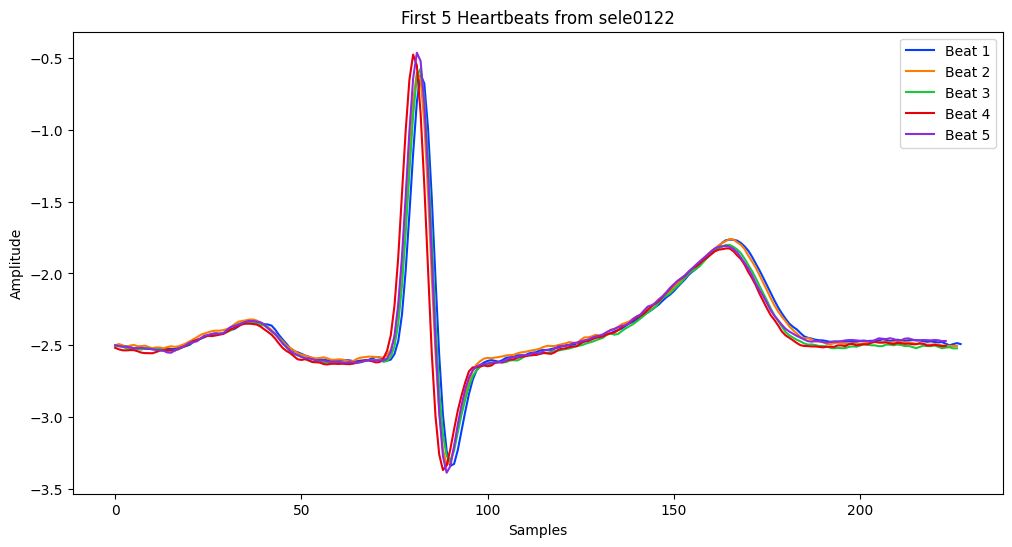

In [166]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# 저장된 pkl 파일 로드
file_path = "/home/dhc99/ecg_denoise/data/QTDatabase.pkl"

with open(file_path, "rb") as file:
    QTDatabase = pickle.load(file)

# 데이터 확인
print(f"총 {len(QTDatabase)}개의 ECG 신호가 저장됨")
print(f"샘플 신호 목록: {list(QTDatabase.keys())[:5]}")  # 처음 5개 신호 이름 출력

# 특정 신호 선택 (첫 번째 신호)
first_key = list(QTDatabase.keys())[0]
beats = QTDatabase[first_key]

print(f"선택된 신호({first_key})에서 {len(beats)}개의 비트(heartbeat) 존재")

# 몇 개의 비트 길이 확인
beat_lengths = [len(b) for b in beats]
print(f"비트 길이 (최소: {min(beat_lengths)}, 최대: {max(beat_lengths)}, 평균: {np.mean(beat_lengths):.2f})")


# 첫 번째 신호의 처음 5개 비트를 시각화
plt.figure(figsize=(12, 6))
for i in range(min(5, len(beats))):
    plt.plot(beats[i], label=f"Beat {i+1}")

plt.title(f"First 5 Heartbeats from {first_key}")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()
